**Loading** **necessary packages**

In [1]:
import os
import glob
import json
import random
from pathlib import Path
from difflib import SequenceMatcher


import cv2
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sroie_folder_path = Path('/content/drive/MyDrive/Dissertation/SROIE2019')
example_file = 'X51005365187.txt'

In [4]:
example_file

'X51005365187.txt'

In [5]:
def read_bbox_and_words(path: Path):
  bbox_and_words_list = []

  with open(path, 'r', errors='ignore') as f:
    for line in f.read().splitlines():
      if len(line) == 0:
        continue

      split_lines = line.split(",")

      bbox = np.array(split_lines[0:8], dtype=np.int32)
      text = ",".join(split_lines[8:])

      # From the splited line we save (filename, [bounding box points], text line).
      # The filename will be useful in the future
      bbox_and_words_list.append([path.stem, *bbox, text])

  dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'])
  dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

  return dataframe


# Example usage
bbox_file_path = sroie_folder_path / "test/box" / example_file
print("== File content ==")
!head -n 5 "{bbox_file_path}"

bbox = read_bbox_and_words(path=bbox_file_path)
print("\n== Dataframe ==")
bbox.head(5)

== File content ==
17,35,371,35,371,91,17,91,3-1707067
222,115,511,115,511,143,222,143,F&P PHARMACY
274,148,457,148,457,174,274,174,(002309592-P)
204,183,529,183,529,210,204,210,NO.20. GROUND FLOOR,
99,218,632,218,632,244,99,244,JALAN BS 10/6 TAMAN BUKIT SERDANG,

== Dataframe ==


,filename,x0,y0,x2,y2,line
0,X51005365187,17,35,371,91,3-1707067
1,X51005365187,222,115,511,143,F&P PHARMACY
2,X51005365187,274,148,457,174,(002309592-P)
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,"
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,"


In [6]:
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe

In [7]:
entities_file_path = sroie_folder_path /  "test/entities" / example_file
print("== File content ==")
!head "{entities_file_path}"

entities = read_entities(path=entities_file_path)
print("\n\n== Dataframe ==")
entities

== File content ==
{
    "company": "F&P PHARMACY",
    "date": "02/03/2018",
    "address": "NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT SERDANG, SEKSYEN 10, 43300 SERI KEMBANGAN. SELANGOR DARUL EHSAN",
    "total": "31.90"
}

== Dataframe ==


,company,date,address,total
0,F&P PHARMACY,02/03/2018,"NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT...",31.90


In [8]:
from difflib import SequenceMatcher

def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    best_match_score = 0
    best_match_label = "O"

    for column in entities.columns:
        entity_values = entities[column].iloc[0].replace(",", "").strip()
        entity_set = entity_values.split()

        matches_count = sum(1 for l in line_set if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set))
        similarity_score = matches_count / len(line_set)

        if (column.upper() == 'ADDRESS' and similarity_score >= 0.5) or \
           (column.upper() != 'ADDRESS' and similarity_score == 1):
            return column.upper()

        if matches_count > 0 and similarity_score > best_match_score:
            best_match_score = similarity_score
            best_match_label = column.upper()

    return best_match_label

line = bbox.loc[1,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)


Line: F&P PHARMACY
Assigned label: COMPANY


In [9]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Go through every line in $words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
           (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Example usage
bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(50)

,filename,x0,y0,x2,y2,line,label
0,X51005365187,17,35,371,91,3-1707067,O
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY
2,X51005365187,274,148,457,174,(002309592-P),O
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,",ADDRESS
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,",ADDRESS
5,X51005365187,111,250,623,275,"SEKSYEN 10, 43300 SERI KEMBANGAN,",ADDRESS
6,X51005365187,186,284,538,308,SELANGOR DARUL EHSAN,ADDRESS
7,X51005365187,251,316,484,339,TEL 03-89599823,O
8,X51005365187,182,351,346,378,GST REG NO,O
9,X51005365187,274,387,461,409,TAX INVOICE,O


In [10]:
def split_line(line: pd.Series):
  line_copy = line.copy()

  line_str = line_copy.loc["line"]
  words = line_str.split(" ")

  # Filter unwanted tokens
  words = [word for word in words if len(word) >= 1]

  x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
  bbox_width = x2 - x0


  new_lines = []
  for index, word in enumerate(words):
    x2 = x0 + int(bbox_width * len(word)/len(line_str))
    line_copy.at['x0'] = x0
    line_copy.at['x2'] = x2
    line_copy.at['line'] = word
    new_lines.append(line_copy.to_list())
    x0 = x2 + 5

  return new_lines


# Example usage
new_lines = split_line(bbox_labeled.loc[1])
print("Original row:")
display(bbox_labeled.loc[1:1,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)


Original row:


,filename,x0,y0,x2,y2,line,label
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY


Splitted row:


,filename,x0,y0,x2,y2,line,label
0,X51005365187,222,115,294,143,F&P,COMPANY
1,X51005365187,299,115,491,143,PHARMACY,COMPANY


In [11]:
def dataset_creator(folder: Path):
    bbox_folder = folder / 'box'
    entities_folder = folder / 'entities'
    img_folder = folder / 'img'

    entities_files = sorted(entities_folder.glob("*.txt"))
    bbox_files = sorted(bbox_folder.glob("*.txt"))
    img_files = sorted(img_folder.glob("*.jpg"))

    data = []

    print("Reading dataset:")
    for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):
        # Read the files
        bbox = read_bbox_and_words(bbox_file)
        entities = read_entities(entities_file)
        image = Image.open(img_file)

        # Assign labels to lines in bbox using entities
        bbox_labeled = assign_labels(bbox, entities)

        width, height = image.size

        data.append([bbox_labeled, width, height])

    return data


In [ ]:
# def dataset_creator(folder: Path):
#     bbox_folder = folder / 'box'
#     entities_folder = folder / 'entities'
#     img_folder = folder / 'img'

#     entities_files = sorted(entities_folder.glob("*.txt"))
#     bbox_files = sorted(bbox_folder.glob("*.txt"))
#     img_files = sorted(img_folder.glob("*.jpg"))

#     data = []

#     print("Reading dataset:")
#     for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):
#         # Read the files
#         bbox = read_bbox_and_words(bbox_file)
#         entities = read_entities(entities_file)
#         image = Image.open(img_file)

#         # Assign labels to lines in bbox using entities
#         bbox_labeled = assign_labels(bbox, entities)

#         # Split lines into separate tokens
#         new_bbox_l = []
#         for index, row in bbox_labeled.iterrows():
#             new_bbox_l += split_line(row)
#         new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns)

#         # Further refine labeling for increased precision
#         for index, row in new_bbox.iterrows():
#             label = row['label']

#             if label != "O":
#                 entity_values = entities.iloc[0, entities.columns.get_loc(label.lower())]
#                 entity_set = entity_values.split()

#                 # Check similarity with entity set, if high, label as entity, otherwise 'O'
#                 if any(SequenceMatcher(a=row['line'], b=b).ratio() > 0.7 for b in entity_set):
#                     label = "S-" + label  # Prefix 'S-' denotes a specific entity
#                 else:
#                     label = "O"

#             new_bbox.at[index, 'label'] = label

#         width, height = image.size

#         data.append([new_bbox, width, height])

#     return data

In [ ]:
dataset_train = dataset_creator(sroie_folder_path / 'train')

Reading dataset:


100%|██████████| 626/626 [08:23<00:00,  1.24it/s]


In [ ]:
dataset_test = dataset_creator(sroie_folder_path / 'test')

Reading dataset:


100%|██████████| 347/347 [04:41<00:00,  1.23it/s]


In [ ]:
print(dataset_test[5])

[        filename   x0    y0   x2    y2  \
0   X51005230621  166   329  409   355   
1   X51005230621  179   358  333   382   
2   X51005230621  170   404  410   426   
3   X51005230621  181   431  396   455   
4   X51005230621  140   463  442   485   
5   X51005230621  140   493  437   515   
6   X51005230621   42   525  497   545   
7   X51005230621  128   556  448   582   
8   X51005230621  146   589  437   617   
9   X51005230621  210   641  348   661   
10  X51005230621   44   706  234   727   
11  X51005230621   41   748  164   771   
12  X51005230621  213   746  329   769   
13  X51005230621   44   778  106   801   
14  X51005230621  215   780  339   801   
15  X51005230621   41   810  148   833   
16  X51005230621  211   812  223   834   
17  X51005230621  297   859  334   880   
18  X51005230621  436   858  495   881   
19  X51005230621   42   896  241   920   
20  X51005230621  287   933  342   956   
21  X51005230621  475   935  507   956   
22  X51005230621   56   967  147 

In [ ]:
print(dataset_train[3])

[        filename   x0   y0   x2   y2                                line  \
0   X00016469622   96   41  353   79                       TAN WOON YANN   
1   X00016469622   88  107  366  133                 YONGFATT ENTERPRISE   
2   X00016469622  171  137  280  155                         (JM0517726)   
3   X00016469622  104  162  347  179           NO 122.124 JALAN DEDAP 13   
4   X00016469622  136  184  316  198                   81100 JOHOR BAHRU   
5   X00016469622  157  220  295  238                      TEL 07-3523888   
6   X00016469622  135  252  320  269                GST ID: 000849813504   
7   X00016469622  112  277  349  296              SIMPLIFIED TAX INVOICE   
8   X00016469622   18  316   66  333                                CASH   
9   X00016469622   19  343   78  360                              DOC NO   
10  X00016469622  141  337  251  358                          CS00031663   
11  X00016469622  276  341  312  359                                DATE   
12  X000164

**Data Preprocessing**

In [12]:
import os
import pandas as pd

# Path to the entities folder
entities_folder = "/content/drive/MyDrive/Dissertation/SROIE2019/train/entities"

# Function to read company values from JSON files
def read_company_values(folder):
    company_values = []
    for file_name in os.listdir(folder):
        if file_name.endswith(".txt"):
            with open(os.path.join(folder, file_name), "r") as file:
                data = json.load(file)
                company_value = data.get("company")
                if company_value:
                    company_values.append(company_value)
    return company_values

# Read company values from JSON files
company_values = read_company_values(entities_folder)

# Create DataFrame
company_df = pd.DataFrame({"company": company_values})

# Display DataFrame
print(company_df)


                                      company
0                    SHELL ISNI PETRO TRADING
1                              ABC HO TRADING
2                   LIGHTROOM GALLERY SDN BHD
3                   LIGHTROOM GALLERY SDN BHD
4                       MR D.I.Y. (M) SDN BHD
..                                        ...
621                     KEDAI PAPAN YEW CHUAN
622  ONE ONE THREE SEAFOOD RESTAURANT SDN BHD
623              LIAN HING STATIONERY SDN BHD
624                     KEDAI PAPAN YEW CHUAN
625                     KEDAI PAPAN YEW CHUAN

[626 rows x 1 columns]


In [13]:
num_unique_companies = company_df['company'].nunique()
print("Number of unique companies:", num_unique_companies)

Number of unique companies: 236


Number of unique companies: 236
Top 10 companies:
company
GARDENIA BAKERIES (KL) SDN BHD                       45
UNIHAKKA INTERNATIONAL SDN BHD                       42
SANYU STATIONERY SHOP                                36
99 SPEED MART S/B                                    31
MR. D.I.Y. (M) SDN BHD                               29
RESTORAN WAN SHENG                                   26
SYARIKAT PERNIAGAAN GIN KEE                          22
AEON CO. (M) BHD                                     15
ONE ONE THREE SEAFOOD RESTAURANT SDN BHD             12
AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD    12
Name: count, dtype: int64
Number of missing values in company column: 0


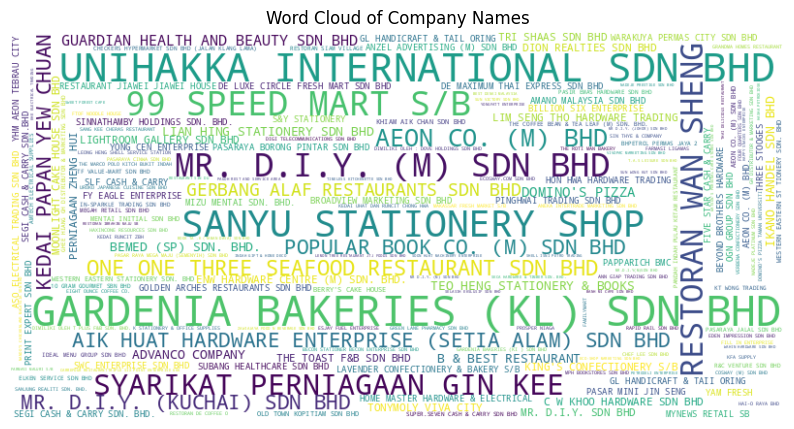

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming company_df contains the DataFrame with the 'company' column

# Basic statistics
num_unique_companies = company_df['company'].nunique()
company_counts = company_df['company'].value_counts()

print("Number of unique companies:", num_unique_companies)
print("Top 10 companies:")
print(company_counts.head(10))

# Data cleaning
# Check for missing values
missing_values = company_df['company'].isnull().sum()
print("Number of missing values in company column:", missing_values)

# # Visualization
# # Plot histogram of company name frequencies
# plt.figure(figsize=(10, 6))
# company_counts.plot(kind='bar', color='skyblue')
# plt.title('Company Name Frequencies')
# plt.xlabel('Company Name')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.show()

# Generate word cloud of company names
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(company_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Company Names')
plt.show()


In [15]:
pip install fuzzywuzzy

In [16]:
import json
from google.colab.patches import cv2_imshow
from fuzzywuzzy import fuzz
import cv2
import numpy as np

# Load entities from JSON file
with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/X51005447848.txt', 'r') as f:
    entities_data = json.load(f)

# Extract company, address, date, and total text from entities data
company_text = entities_data.get("company", "").strip("'")  # Remove single quotes
address_text = entities_data.get("address", "").strip("'")  # Remove single quotes
date_text = entities_data.get("date", "").strip("'")  # Remove single quotes
total_text = entities_data.get("total", "").strip("'")  # Remove single quotes

# Print the extracted texts
print("Extracted Company Text:", company_text)
print("Extracted Address Text:", address_text)
print("Extracted Date Text:", date_text)
print("Extracted Total Text:", total_text)

# Define variables to store company, address, date, and total coordinates
company_coordinates = []
address_coordinates = []
date_coordinates = []
total_coordinates = []
other_coordinates = []  # Store coordinates other than company, address, date, and total

# Loop through the lines in the box file
with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/box/X51005447848.txt', 'r') as f:
    box_lines = f.readlines()

for line in box_lines:
    # Extract coordinates and text from the line
    parts = line.strip().split(',')
    coordinates = list(map(int, parts[:8]))  # Extract coordinates
    text = ",".join(parts[8:]).strip("'")  # Join the remaining parts as text and remove single quotes

    # Check if the text matches the company, address, date, or total using fuzzy matching
    if fuzz.token_set_ratio(text, company_text) >= 90:  # Adjust the threshold as needed
        company_coordinates.append(coordinates)
    elif fuzz.token_set_ratio(text, address_text) >= 90:  # Adjust the threshold as needed
        address_coordinates.append(coordinates)
    elif fuzz.token_set_ratio(text, date_text) >= 90:  # Adjust the threshold as needed
        date_coordinates = coordinates
    elif fuzz.token_set_ratio(text, total_text) >= 90:  # Adjust the threshold as needed
        total_coordinates = coordinates
    else:
        other_coordinates.append(coordinates)  # Store coordinates other than company, address, date, and total

# Display the coordinates
print("Company Coordinates:", company_coordinates)
print("Address Coordinates:", address_coordinates)
print("Date Coordinates:", date_coordinates)
print("Total Coordinates:", total_coordinates)
print("Other Coordinates:", other_coordinates)

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Extracted Company Text: LIAN CHI PU TIAN VEGETARIAN RESTAURANT SDN BHD
Extracted Address Text: 54,JALAN SS23/11 TAMAN SEA,47400 PETALING JAYA,SELANGOR
Extracted Date Text: 06/01/18
Extracted Total Text: 53.55
Company Coordinates: [[156, 181, 789, 181, 789, 222, 156, 222], [239, 238, 720, 238, 720, 272, 239, 272]]
Address Coordinates: [[330, 362, 630, 362, 630, 394, 330, 394], [333, 396, 632, 396, 632, 432, 333, 432], [249, 433, 705, 433, 705, 467, 249, 467]]
Date Coordinates: [273, 646, 435, 646, 435, 677, 273, 677]
Total Coordinates: [721, 1629, 850, 1629, 850, 1670, 721, 1670]
Other Coordinates: [[379, 282, 579, 282, 579, 315, 379, 315], [257, 322, 705, 322, 705, 359, 257, 359], [258, 471, 699, 471, 699, 509, 258, 509], [108, 545, 324, 545, 324, 594, 108, 594], [111, 608, 285, 608, 285, 636, 111, 636], [111, 644, 186, 644, 186, 675, 111, 675], [462, 645, 648, 645, 648, 681, 462, 681], [108, 708, 177, 708, 177, 740, 108, 740], [308, 709, 367, 709, 367, 743, 308, 743], [448, 705, 525, 

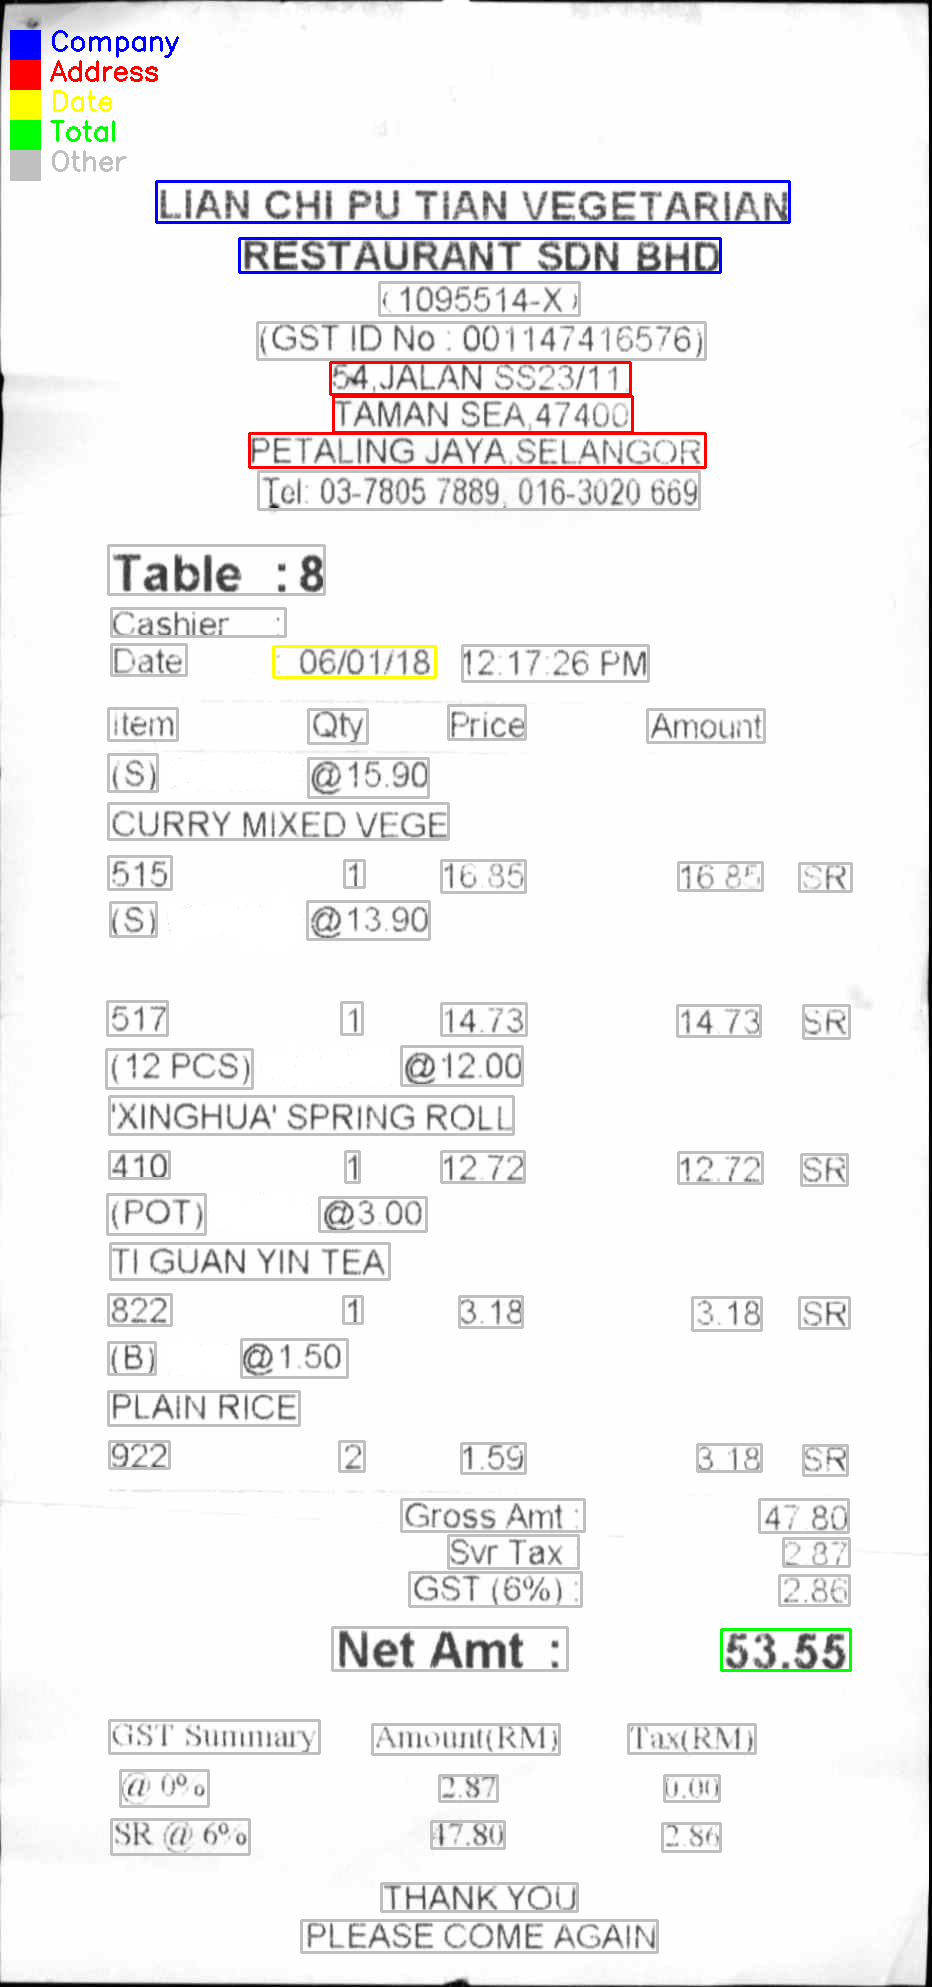

In [17]:
# Load the image
image_path = '/content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51005447848.jpg'
image = cv2.imread(image_path)

# Define colors for different entities
colors = {
    'company': (255, 0, 0),  # Blue
    'address': (0, 0, 255),  # Red
    'date': (0, 255, 255),   # Yellow
    'total': (0, 255, 0),    # Green
    'other': (192, 192, 192) # Grey
}

# Define function to draw boxes on the image
def draw_boxes(image, coordinates, color):
    if coordinates:
        # Check if the coordinates are a list of lists or a single list
        if isinstance(coordinates[0], list):
            # If coordinates is a list of lists
            for coord in coordinates:
                # Draw the rectangle using the correct indices
                cv2.rectangle(image, (coord[0], coord[1]), (coord[4], coord[5]), color, 2)
        else:
            # If coordinates is a single list
            cv2.rectangle(image, (coordinates[0], coordinates[1]), (coordinates[4], coordinates[5]), color, 2)

# Draw boxes for different entities on the image
draw_boxes(image, company_coordinates, colors['company'])
draw_boxes(image, address_coordinates, colors['address'])
draw_boxes(image, [date_coordinates], colors['date'])  # Note: date_coordinates should be a single coordinate pair
draw_boxes(image, [total_coordinates], colors['total'])  # Note: total_coordinates should be a single coordinate pair

# Draw grey boxes for other coordinates
draw_boxes(image, other_coordinates, colors['other'])

# Add a legend to the image
legend_texts = ['Company', 'Address', 'Date', 'Total', 'Other']
legend_colors = [colors['company'], colors['address'], colors['date'], colors['total'], colors['other']]
start_x, start_y = 50, 50
line_height = 30

for i, (text, color) in enumerate(zip(legend_texts, legend_colors)):
    cv2.putText(image, text, (start_x, start_y + i * line_height), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    cv2.rectangle(image, (start_x - 40, start_y - 20 + i * line_height), (start_x - 10, start_y + 10 + i * line_height), color, -1)

# Display the image with the legend
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [18]:
import os
import json
import cv2
from fuzzywuzzy import fuzz

# Load entities from JSON file
def load_entities(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Extract text from entities data
def extract_text(entities_data, key):
    return entities_data.get(key, "").strip("'")

# Define function to draw boxes on the image
def draw_boxes(image, coordinates, color, filename):
    if coordinates:
        if isinstance(coordinates[0], list):
            for coord in coordinates:
                if len(coord) >= 8:  # Check if coordinates have at least 8 elements
                    cv2.rectangle(image, (coord[0], coord[1]), (coord[4], coord[5]), color, 2)
                else:
                    print(f"Invalid coordinates in file: {filename}")
        else:
            if len(coordinates) >= 8:  # Check if coordinates have at least 8 elements
                cv2.rectangle(image, (coordinates[0], coordinates[1]), (coordinates[4], coordinates[5]), color, 2)
            else:
                print(f"Invalid coordinates in file: {filename}")

# Process each file
def process_file(box_file, entity_file, image_file):
    # Load entities
    entities_data = load_entities(entity_file)

    # Extract relevant text
    company_text = extract_text(entities_data, "company")
    address_text = extract_text(entities_data, "address")
    date_text = extract_text(entities_data, "date")
    total_text = extract_text(entities_data, "total")

    # Define variables to store coordinates
    company_coordinates = []
    address_coordinates = []
    date_coordinates = []
    total_coordinates = []
    other_coordinates = []

    # Loop through the lines in the box file
    with open(box_file, 'r') as f:
        box_lines = f.readlines()

    for line in box_lines:
        parts = line.strip().split(',')
        coordinates = list(map(int, parts[:8]))
        text = ",".join(parts[8:]).strip("'")

        # Fuzzy matching to identify entities
        if fuzz.token_set_ratio(text, company_text) >= 90:
            company_coordinates.append(coordinates)
        elif fuzz.token_set_ratio(text, address_text) >= 90:
            address_coordinates.append(coordinates)
        elif fuzz.token_set_ratio(text, date_text) >= 90:
            date_coordinates = coordinates
        elif fuzz.token_set_ratio(text, total_text) >= 90:
            total_coordinates = coordinates
        else:
            other_coordinates.append(coordinates)

    # Load the image
    image = cv2.imread(image_file)

    # Draw boxes for different entities
    draw_boxes(image, company_coordinates, colors['company'], image_file)
    draw_boxes(image, address_coordinates, colors['address'], image_file)
    draw_boxes(image, [date_coordinates], colors['date'], image_file)
    draw_boxes(image, [total_coordinates], colors['total'], image_file)
    draw_boxes(image, other_coordinates, colors['other'], image_file)

    # Save the annotated image
    output_path = os.path.join("/content/boxed_receipts", os.path.basename(image_file))
    cv2.imwrite(output_path, image)

# Define colors for different entities
colors = {
    'company': (255, 0, 0),  # Blue
    'address': (0, 0, 255),  # Red
    'date': (0, 255, 255),   # Yellow
    'total': (0, 255, 0),    # Green
    'other': (192, 192, 192) # Grey
}

# Create output directory if not exists
output_dir = "/content/boxed_receipts"
os.makedirs(output_dir, exist_ok=True)

# Process each file in the train directory
box_dir = "/content/drive/MyDrive/Dissertation/SROIE2019/train/box"
entity_dir = "/content/drive/MyDrive/Dissertation/SROIE2019/train/entities"
image_dir = "/content/drive/MyDrive/Dissertation/SROIE2019/train/img"

for box_file in os.listdir(box_dir):
    if box_file.endswith(".txt"):
        box_path = os.path.join(box_dir, box_file)
        entity_file = os.path.join(entity_dir, box_file)
        image_file = os.path.join(image_dir, box_file.replace(".txt", ".jpg"))

        if os.path.exists(entity_file) and os.path.exists(image_file):
            process_file(box_path, entity_file, image_file)


Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51005433522.jpg
Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51005447850.jpg
Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51006466060.jpg
Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51006679216.jpg
Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51007339106.jpg
Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51008142038.jpg


In [19]:
import os
import pandas as pd
import json

# Directory paths
box_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/train/box/'
entity_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/'

# Initialize a list to store extracted data
extracted_data = []

# Step 1: Read Bounding Box Files
for box_file in os.listdir(box_files_dir):
    if box_file.endswith('.txt'):
        # Construct full file path
        box_file_path = os.path.join(box_files_dir, box_file)

        # Read bounding box file
        with open(box_file_path, 'r') as file:
            bounding_boxes = []
            for line in file:
                parts = line.strip().split(',')
                bbox = list(map(int, parts[:8]))
                text = parts[8]
                bounding_boxes.append({'bbox': bbox, 'text': text})

        # Step 2: Read corresponding entity file
        entity_file_path = os.path.join(entity_files_dir, box_file)
        if os.path.exists(entity_file_path):
            with open(entity_file_path, 'r') as file:
                entities = json.load(file)
                company_name = entities.get('company', '')

            # Step 3: Match Bounding Boxes with Company Names
            for bbox in bounding_boxes:
                if company_name in bbox['text']:
                    extracted_data.append({
                        'Filename': box_file[:-4],  # Remove the ".txt" extension
                        'Bounding Box Coordinates': bbox['bbox'],
                        'Company Name': company_name
                    })

# Step 4: Generate Excel File
# Convert list to DataFrame
df = pd.DataFrame(extracted_data)

# Save DataFrame to Excel
output_file = 'bounding_boxes_with_company_names.xlsx'
df.to_excel(output_file, index=False)

print(f'Excel file "{output_file}" created successfully.')


Excel file "bounding_boxes_with_company_names.xlsx" created successfully.


In [20]:
import os
import pandas as pd
import json

# Directory paths
box_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/train/box/'
entity_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/'

# Initialize a list to store extracted data
extracted_data = []

# Step 1: Read Bounding Box Files
for box_file in os.listdir(box_files_dir):
    if box_file.endswith('.txt'):
        # Construct full file path
        box_file_path = os.path.join(box_files_dir, box_file)

        # Read bounding box file
        with open(box_file_path, 'r') as file:
            bounding_boxes = []
            for line in file:
                parts = line.strip().split(',')
                bbox = list(map(int, parts[:8]))
                bounding_boxes.append(bbox)

        # Step 2: Read corresponding entity file
        entity_file_path = os.path.join(entity_files_dir, box_file)
        if os.path.exists(entity_file_path):
            with open(entity_file_path, 'r') as file:
                entities = json.load(file)
                company_name = entities.get('company', '')

            # Step 3: Store all bounding boxes and the company name
            extracted_data.append({
                'Filename': box_file[:-4],  # Remove the ".txt" extension
                'Bounding Box Coordinates': bounding_boxes,
                'Company Name': company_name
            })

# Step 4: Generate Excel File
# Convert list to DataFrame
df = pd.DataFrame(extracted_data)

# Save DataFrame to Excel
output_file = 'bounding_boxes_with_company_names_train.xlsx'
df.to_excel(output_file, index=False)

print(f'Excel file "{output_file}" created successfully.')


Excel file "bounding_boxes_with_company_names_train.xlsx" created successfully.


In [21]:
import os
import pandas as pd
import json

# Directory paths
box_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/test/box/'
entity_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/test/entities/'

# Initialize a list to store extracted data
extracted_data = []

# Step 1: Read Bounding Box Files
for box_file in os.listdir(box_files_dir):
    if box_file.endswith('.txt'):
        # Construct full file path
        box_file_path = os.path.join(box_files_dir, box_file)

        # Read bounding box file
        with open(box_file_path, 'r', encoding='latin1', errors='ignore') as file:  # Specify encoding and error handling
            bounding_boxes = []
            for line in file:
                parts = line.strip().split(',')
                # Check if all parts are valid integers
                if len(parts) >= 8 and all(part.isdigit() for part in parts[:8]):
                    bbox = list(map(int, parts[:8]))
                    bounding_boxes.append(bbox)

        # Step 2: Read corresponding entity file
        entity_file_path = os.path.join(entity_files_dir, box_file)
        if os.path.exists(entity_file_path):
            with open(entity_file_path, 'r', encoding='latin1', errors='ignore') as file:  # Specify encoding and error handling
                entities = json.load(file)
                company_name = entities.get('company', '')

            # Step 3: Store all bounding boxes and the company name
            extracted_data.append({
                'Filename': box_file[:-4],  # Remove the ".txt" extension
                'Bounding Box Coordinates': bounding_boxes,
                'Company Name': company_name
            })

# Step 4: Generate Excel File
# Convert list to DataFrame
df = pd.DataFrame(extracted_data)

# Save DataFrame to Excel
output_file = 'bounding_boxes_with_company_names_test.xlsx'
df.to_excel(output_file, index=False)

print(f'Excel file "{output_file}" created successfully.')


Excel file "bounding_boxes_with_company_names_test.xlsx" created successfully.


Angle check- Train

In [22]:
import pandas as pd
import ast
import math
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/content/bounding_boxes_with_company_names_train.xlsx'
data_train = pd.read_excel(file_path)

# Extract the bounding box coordinates
bounding_boxes_column = data_train['Bounding Box Coordinates']

bounding_boxes = []
for cell in bounding_boxes_column:
    if pd.notna(cell):  # Check if the cell is not NaN
        # Convert the cell string to a list of lists
        boxes = ast.literal_eval(cell)
        for box in boxes:
            bounding_boxes.append(box)

def calculate_orientation_angle(box):
    # Extract top-left and top-right corner coordinates
    x1, y1 = box[0], box[1]
    x2, y2 = box[2], box[3]

    # Calculate the angle of orientation
    angle = math.atan2(y2 - y1, x2 - x1) * 180 / math.pi
    return angle

angles = []
for box in bounding_boxes:
    angle = calculate_orientation_angle(box)
    if angle != 0:
        angles.append(angle)

# Print all non-zero angles
for angle in angles:
    print(f"Angle of orientation: {angle}")


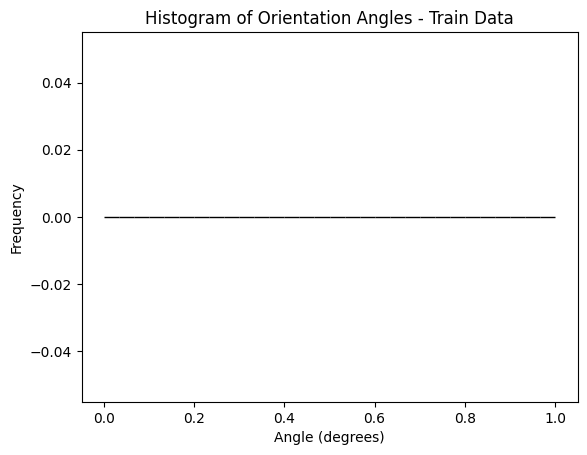

In [23]:
# Plot the histogram
plt.hist(angles, bins=30, edgecolor='black')
plt.title('Histogram of Orientation Angles - Train Data')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.show()


Angle check- Test

In [24]:
import pandas as pd
import ast
import math
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/content/testonly.xlsx'
data_test = pd.read_excel(file_path)

# Extract the bounding box coordinates
bounding_boxes_column = data_test['Bounding Box Coordinates']

bounding_boxes = []
for cell in bounding_boxes_column:
    if pd.notna(cell):  # Check if the cell is not NaN
        # Convert the cell string to a list of lists
        boxes = ast.literal_eval(cell)
        for box in boxes:
            bounding_boxes.append(box)

def calculate_orientation_angle(box):
    # Extract top-left and top-right corner coordinates
    x1, y1 = box[0], box[1]
    x2, y2 = box[2], box[3]

    # Calculate the angle of orientation
    angle = math.atan2(y2 - y1, x2 - x1) * 180 / math.pi
    return angle

angles = []
for box in bounding_boxes:
    angle = calculate_orientation_angle(box)
    if angle != 0:
        angles.append(angle)

# Print all non-zero angles
for angle in angles:
    print(f"Angle of orientation: {angle}")


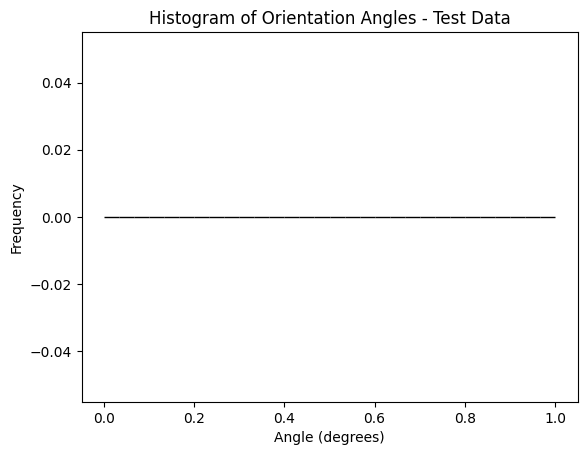

In [25]:
# Plot the histogram
plt.hist(angles, bins=30, edgecolor='black')
plt.title('Histogram of Orientation Angles - Test Data')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.show()

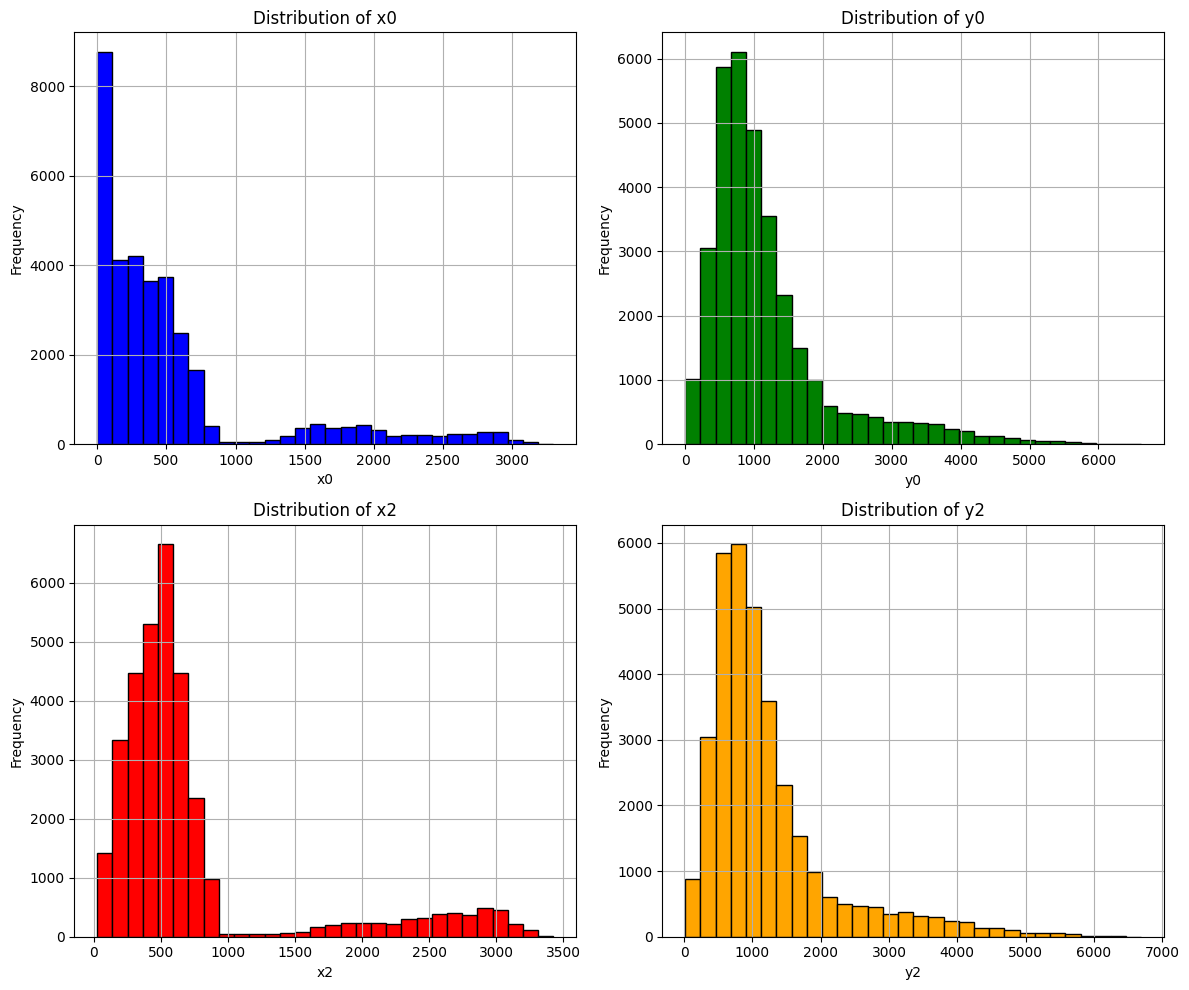

In [26]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/content/bounding_boxes_with_company_names_train.xlsx'
data_train = pd.read_excel(file_path)

# Extract the bounding box coordinates
bounding_boxes_column = data_train['Bounding Box Coordinates']

bounding_boxes = []
for cell in bounding_boxes_column:
    if pd.notna(cell):  # Check if the cell is not NaN
        # Convert the cell string to a list of lists
        boxes = ast.literal_eval(cell)
        for box in boxes:
            bounding_boxes.append(box)

# Extract minimum and maximum coordinate values
x_min_values = [box[0] for box in bounding_boxes]
y_min_values = [box[1] for box in bounding_boxes]
x_max_values = [box[4] for box in bounding_boxes]
y_max_values = [box[5] for box in bounding_boxes]

# Plot histograms
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(x_min_values, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of x0')
plt.xlabel('x0')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(y_min_values, bins=30, color='green', edgecolor='black')
plt.title('Distribution of y0')
plt.xlabel('y0')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(x_max_values, bins=30, color='red', edgecolor='black')
plt.title('Distribution of x2')
plt.xlabel('x2')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(y_max_values, bins=30, color='orange', edgecolor='black')
plt.title('Distribution of y2')
plt.xlabel('y2')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


**BASELINE**

In [30]:
import pandas as pd

# Load the train and test Excel files
train_df = pd.read_excel('/content/bounding_boxes_with_company_names_train.xlsx')
test_df = pd.read_excel('/content/testonly.xlsx')

# Display the first few rows to understand the structure
print(train_df.head())
print(test_df.head())


       Filename                           Bounding Box Coordinates  \
0  X51005306399  [[68, 13, 95, 13, 95, 51, 68, 51], [43, 87, 35...   
1  X51005268400  [[72, 27, 680, 27, 680, 81, 72, 81], [165, 82,...   
2  X51005255805  [[130, 68, 676, 68, 676, 105, 130, 105], [325,...   
3  X51005361900  [[723, 557, 1451, 557, 1451, 618, 723, 618], [...   
4  X00016469623  [[83, 41, 331, 41, 331, 78, 83, 78], [109, 171...   

                  Company Name  
0     SHELL ISNI PETRO TRADING  
1        RESTORAN HASSANBISTRO  
2           SAM SAM TRADING CO  
3  TEO HENG STATIONERY & BOOKS  
4        MR D.I.Y. (M) SDN BHD  
       Filename                           Bounding Box Coordinates  \
0  X51005230616  [[244, 105, 327, 105, 327, 167, 244, 167], [37...   
1  X51005200931  [[380, 241, 616, 241, 616, 266, 380, 266], [45...   
2  X51005361908  [[780, 315, 1262, 315, 1262, 362, 780, 362], [...   
3  X51005268275  [[174, 227, 682, 227, 682, 271, 174, 271], [23...   
4  X51005361912  [[119, 260, 84

In [36]:
import numpy as np
from scipy.sparse import coo_matrix

def normalize_coordinates(coordinates):
    coords_array = np.array(coordinates)
    max_coords = np.max(coords_array, axis=0)
    normalized_coords = coords_array / max_coords
    return normalized_coords

def calculate_area_and_centroid(coordinates):
    areas = []
    centroids = []
    for box in coordinates:
        x0, y0, x1, y1, x2, y2, x3, y3 = box
        area = (x2 - x0) * (y2 - y0)
        centroid_x = (x0 + x2) / 2
        centroid_y = (y0 + y2) / 2
        areas.append(area)
        centroids.append((centroid_x, centroid_y))
    return areas, centroids

def create_sparse_matrix(normalized_coords, areas, centroids):
    row = []
    col = []
    data = []

    for i, (coord, area, centroid) in enumerate(zip(normalized_coords, areas, centroids)):
        row.extend([i] * 3)
        col.extend([0, 1, 2])
        data.extend([area, centroid[0], centroid[1]])

    sparse_matrix = coo_matrix((data, (row, col)), shape=(len(normalized_coords), 3))
    return sparse_matrix


In [37]:
def pad_features(features, max_length):
    padded_features = []
    for feature in features:
        if len(feature) < max_length:
            padded_feature = np.pad(feature, (0, max_length - len(feature)), 'constant')
        else:
            padded_feature = feature[:max_length]
        padded_features.append(padded_feature)
    return np.array(padded_features)

def process_dataset(df, max_length):
    features = []
    labels = df['Company Name'].values

    for index, row in df.iterrows():
        bounding_boxes = eval(row['Bounding Box Coordinates'])
        normalized_coords = normalize_coordinates(bounding_boxes)
        areas, centroids = calculate_area_and_centroid(bounding_boxes)
        sparse_matrix = create_sparse_matrix(normalized_coords, areas, centroids)
        features.append(sparse_matrix.toarray().flatten())

    # Pad the features to ensure they have consistent length
    features = pad_features(features, max_length)
    return features, labels

# Determine the maximum length for padding based on the training dataset
max_length = train_df['Bounding Box Coordinates'].apply(lambda x: len(eval(x)) * 8).max()

# Process the train and test datasets
X_train, y_train = process_dataset(train_df, max_length)
X_test, y_test = process_dataset(test_df, max_length)


In [38]:
max_length

1224

In [39]:
X_train.shape

(626, 1224)

In [40]:
X_train

array([[1.0260e+03, 8.1500e+01, 3.2000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.2832e+04, 3.7600e+02, 5.4000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0202e+04, 4.0300e+02, 8.6500e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.7360e+03, 7.5000e+01, 2.9000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.1852e+04, 3.9050e+02, 3.5900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.7545e+04, 3.8750e+02, 3.4850e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [41]:
y_train

array(['SHELL ISNI PETRO TRADING', 'RESTORAN HASSANBISTRO',
       'SAM SAM TRADING CO', 'TEO HENG STATIONERY & BOOKS',
       'MR D.I.Y. (M) SDN BHD', 'SOON HUAT MACHINERY ENTERPRISE',
       'SYL ROASTED DELIGHTS SDN. BHD.', 'TEO HENG STATIONERY & BOOKS',
       'LIGHTROOM GALLERY SDN BHD', 'TED HENG STATIONERY & BOOKS',
       'INDAH GIFT & HOME DECO', 'FUYI MINI MARKET',
       'MR D.I.Y. (JOHOR) SDN BHD', 'GERBANG ALAF RESTAURANTS SDN BHD',
       'HOME MASTER HARDWARE & ELECTRICAL', 'TEO HENG STATIONERY & BOOKS',
       'ASIA MART', 'AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD',
       'LIGHTROOM GALLERY SDN BHD', 'YONGFATT ENTERPRISE',
       'LIGHTROOM GALLERY SDN BHD',
       'S.H.H. MOTOR (SUNGAI RENGIT) SDN. BHD.',
       'TEO HENG STATIONERY & BOOKS', 'BOOK TA .K (TAMAN DAYA) SDN BHD',
       'PERNIAGAAN ZHENG HUI', 'HOME MASTER HARDWARE & ELECTRICAL',
       'ABC HO TRADING', 'PERNIAGAAN ZHENG HUI', 'THREE STOOGES',
       'PASAR MINI JIN SENG', 'YHM AEON TEBRAU CITY

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 61.11%


In [43]:
# Print predicted and actual company names
for actual, predicted in zip(y_test, y_pred):
    print(f"Actual: {actual}, Predicted: {predicted}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Actual: GERBANG ALAF RESTAURANTS SDN BHD, Predicted: GERBANG ALAF RESTAURANTS SDN BHD
Actual: PERNIAGAAN ZHENG HUI, Predicted: PERNIAGAAN ZHENG HUI
Actual: TEO HENG STATIONERY & BOOKS, Predicted: CARREFOUR RESTAURANT
Actual: LIGHTROOM GALLERY SDN BHD, Predicted: LIGHTROOM GALLERY SDN BHD
Actual: TEO HENG STATIONERY & BOOKS, Predicted: SYARIKAT PERNIAGAAN GIN KEE
Actual: UROKO JAPANESE CUISINE SDN BHD, Predicted: GL HANDICRAFT & TAII ORING
Actual: SWC ENTERPRISE SDN BHD, Predicted: B & BEST RESTAURANT
Actual: PASAR MINI JIN SENG, Predicted: WARAKUYA PERMAS CITY SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: LIGHTROOM GALLERY SDN BHD, Predicted: LIGHTROOM GALLERY SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: YHM AEON TEBRAU CITY, Predicted: YHM AEON TEBRAU CITY
Actual: TRIPLE SIX POINT ENTERPRISE 666, Predicted: TRIPLE SIX POINT ENTERPRISE 666
Actual: TED HENG STATIONERY & BOOKS, Predic

In [44]:
# Example new bounding boxes
def predict_company(new_bounding_boxes, clf, max_length):
    normalized_coords = normalize_coordinates(new_bounding_boxes)
    areas, centroids = calculate_area_and_centroid(new_bounding_boxes)
    sparse_matrix = create_sparse_matrix(normalized_coords, areas, centroids)
    features = sparse_matrix.toarray().flatten()
    features = pad_features([features], max_length)
    predicted_company = clf.predict(features)
    return predicted_company


new_bounding_boxes = [[244, 105, 327, 105, 327, 167, 244, 167], [37, 188, 477, 188, 477, 225, 37, 225], [192, 227, 310, 227, 310, 260, 192, 260], [136, 256, 366, 256, 366, 289, 136, 289], [27, 287, 480, 287, 480, 324, 27, 324], [103, 323, 419, 323, 419, 362, 103, 362], [4, 356, 529, 356, 529, 391, 4, 391], [2, 389, 533, 389, 533, 428, 2, 428], [205, 422, 313, 422, 313, 453, 205, 453], [101, 451, 434, 451, 434, 486, 101, 486], [23, 484, 505, 484, 505, 519, 23, 519], [112, 517, 418, 517, 418, 550, 112, 550], [188, 552, 345, 552, 345, 583, 188, 583], [194, 616, 347, 616, 347, 653, 194, 653], [4, 680, 277, 680, 277, 721, 4, 721], [4, 715, 502, 715, 502, 752, 4, 752], [4, 751, 118, 751, 118, 782, 4, 782], [29, 782, 240, 782, 240, 813, 29, 813], [50, 819, 166, 819, 166, 850, 50, 850], [52, 848, 191, 848, 191, 887, 52, 887], [31, 881, 238, 881, 238, 914, 31, 914], [54, 914, 168, 914, 168, 945, 54, 945], [56, 949, 186, 949, 186, 976, 56, 976], [27, 980, 205, 980, 205, 1015, 27, 1015], [5, 1048, 321, 1048, 321, 1080, 5, 1080], [5, 1082, 183, 1082, 183, 1111, 5, 1111], [2, 1110, 190, 1110, 190, 1143, 2, 1143], [5, 1148, 90, 1148, 90, 1179, 5, 1179], [8, 1212, 285, 1212, 285, 1249, 8, 1249], [455, 751, 527, 751, 527, 784, 455, 784], [455, 788, 525, 788, 525, 817, 455, 817], [459, 881, 529, 881, 529, 916, 459, 916], [467, 982, 533, 982, 533, 1015, 467, 1015], [451, 1048, 525, 1048, 525, 1079, 451, 1079], [451, 1084, 528, 1084, 528, 1113, 451, 1113], [447, 1112, 528, 1112, 528, 1143, 447, 1143], [455, 1150, 527, 1150, 527, 1177, 455, 1177], [465, 1214, 527, 1214, 527, 1245, 465, 1245], [108, 1307, 476, 1307, 476, 1342, 108, 1342], [66, 1375, 451, 1375, 451, 1406, 66, 1406], [238, 1408, 279, 1408, 279, 1439, 238, 1439], [66, 1443, 465, 1443, 465, 1478, 66, 1478], [116, 1476, 416, 1476, 416, 1511, 116, 1511], [93, 1541, 422, 1541, 422, 1578, 93, 1578], [27, 1600, 457, 1600, 457, 1637, 27, 1637], [19, 1644, 532, 1644, 532, 1677, 19, 1677]]

predicted_company = predict_company(new_bounding_boxes, clf, max_length)
print(predicted_company)

['GERBANG ALAF RESTAURANTS SDN BHD']


In [45]:
def predict_company(new_bounding_boxes, clf, max_length):
    normalized_coords = normalize_coordinates(new_bounding_boxes)
    areas, centroids = calculate_area_and_centroid(new_bounding_boxes)
    sparse_matrix = create_sparse_matrix(normalized_coords, areas, centroids)
    features = sparse_matrix.toarray().flatten()
    features = pad_features([features], max_length)
    predicted_company = clf.predict(features)
    return predicted_company

def predict_and_print(new_bounding_boxes, actual_company, clf, max_length):
    predicted_company = predict_company(new_bounding_boxes, clf, max_length)
    print("Bounding Box Coordinates:")
    for bbox in new_bounding_boxes:
        print(bbox)
    print(f"Actual Company: {actual_company}")
    print(f"Predicted Company: {predicted_company[0]}")

predict_and_print(new_bounding_boxes, "Actual Company Name", clf, max_length)


Bounding Box Coordinates:
[244, 105, 327, 105, 327, 167, 244, 167]
[37, 188, 477, 188, 477, 225, 37, 225]
[192, 227, 310, 227, 310, 260, 192, 260]
[136, 256, 366, 256, 366, 289, 136, 289]
[27, 287, 480, 287, 480, 324, 27, 324]
[103, 323, 419, 323, 419, 362, 103, 362]
[4, 356, 529, 356, 529, 391, 4, 391]
[2, 389, 533, 389, 533, 428, 2, 428]
[205, 422, 313, 422, 313, 453, 205, 453]
[101, 451, 434, 451, 434, 486, 101, 486]
[23, 484, 505, 484, 505, 519, 23, 519]
[112, 517, 418, 517, 418, 550, 112, 550]
[188, 552, 345, 552, 345, 583, 188, 583]
[194, 616, 347, 616, 347, 653, 194, 653]
[4, 680, 277, 680, 277, 721, 4, 721]
[4, 715, 502, 715, 502, 752, 4, 752]
[4, 751, 118, 751, 118, 782, 4, 782]
[29, 782, 240, 782, 240, 813, 29, 813]
[50, 819, 166, 819, 166, 850, 50, 850]
[52, 848, 191, 848, 191, 887, 52, 887]
[31, 881, 238, 881, 238, 914, 31, 914]
[54, 914, 168, 914, 168, 945, 54, 945]
[56, 949, 186, 949, 186, 976, 56, 976]
[27, 980, 205, 980, 205, 1015, 27, 1015]
[5, 1048, 321, 1048, 321, 10

In [46]:
def predict_company(test_df, index, clf, max_length):
    bounding_boxes = eval(test_df.iloc[index]['Bounding Box Coordinates'])
    actual_company = test_df.iloc[index]['Company Name']

    normalized_coords = normalize_coordinates(bounding_boxes)
    areas, centroids = calculate_area_and_centroid(bounding_boxes)
    sparse_matrix = create_sparse_matrix(normalized_coords, areas, centroids)
    features = sparse_matrix.toarray().flatten()
    features = pad_features([features], max_length)
    predicted_company = clf.predict(features)

    # print("Bounding Box Coordinates:")
    # for idx, bbox in enumerate(bounding_boxes):
    #     print(f"Index: {idx}, Bounding Box: {bbox}")
    print(f"Actual Company: {actual_company}")
    # print(f"Predicted Company: {predicted_company[0]}")
    return predicted_company

# Choose an index from the test dataframe to make predictions on
index = 45  # You can change this index as needed

predicted_company = predict_company(test_df, index, clf, max_length)
print("Predicted Company")
print(predicted_company)


Actual Company: RESTORAN WAN SHENG
Predicted Company
['RESTORAN WAN SHENG']


In [47]:
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Evaluate the KNN model on the test set
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy (KNN): {accuracy_knn * 100:.2f}%")

# # Define a function to predict using KNN
# def predict_company_knn(test_df, index, knn, max_length):
#     bounding_boxes = eval(test_df.iloc[index]['Bounding Box Coordinates'])
#     actual_company = test_df.iloc[index]['Company Name']

#     normalized_coords = normalize_coordinates(bounding_boxes)
#     areas, centroids = calculate_area_and_centroid(bounding_boxes)
#     sparse_matrix = create_sparse_matrix(normalized_coords, areas, centroids)
#     features = sparse_matrix.toarray().flatten()
#     features = pad_features([features], max_length)
#     predicted_company = knn.predict(features)

#     print("Bounding Box Coordinates:")
#     for idx, bbox in enumerate(bounding_boxes):
#         print(f"Index: {idx}, Bounding Box: {bbox}")
#     print(f"Actual Company: {actual_company}")
#     print(f"Predicted Company (KNN): {predicted_company[0]}")
#     return predicted_company

# # Choose an index from the test dataframe to make predictions on
# index = 0  # You can change this index as needed

# predicted_company_knn = predict_company_knn(test_df, index, knn, max_length)
# print(predicted_company_knn)


Test Accuracy (KNN): 51.59%


Baseline- No normalisation

In [48]:
import numpy as np
from scipy.sparse import coo_matrix
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def calculate_area_and_centroid(coordinates):
    areas = []
    centroids = []
    for box in coordinates:
        x0, y0, x1, y1, x2, y2, x3, y3 = box
        area = (x2 - x0) * (y2 - y0)
        centroid_x = (x0 + x2) / 2
        centroid_y = (y0 + y2) / 2
        areas.append(area)
        centroids.append((centroid_x, centroid_y))
    return areas, centroids

def create_sparse_matrix(coords, areas, centroids):
    row = []
    col = []
    data = []

    for i, (coord, area, centroid) in enumerate(zip(coords, areas, centroids)):
        row.extend([i] * 3)
        col.extend([0, 1, 2])
        data.extend([area, centroid[0], centroid[1]])

    sparse_matrix = coo_matrix((data, (row, col)), shape=(len(coords), 3))
    return sparse_matrix

def pad_features(features, max_length):
    padded_features = []
    for feature in features:
        if len(feature) < max_length:
            padded_feature = np.pad(feature, (0, max_length - len(feature)), 'constant')
        else:
            padded_feature = feature[:max_length]
        padded_features.append(padded_feature)
    return np.array(padded_features)

def process_dataset(df, max_length):
    features = []
    labels = df['Company Name'].values

    for index, row in df.iterrows():
        bounding_boxes = eval(row['Bounding Box Coordinates'])
        areas, centroids = calculate_area_and_centroid(bounding_boxes)
        sparse_matrix = create_sparse_matrix(bounding_boxes, areas, centroids)  # Use bounding_boxes directly
        features.append(sparse_matrix.toarray().flatten())

    # Pad the features to ensure they have consistent length
    features = pad_features(features, max_length)
    return features, labels


# Determine the maximum length for padding based on the training dataset
max_length = train_df['Bounding Box Coordinates'].apply(lambda x: len(eval(x)) * 3).max()

# Process the train and test datasets
X_train, y_train = process_dataset(train_df, max_length)
X_test, y_test = process_dataset(test_df, max_length)

# Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 61.11%


In [49]:
X_train.shape

(626, 459)

In [50]:
y_train.shape

(626,)

In [51]:
# Print predicted and actual company names
for actual, predicted in zip(y_test, y_pred):
    print(f"Actual: {actual}, Predicted: {predicted}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Actual: GERBANG ALAF RESTAURANTS SDN BHD, Predicted: GERBANG ALAF RESTAURANTS SDN BHD
Actual: PERNIAGAAN ZHENG HUI, Predicted: PERNIAGAAN ZHENG HUI
Actual: TEO HENG STATIONERY & BOOKS, Predicted: CARREFOUR RESTAURANT
Actual: LIGHTROOM GALLERY SDN BHD, Predicted: LIGHTROOM GALLERY SDN BHD
Actual: TEO HENG STATIONERY & BOOKS, Predicted: SYARIKAT PERNIAGAAN GIN KEE
Actual: UROKO JAPANESE CUISINE SDN BHD, Predicted: GL HANDICRAFT & TAII ORING
Actual: SWC ENTERPRISE SDN BHD, Predicted: B & BEST RESTAURANT
Actual: PASAR MINI JIN SENG, Predicted: WARAKUYA PERMAS CITY SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: LIGHTROOM GALLERY SDN BHD, Predicted: LIGHTROOM GALLERY SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: YHM AEON TEBRAU CITY, Predicted: YHM AEON TEBRAU CITY
Actual: TRIPLE SIX POINT ENTERPRISE 666, Predicted: TRIPLE SIX POINT ENTERPRISE 666
Actual: TED HENG STATIONERY & BOOKS, Predic

In [35]:
def predict_company(test_df, index, clf, max_length):
    bounding_boxes = eval(test_df.iloc[index]['Bounding Box Coordinates'])
    actual_company = test_df.iloc[index]['Company Name']

    areas, centroids = calculate_area_and_centroid(bounding_boxes)
    sparse_matrix = create_sparse_matrix(bounding_boxes, areas, centroids)  # Use bounding_boxes directly
    features = sparse_matrix.toarray().flatten()
    features = pad_features([features], max_length)
    predicted_company = clf.predict(features)

    print(f"Actual Company: {actual_company}")
    return predicted_company

# Choose an index from the test dataframe to make predictions on
index = 45  # You can change this index as needed

predicted_company = predict_company(test_df, index, clf, max_length)
print("Predicted Company:")
print(predicted_company)

Actual Company: RESTORAN WAN SHENG
Predicted Company:
['RESTORAN WAN SHENG']


In [52]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have actual labels in 'actual_labels' and predicted labels in 'predicted_labels'
actual_labels = y_test
predicted_labels = y_pred

# Generate and print the classification report
print("Classification Report:")
print(classification_report(actual_labels, predicted_labels))

# Generate and print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(actual_labels, predicted_labels))


Classification Report:
                                                   precision    recall  f1-score   support

               32 PUB & BISTRO OWN BY CNU TRADING       0.00      0.00      0.00         0
                                99 SPEED MART S/B       0.67      0.77      0.71        13
                                   ABC HO TRADING       0.00      0.00      0.00         0
                                 AEON CO. (M) BHD       0.31      0.50      0.38         8
                                AEON CO. (M) BHD.       0.00      0.00      0.00         0
                             AEON CO. (M) SDN BHD       0.00      0.00      0.00         1
AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD       0.50      1.00      0.67         1
                           AMANO MALAYSIA SDN BHD       0.50      0.50      0.50         2
            AMPANG 210 FIRST CITY PARKING SDN BHD       0.00      0.00      0.00         0
               ANEKA INTERTRADE MARKETING SDN BHD       0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [53]:
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 0  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


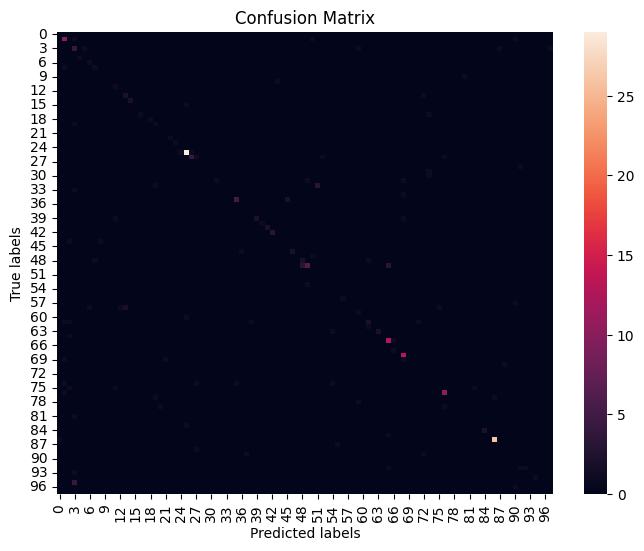

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you already have your confusion matrix stored in conf_matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


New try- Only 20 Vendor classes included

In [55]:
from collections import Counter
# Determine the top 20 most frequent classes
top_classes = [item[0] for item in Counter(train_df['Company Name']).most_common(20)]

# Filter the train_df to keep only top 20 classes
train_df_top20 = train_df[train_df['Company Name'].isin(top_classes)]

In [57]:
# Filter the test_df to keep only top 10 classes
test_df_top20 = test_df[test_df['Company Name'].isin(top_classes)]

In [58]:
train_df_top20.shape

(342, 3)

In [59]:
test_df_top20.shape

(161, 3)

In [60]:
train_df_top20['Company Name'].unique()

array(['TEO HENG STATIONERY & BOOKS', 'GERBANG ALAF RESTAURANTS SDN BHD',
       'AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD',
       'UNIHAKKA INTERNATIONAL SDN BHD', '99 SPEED MART S/B',
       'MR. D.I.Y. (M) SDN BHD', 'AEON CO. (M) BHD',
       'LIAN HING STATIONERY SDN BHD', 'POPULAR BOOK CO. (M) SDN BHD',
       'MR. D.I.Y. (KUCHAI) SDN BHD', 'IKANO HANDEL SDN BHD',
       'SYARIKAT PERNIAGAAN GIN KEE', 'ADVANCO COMPANY',
       'RESTORAN WAN SHENG', 'KEDAI PAPAN YEW CHUAN',
       'GUARDIAN HEALTH AND BEAUTY SDN BHD', "DOMINO'S PIZZA",
       'GARDENIA BAKERIES (KL) SDN BHD', 'SANYU STATIONERY SHOP',
       'ONE ONE THREE SEAFOOD RESTAURANT SDN BHD'], dtype=object)

In [61]:
test_df_top20['Company Name'].unique()

array(['GERBANG ALAF RESTAURANTS SDN BHD', 'TEO HENG STATIONERY & BOOKS',
       'UNIHAKKA INTERNATIONAL SDN BHD', '99 SPEED MART S/B',
       'POPULAR BOOK CO. (M) SDN BHD', 'AEON CO. (M) BHD',
       'RESTORAN WAN SHENG', 'SYARIKAT PERNIAGAAN GIN KEE',
       'KEDAI PAPAN YEW CHUAN', 'MR. D.I.Y. (M) SDN BHD',
       'GUARDIAN HEALTH AND BEAUTY SDN BHD',
       'GARDENIA BAKERIES (KL) SDN BHD', 'MR. D.I.Y. (KUCHAI) SDN BHD',
       'SANYU STATIONERY SHOP',
       'AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD',
       'IKANO HANDEL SDN BHD', 'LIAN HING STATIONERY SDN BHD'],
      dtype=object)

In [74]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from collections import Counter

def calculate_area_and_centroid(coordinates):
    areas = []
    centroids = []
    for box in coordinates:
        x0, y0, x1, y1, x2, y2, x3, y3 = box
        area = (x2 - x0) * (y2 - y0)
        centroid_x = (x0 + x2) / 2
        centroid_y = (y0 + y2) / 2
        areas.append(area)
        centroids.append((centroid_x, centroid_y))
    return areas, centroids

def create_sparse_matrix(coordinates, areas, centroids, num_rows, num_columns):
    row = []
    col = []
    data = []

    for i, (area, centroid) in enumerate(zip(areas, centroids)):
        row.extend([i] * 3)
        col.extend([0, 1, 2])
        data.extend([area, centroid[0], centroid[1]])

    sparse_matrix = coo_matrix((data, (row, col)), shape=(num_rows, num_columns))
    return sparse_matrix

def process_dataset(df, num_rows, num_columns):
    features = []
    labels = df['Company Name'].values

    for index, row in df.iterrows():
        bounding_boxes = eval(row['Bounding Box Coordinates'])
        areas, centroids = calculate_area_and_centroid(bounding_boxes)
        sparse_matrix = create_sparse_matrix(bounding_boxes, areas, centroids, num_rows, num_columns)
        features.append(sparse_matrix.toarray().flatten())

    return np.array(features), labels

In [75]:
# Define the size of the sparse matrix
num_rows = 200  # Example size
num_columns = 3  # Three columns for area, centroid_x, and centroid_y

# Process the filtered train and test datasets
X_train_baseline, y_train_baseline = process_dataset(train_df_top20, num_rows, num_columns)
X_test_baseline, y_test_baseline = process_dataset(test_df_top20, num_rows, num_columns)

In [76]:
X_train_baseline.shape

(342, 600)

In [77]:
X_train_baseline

array([[4.4408e+04, 1.0870e+03, 5.8750e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.3200e+04, 5.0100e+02, 4.7500e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.7240e+03, 2.7700e+02, 1.3850e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.7360e+03, 7.5000e+01, 2.9000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.1852e+04, 3.9050e+02, 3.5900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.7545e+04, 3.8750e+02, 3.4850e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [78]:
y_train_baseline

array(['TEO HENG STATIONERY & BOOKS', 'TEO HENG STATIONERY & BOOKS',
       'GERBANG ALAF RESTAURANTS SDN BHD', 'TEO HENG STATIONERY & BOOKS',
       'AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD',
       'TEO HENG STATIONERY & BOOKS', 'UNIHAKKA INTERNATIONAL SDN BHD',
       'UNIHAKKA INTERNATIONAL SDN BHD', 'UNIHAKKA INTERNATIONAL SDN BHD',
       'UNIHAKKA INTERNATIONAL SDN BHD', '99 SPEED MART S/B',
       'MR. D.I.Y. (M) SDN BHD', 'UNIHAKKA INTERNATIONAL SDN BHD',
       'UNIHAKKA INTERNATIONAL SDN BHD', 'AEON CO. (M) BHD',
       'UNIHAKKA INTERNATIONAL SDN BHD', 'UNIHAKKA INTERNATIONAL SDN BHD',
       'UNIHAKKA INTERNATIONAL SDN BHD', 'UNIHAKKA INTERNATIONAL SDN BHD',
       '99 SPEED MART S/B', 'LIAN HING STATIONERY SDN BHD',
       'POPULAR BOOK CO. (M) SDN BHD', 'LIAN HING STATIONERY SDN BHD',
       '99 SPEED MART S/B', '99 SPEED MART S/B',
       'UNIHAKKA INTERNATIONAL SDN BHD', 'UNIHAKKA INTERNATIONAL SDN BHD',
       'AEON CO. (M) BHD', 'UNIHAKKA INTERNATIONAL SDN 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_baseline, y_train_baseline)

# Evaluate the model on the test set
y_pred = clf.predict(X_test_baseline)
accuracy = accuracy_score(y_test_baseline, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 83.85%


In [ ]:
for actual, predicted in zip(y_test_baseline, y_pred):
    print(f"Actual: {actual}, Predicted: {predicted}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test_baseline, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Actual: GERBANG ALAF RESTAURANTS SDN BHD, Predicted: GERBANG ALAF RESTAURANTS SDN BHD
Actual: TEO HENG STATIONERY & BOOKS, Predicted: AEON CO. (M) BHD
Actual: TEO HENG STATIONERY & BOOKS, Predicted: SYARIKAT PERNIAGAAN GIN KEE
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: 99 SPEED MART S/B, Predicted: IKANO HANDEL SDN BHD
Actual: 99 SPEED MART S/B, Predicted: 99 SPEED MART S/B
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: POPULAR BOOK CO. (M) SDN BHD, Predicted: POPULAR BOOK CO. (M) SDN BHD
Actual: AEON CO. (M) BHD, Predicted: AEON CO. (M) BHD
Actual: POPULAR BOOK CO. (M) SDN BHD, Predicted: GERBANG ALAF RESTAURANTS SDN BHD
Actual: POPULAR BOOK CO. (M) SDN B

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have actual labels in 'actual_labels' and predicted labels in 'predicted_labels'
actual_labels = y_test_baseline
predicted_labels = y_pred

# Generate and print the classification report
print("Classification Report:")
print(classification_report(actual_labels, predicted_labels))

# Generate and print the confusion matrix
conf_matrix=confusion_matrix(actual_labels, predicted_labels)
print("\nConfusion Matrix:")
print(confusion_matrix(actual_labels, predicted_labels))

Classification Report:
                                                   precision    recall  f1-score   support

                                99 SPEED MART S/B       0.79      0.85      0.81        13
                                  ADVANCO COMPANY       0.00      0.00      0.00         0
                                 AEON CO. (M) BHD       0.67      0.50      0.57         8
AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD       1.00      1.00      1.00         1
                   GARDENIA BAKERIES (KL) SDN BHD       0.97      0.97      0.97        31
                 GERBANG ALAF RESTAURANTS SDN BHD       0.62      0.71      0.67         7
               GUARDIAN HEALTH AND BEAUTY SDN BHD       1.00      0.33      0.50         3
                             IKANO HANDEL SDN BHD       0.00      0.00      0.00         1
                            KEDAI PAPAN YEW CHUAN       1.00      0.71      0.83         7
                     LIAN HING STATIONERY SDN BHD       0.50      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

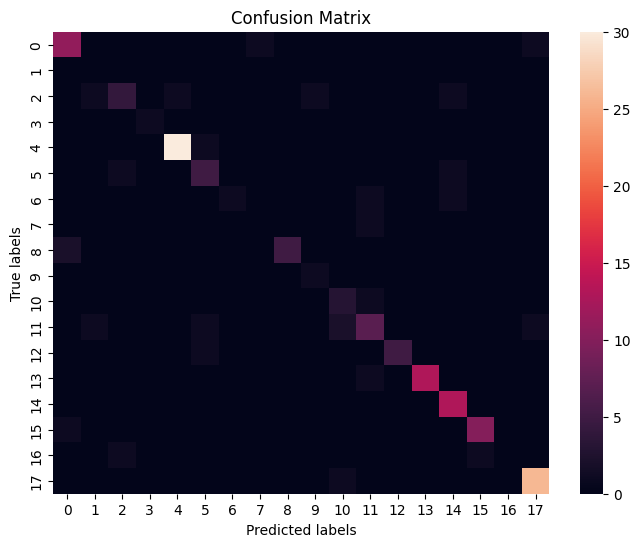

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you already have your confusion matrix stored in conf_matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train_baseline, y_train_baseline)

# Evaluate the KNN model on the test set
y_pred_knn = knn.predict(X_test_baseline)
accuracy_knn = accuracy_score(y_test_baseline, y_pred_knn)
print(f"Test Accuracy (KNN): {accuracy_knn * 100:.2f}%")

Test Accuracy (KNN): 78.26%


Randomforest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Train the Random Forest model
rf.fit(X_train_baseline, y_train_baseline)

# Evaluate the Random Forest model on the test set
y_pred_rf = rf.predict(X_test_baseline)
accuracy_rf = accuracy_score(y_test_baseline, y_pred_rf)
print(f"Test Accuracy (Random Forest): {accuracy_rf * 100:.2f}%")


Test Accuracy (Random Forest): 95.65%


XGBoost

In [79]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode labels in training and testing sets
y_train_encoded = label_encoder.fit_transform(y_train_baseline)
y_test_encoded = label_encoder.transform(y_test_baseline)

# Initialize XGBoost model
xgb_model = XGBClassifier()

# Train the model with the encoded labels
xgb_model.fit(X_train_baseline, y_train_encoded)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_baseline)

# Evaluate the accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Test Accuracy (XGBoost): {accuracy_xgb * 100:.2f}%")


Test Accuracy (XGBoost): 95.03%


Test Accuracy (XGBoost): 95.03%
Top 5 Classes Based on Number of Test Samples:
['GARDENIA BAKERIES (KL) SDN BHD' 'UNIHAKKA INTERNATIONAL SDN BHD'
 'RESTORAN WAN SHENG' '99 SPEED MART S/B' 'SANYU STATIONERY SHOP']

Classification Report for Top 5 Classes (XGBoost):
                                precision  recall  f1-score  support
GARDENIA BAKERIES (KL) SDN BHD        1.0     1.0       1.0     31.0
UNIHAKKA INTERNATIONAL SDN BHD        1.0     1.0       1.0     27.0
RESTORAN WAN SHENG                    1.0     1.0       1.0     14.0
99 SPEED MART S/B                     1.0     1.0       1.0     13.0
SANYU STATIONERY SHOP                 1.0     1.0       1.0     13.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

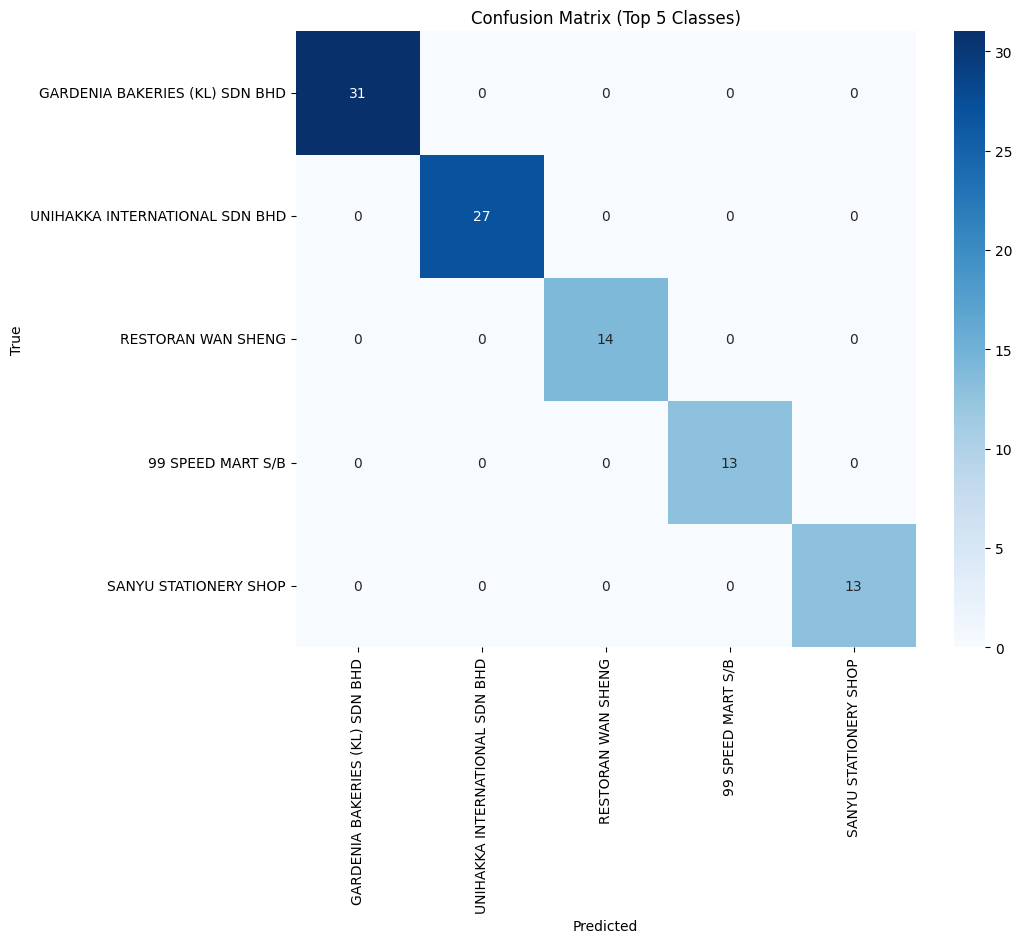

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the entire dataset
# Combine training and testing labels for consistent encoding
combined_labels = np.concatenate([y_train_baseline, y_test_baseline])
label_encoder.fit(combined_labels)

# Encode labels in training and testing sets
y_train_encoded = label_encoder.transform(y_train_baseline)
y_test_encoded = label_encoder.transform(y_test_baseline)

# Initialize XGBoost model
xgb_model = XGBClassifier()

# Train the model with the encoded labels
xgb_model.fit(X_train_baseline, y_train_encoded)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_baseline)

# Evaluate the accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Test Accuracy (XGBoost): {accuracy_xgb * 100:.2f}%")

# Compute classification report
report_xgb = classification_report(y_test_encoded, y_pred_xgb, labels=range(len(label_encoder.classes_)), target_names=label_encoder.classes_, output_dict=True)

# Convert the classification report to a DataFrame for easy visualization
report_df_xgb = pd.DataFrame(report_xgb).transpose()

# Count occurrences of each class in the test set
test_label_counts = pd.Series(y_test_encoded).value_counts().sort_values(ascending=False)
top_5_classes = test_label_counts.head(5).index

# Map top 5 class indices back to class names
top_5_class_names = label_encoder.inverse_transform(top_5_classes)
print("Top 5 Classes Based on Number of Test Samples:")
print(top_5_class_names)

# Generate classification report for top 5 classes
report_df_xgb_top_5 = report_df_xgb.loc[top_5_class_names]
print("\nClassification Report for Top 5 Classes (XGBoost):")
print(report_df_xgb_top_5)

# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_test_encoded, y_pred_xgb, labels=range(len(label_encoder.classes_)))

# Filter confusion matrix for top 5 classes
top_5_indices = [label_encoder.transform([label])[0] for label in top_5_class_names]
filtered_conf_matrix_xgb = conf_matrix_xgb[np.ix_(top_5_indices, top_5_indices)]

# Plot the filtered confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=top_5_class_names, yticklabels=top_5_class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Top 5 Classes)')
plt.show()


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the entire dataset
# Combine training and testing labels for consistent encoding
combined_labels = np.concatenate([y_train_baseline, y_test_baseline])
label_encoder.fit(combined_labels)

# Encode labels in training and testing sets
y_train_encoded = label_encoder.transform(y_train_baseline)
y_test_encoded = label_encoder.transform(y_test_baseline)

# Initialize XGBoost model
xgb_model = XGBClassifier()

# Train the model with the encoded labels
xgb_model.fit(X_train_baseline, y_train_encoded)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_baseline)

# Evaluate the accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Test Accuracy (XGBoost): {accuracy_xgb * 100:.2f}%")

# Compute classification report
report_xgb = classification_report(y_test_encoded, y_pred_xgb, labels=range(len(label_encoder.classes_)), target_names=label_encoder.classes_, output_dict=True)

# Convert the classification report to a DataFrame for easy visualization
report_df_xgb = pd.DataFrame(report_xgb).transpose()

# Sort by F1-score to find the top 5 classes
top_5_classes = report_df_xgb.sort_values(by='f1-score', ascending=False).head(5)
print("Top 5 Classes Based on F1-score:")
print(top_5_classes)

# Print the classification report for top 5 classes
print("\nClassification Report for Top 5 Classes (XGBoost):")
print(top_5_classes)


Test Accuracy (XGBoost): 95.03%
Top 5 Classes Based on F1-score:
                                                   precision  recall  \
99 SPEED MART S/B                                        1.0     1.0   
RESTORAN WAN SHENG                                       1.0     1.0   
AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD        1.0     1.0   
UNIHAKKA INTERNATIONAL SDN BHD                           1.0     1.0   
GARDENIA BAKERIES (KL) SDN BHD                           1.0     1.0   

                                                   f1-score  support  
99 SPEED MART S/B                                       1.0     13.0  
RESTORAN WAN SHENG                                      1.0     14.0  
AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD       1.0      1.0  
UNIHAKKA INTERNATIONAL SDN BHD                          1.0     27.0  
GARDENIA BAKERIES (KL) SDN BHD                          1.0     31.0  

Classification Report for Top 5 Classes (XGBoost):
                        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [83]:
import numpy as np

# Check unique classes in the test set
unique_classes = np.unique(y_test_encoded)
print(f"Unique classes in y_test_encoded: {unique_classes}")
print(f"Number of unique classes: {len(unique_classes)}")


Unique classes in y_test_encoded: [ 0  2  3  5  6  7  8  9 10 11 12 14 15 16 17 18 19]
Number of unique classes: 17


**TOPOLOGICAL DATA ANALYSIS METHODS**

In [ ]:
train_df_top20.shape

(342, 3)

In [ ]:
test_df_top20.shape

(161, 3)

In [63]:
pip install ripser


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 834.5/834.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.5 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18103 sha256=a06623b845a7f32934b686448d08df9c5d05b7b4011e318ced4d33d6f1e19cda
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built hopcroftkarp


In [64]:
pip install ripser matplotlib


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


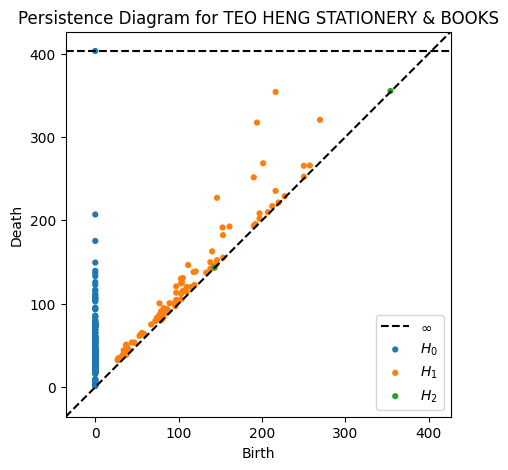

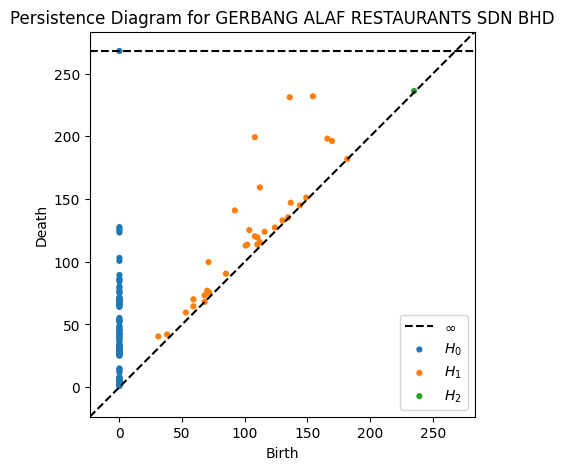

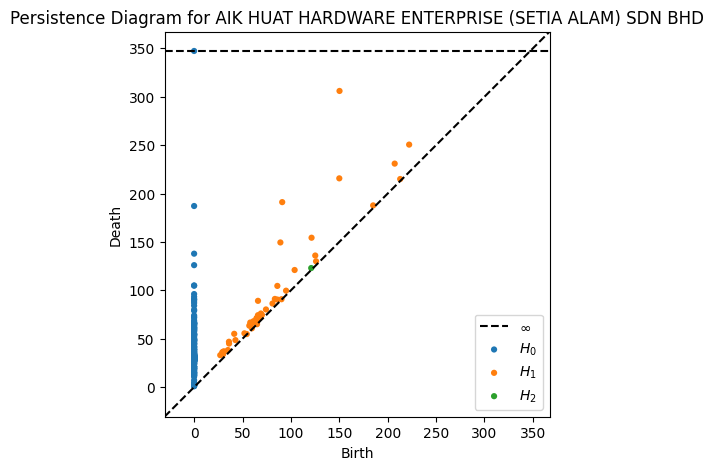

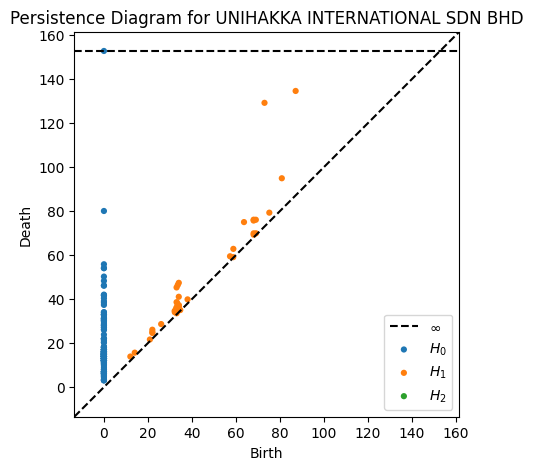

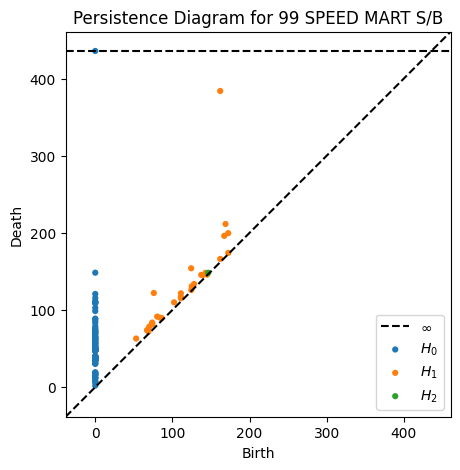

In [ ]:
import pandas as pd
import numpy as np
from ripser import Rips
import matplotlib.pyplot as plt


# Specify the companies to visualize
selected_companies = [
    'TEO HENG STATIONERY & BOOKS',
    'GERBANG ALAF RESTAURANTS SDN BHD',
    'AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD',
    'UNIHAKKA INTERNATIONAL SDN BHD',
    '99 SPEED MART S/B'
]

# Filter the data to include only the selected companies
filtered_data = train_df_top20[train_df_top20['Company Name'].isin(selected_companies)]

# Disable LaTeX in matplotlib
plt.rcParams['text.usetex'] = False

# Function to visualize persistence diagrams for one sample per vendor
def plot_one_sample_per_vendor(df, companies):
    rips = Rips(maxdim=2, thresh=np.inf, coeff=2, do_cocycles=False, n_perm=None, verbose=True)

    for company in companies:
        # Filter data for the current company
        company_data = df[df['Company Name'] == company]

        if company_data.empty:
            print(f"No data available for company: {company}")
            continue

        # Use the first sample for the company
        first_sample = company_data.iloc[0]
        bounding_boxes = first_sample['Bounding Box Coordinates']

        if isinstance(bounding_boxes, str):
            bounding_boxes = eval(bounding_boxes)

        points = np.array(bounding_boxes).reshape(-1, 2)

        # Compute persistence diagrams
        diagrams = rips.fit_transform(points)

        # Plot persistence diagram
        plt.figure(figsize=(10, 5))
        rips.plot(diagrams)
        plt.title(f'Persistence Diagram for {company}')
        plt.show()

# Visualize persistence diagrams for one sample from each of the selected companies
plot_one_sample_per_vendor(filtered_data, selected_companies)


In [ ]:
import numpy as np
import pandas as pd
from ripser import Rips

# Define a function to convert bounding box coordinates to points
def bounding_boxes_to_points(bounding_boxes):
    points = np.array(bounding_boxes).reshape(-1, 2)
    return points

# Define a function to compute persistence diagrams and extract features
def compute_persistence_features(data_list, epsilon=0.01):
    rips = Rips(maxdim=2)
    features = []

    for data in data_list:
        # Select only the top 20 bounding boxes
        top_20_data = data[:20]
        points = bounding_boxes_to_points(top_20_data)
        diagrams = rips.fit_transform(points)

        h0 = diagrams[0]
        h1 = diagrams[1] if len(diagrams) > 1 else np.array([])
        h2 = diagrams[2] if len(diagrams) > 2 else np.array([])

        # Filter out points close to the diagonal
        h0 = h0[h0[:, 1] - h0[:, 0] > epsilon]
        h1 = h1[h1[:, 1] - h1[:, 0] > epsilon]
        h2 = h2[h2[:, 1] - h2[:, 0] > epsilon]

        # Summary statistics for H0
        h0_lifetimes = h0[:, 1] - h0[:, 0] if h0.size > 0 else np.array([0])
        h0_avg_lifetime = np.mean(h0_lifetimes)
        h0_num_points = len(h0_lifetimes)

        # Summary statistics for H1
        h1_lifetimes = h1[:, 1] - h1[:, 0] if h1.size > 0 else np.array([0])
        h1_avg_lifetime = np.mean(h1_lifetimes)
        h1_num_points = len(h1_lifetimes)

        # Summary statistics for H2
        h2_lifetimes = h2[:, 1] - h2[:, 0] if h2.size > 0 else np.array([0])
        h2_avg_lifetime = np.mean(h2_lifetimes)
        h2_num_points = len(h2_lifetimes)

        features.append([h0_avg_lifetime, h0_num_points, h1_avg_lifetime, h1_num_points, h2_avg_lifetime, h2_num_points])

    return np.array(features)

# Apply the function to your filtered data
# Convert bounding box coordinates from string to list, select top 20, then compute features
raw_data_list = train_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_train = compute_persistence_features(raw_data_list)




Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [ ]:
# Replace infinity values with a large finite number
X_train[np.isinf(X_train)] = 1e10

In [ ]:
import numpy as np
import pandas as pd
from ripser import Rips
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Extract company names
y_train = train_df_top20['Company Name']

# # Encode company names into numerical values
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y)


# Train a classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
X_train.shape

(342, 6)

In [ ]:
y_train.shape

(342,)

In [ ]:
X_train

array([[1.00000000e+10, 8.00000000e+01, 1.65439564e+01, 1.90000000e+01,
        1.88751221e-01, 1.00000000e+00],
       [1.00000000e+10, 8.00000000e+01, 1.13116957e+01, 1.80000000e+01,
        0.00000000e+00, 1.00000000e+00],
       [1.00000000e+10, 8.00000000e+01, 1.93029192e+01, 1.30000000e+01,
        0.00000000e+00, 1.00000000e+00],
       ...,
       [1.00000000e+10, 8.00000000e+01, 5.13829532e+00, 1.90000000e+01,
        0.00000000e+00, 1.00000000e+00],
       [1.00000000e+10, 8.00000000e+01, 1.10934724e+01, 2.10000000e+01,
        0.00000000e+00, 1.00000000e+00],
       [1.00000000e+10, 8.00000000e+01, 9.62039221e+00, 2.10000000e+01,
        0.00000000e+00, 1.00000000e+00]])

In [ ]:
y_train

,Company Name
3,TEO HENG STATIONERY & BOOKS
7,TEO HENG STATIONERY & BOOKS
13,GERBANG ALAF RESTAURANTS SDN BHD
15,TEO HENG STATIONERY & BOOKS
17,AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD
22,TEO HENG STATIONERY & BOOKS
32,UNIHAKKA INTERNATIONAL SDN BHD
33,UNIHAKKA INTERNATIONAL SDN BHD
34,UNIHAKKA INTERNATIONAL SDN BHD
35,UNIHAKKA INTERNATIONAL SDN BHD


In [ ]:
import numpy as np
import pandas as pd
from ripser import Rips

# Define a function to convert bounding box coordinates to points
def bounding_boxes_to_points(bounding_boxes):
    points = np.array(bounding_boxes).reshape(-1, 2)
    return points

# Define a function to compute persistence diagrams and extract features
def compute_persistence_features(data_list, epsilon=0.01):
    rips = Rips(maxdim=2)
    features = []

    for data in data_list:
        # Select only the top 20 bounding boxes
        top_20_data = data[:20]
        points = bounding_boxes_to_points(top_20_data)
        diagrams = rips.fit_transform(points)

        h0 = diagrams[0]
        h1 = diagrams[1] if len(diagrams) > 1 else np.array([])
        h2 = diagrams[2] if len(diagrams) > 2 else np.array([])

        # Filter out points close to the diagonal
        h0 = h0[h0[:, 1] - h0[:, 0] > epsilon]
        h1 = h1[h1[:, 1] - h1[:, 0] > epsilon]
        h2 = h2[h2[:, 1] - h2[:, 0] > epsilon]

        # Summary statistics for H0
        h0_lifetimes = h0[:, 1] - h0[:, 0] if h0.size > 0 else np.array([0])
        h0_avg_lifetime = np.mean(h0_lifetimes)
        h0_num_points = len(h0_lifetimes)

        # Summary statistics for H1
        h1_lifetimes = h1[:, 1] - h1[:, 0] if h1.size > 0 else np.array([0])
        h1_avg_lifetime = np.mean(h1_lifetimes)
        h1_num_points = len(h1_lifetimes)

        # Summary statistics for H2
        h2_lifetimes = h2[:, 1] - h2[:, 0] if h2.size > 0 else np.array([0])
        h2_avg_lifetime = np.mean(h2_lifetimes)
        h2_num_points = len(h2_lifetimes)

        features.append([h0_avg_lifetime, h0_num_points, h1_avg_lifetime, h1_num_points, h2_avg_lifetime, h2_num_points])

    return np.array(features)

# Apply the function to your filtered data
# Convert bounding box coordinates from string to list, select top 20, then compute features
raw_data_list = test_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_test = compute_persistence_features(raw_data_list)




Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [ ]:
# Replace infinity values with a large finite number
X_test[np.isinf(X_test)] = 1e10

In [ ]:
X_test.shape

(161, 6)

In [ ]:
# Extract company names
y_test = test_df_top20['Company Name']

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.55


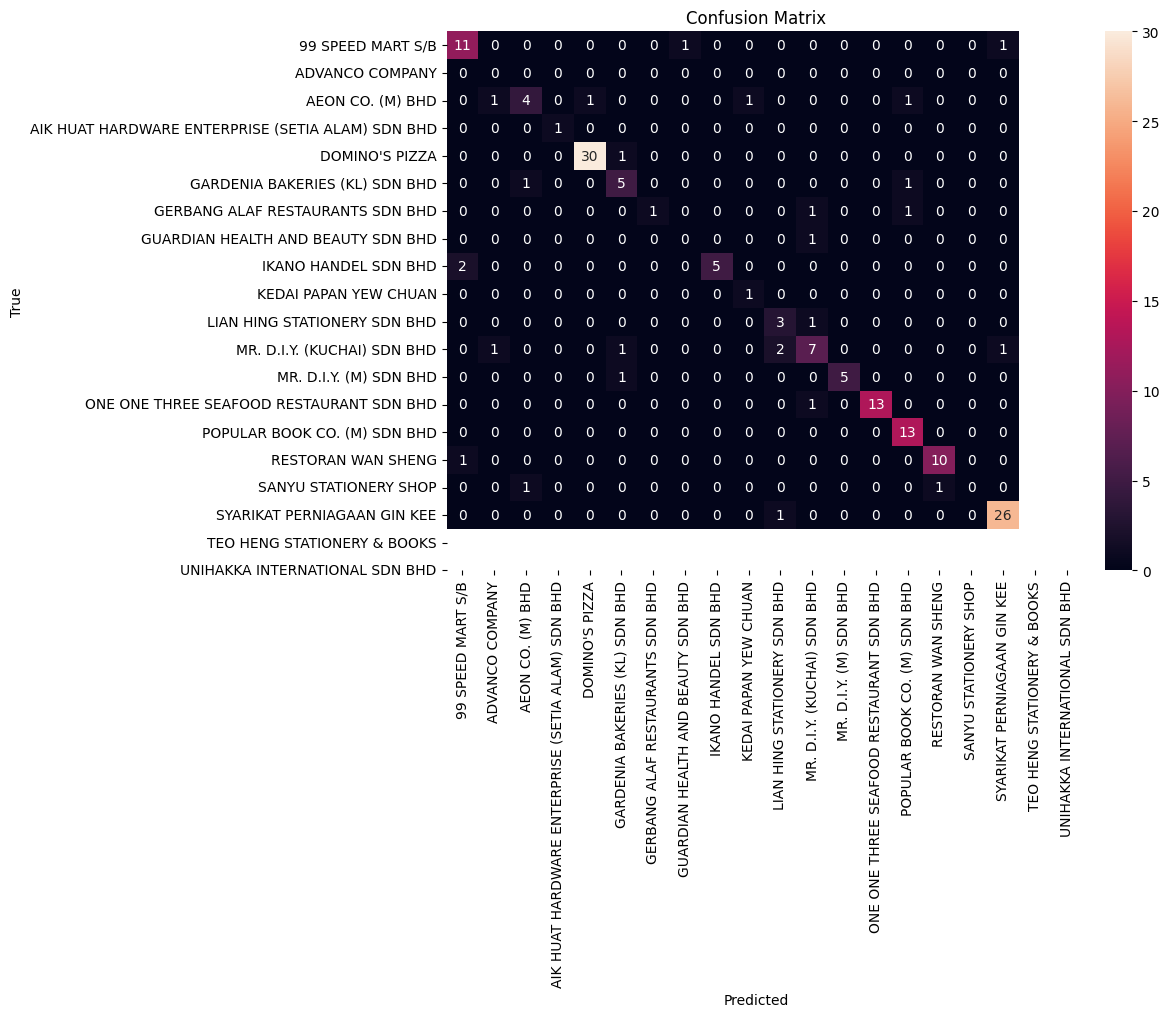

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Evaluate the KNN model on the test set
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy (KNN): {accuracy_knn * 100:.2f}%")

Test Accuracy (KNN): 55.28%


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 19.25%


In [ ]:
# Print predicted and actual company names
for actual, predicted in zip(y_test, y_pred):
    print(f"Actual: {actual}, Predicted: {predicted}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Actual: GERBANG ALAF RESTAURANTS SDN BHD, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: TEO HENG STATIONERY & BOOKS, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: TEO HENG STATIONERY & BOOKS, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: 99 SPEED MART S/B, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: 99 SPEED MART S/B, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: POPULAR BOOK CO. (M) SDN BHD, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: AEON CO. (M) BHD, Predicted: GARDENIA BAKERIES (KL) SDN BHD
Actual: POPULAR BOOK CO. (M) SDN BHD, Predicted: GARDENIA BAKE

In [ ]:
import numpy as np
import pandas as pd
from ripser import Rips

# Define a function to convert bounding box coordinates to points
def bounding_boxes_to_points(bounding_boxes):
    points = np.array(bounding_boxes).reshape(-1, 2)
    return points

# Define a function to compute persistence diagrams and extract features
def compute_persistence_features(data_list, epsilon=0.01):
    rips = Rips(maxdim=2)
    features = []

    for data in data_list:
        # Select only the top 20 bounding boxes
        top_20_data = data[:20]
        points = bounding_boxes_to_points(top_20_data)
        diagrams = rips.fit_transform(points)

        # Extract persistence diagrams
        h0 = diagrams[0]
        h1 = diagrams[1] if len(diagrams) > 1 else np.array([])
        h2 = diagrams[2] if len(diagrams) > 2 else np.array([])

        # Filter out points close to the diagonal
        h0 = h0[h0[:, 1] - h0[:, 0] > epsilon]
        h1 = h1[h1[:, 1] - h1[:, 0] > epsilon]
        h2 = h2[h2[:, 1] - h2[:, 0] > epsilon]

        # Summary statistics for H0
        h0_lifetimes = h0[:, 1] - h0[:, 0] if h0.size > 0 else np.array([0])
        h0_avg_lifetime = np.mean(h0_lifetimes)
        h0_num_points = len(h0_lifetimes)

        # Summary statistics for H1
        h1_lifetimes = h1[:, 1] - h1[:, 0] if h1.size > 0 else np.array([0])
        h1_avg_lifetime = np.mean(h1_lifetimes)
        h1_num_points = len(h1_lifetimes)

        # Summary statistics for H2
        h2_lifetimes = h2[:, 1] - h2[:, 0] if h2.size > 0 else np.array([0])
        h2_avg_lifetime = np.mean(h2_lifetimes)
        h2_num_points = len(h2_lifetimes)

        # Append features
        features.append([h0_avg_lifetime, h0_num_points, h1_avg_lifetime, h1_num_points, h2_avg_lifetime, h2_num_points])

    return np.array(features)

# Convert bounding box coordinates from string to list, select top 20, then compute features
raw_data_list = train_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_train = compute_persistence_features(raw_data_list)

# Convert the result to a DataFrame for better readability
X_train_df = pd.DataFrame(X_train, columns=['H0_Avg_Lifetime', 'H0_Num_Points', 'H1_Avg_Lifetime', 'H1_Num_Points', 'H2_Avg_Lifetime', 'H2_Num_Points'])

# Display the feature matrix
print(X_train_df)


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
     H0_Avg_Lifetime  H0_Num_Points  H1_Avg_Lifetime  H1_Num_Points  \
0                inf           80.0        16.543956           19.0   
1                inf           80.0        11.311696           18.0   
2                inf           80.0        19.302919           13.0   
3                inf           80.0        14.499431           20.0   
4                inf           80.0        12.936079           14.0   
..               ...            ...              ...            ...   
337              inf           80.0        13.069255           18.0   
338              inf           80.0        11.308675           19.0   
339              inf           80.0         5.138295           19.0   
340              inf           80.0        11.093472           21.0   
341              inf           80.0         9.620392           21.0   

     H2_Avg_Lifetime  H2_Num_Points  
0           0.188751     

In [ ]:
import numpy as np

# Check for infinite values in each column of the DataFrame
def check_for_infinite_values(df):
    # Create a dictionary to store the number of infinite values for each column
    infinite_counts = {}

    # Iterate over each column and check for infinite values
    for column in df.columns:
        # Count the number of infinite values in the column
        inf_count = np.sum(np.isinf(df[column].to_numpy()))
        infinite_counts[column] = inf_count

        # Print the result
        print(f"Column '{column}': {inf_count} infinite values found")

    return infinite_counts

# Apply the function to check for infinite values
infinite_counts = check_for_infinite_values(X_train_df)

# Optionally, display the DataFrame with the count of infinite values
print("\nCount of infinite values in each column:")
print(infinite_counts)


Column 'H0_Avg_Lifetime': 342 infinite values found
Column 'H0_Num_Points': 0 infinite values found
Column 'H1_Avg_Lifetime': 0 infinite values found
Column 'H1_Num_Points': 0 infinite values found
Column 'H2_Avg_Lifetime': 0 infinite values found
Column 'H2_Num_Points': 0 infinite values found

Count of infinite values in each column:
{'H0_Avg_Lifetime': 342, 'H0_Num_Points': 0, 'H1_Avg_Lifetime': 0, 'H1_Num_Points': 0, 'H2_Avg_Lifetime': 0, 'H2_Num_Points': 0}


In [ ]:
# Drop the 'H0_Avg_Lifetime' column from the feature matrix
X_train_df = X_train_df.drop(columns=['H0_Avg_Lifetime'])

# Prepare the target variable y_train
y_train = train_df_top20['Company Name']

# Perform label encoding for the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Convert the encoded y_train into a numpy array if needed
y_train_encoded = np.array(y_train_encoded)

# Display the updated training feature matrix and encoded target variable
print("Updated training feature matrix X_train_df:")
print(X_train_df)
print("\nEncoded target variable y_train_encoded:")
print(y_train_encoded)
print("\nLabel encoding mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Apply the function to the test data
raw_test_data_list = test_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_test = compute_persistence_features(raw_test_data_list)

# Convert the result to a DataFrame for better readability
X_test_df = pd.DataFrame(X_test, columns=['H0_Avg_Lifetime', 'H0_Num_Points', 'H1_Avg_Lifetime', 'H1_Num_Points', 'H2_Avg_Lifetime', 'H2_Num_Points'])

# Drop the 'H0_Avg_Lifetime' column from the feature matrix
X_test_df = X_test_df.drop(columns=['H0_Avg_Lifetime'])

# Prepare the target variable y_test
y_test = test_df_top20['Company Name']

# Perform label encoding for the target variable
y_test_encoded = label_encoder.transform(y_test)

# Convert the encoded y_test into a numpy array if needed
y_test_encoded = np.array(y_test_encoded)

# Display the updated test feature matrix and encoded target variable
print("\nUpdated test feature matrix X_test_df:")
print(X_test_df)
print("\nEncoded target variable y_test_encoded:")
print(y_test_encoded)

Updated training feature matrix X_train_df:
     H0_Num_Points  H1_Avg_Lifetime  H1_Num_Points  H2_Avg_Lifetime  \
0             80.0        16.543956           19.0         0.188751   
1             80.0        11.311696           18.0         0.000000   
2             80.0        19.302919           13.0         0.000000   
3             80.0        14.499431           20.0         1.684967   
4             80.0        12.936079           14.0         0.000000   
..             ...              ...            ...              ...   
337           80.0        13.069255           18.0         0.000000   
338           80.0        11.308675           19.0         0.000000   
339           80.0         5.138295           19.0         0.000000   
340           80.0        11.093472           21.0         0.000000   
341           80.0         9.620392           21.0         0.000000   

     H2_Num_Points  
0              1.0  
1              1.0  
2              1.0  
3              1.0 

In [ ]:
# Display the unique values in y_train_encoded
unique_labels_train = np.unique(y_train_encoded)
print(len(unique_labels_train))

20


In [ ]:
# Display the unique values in y_train_encoded
unique_labels_test = np.unique(y_test_encoded)
print(len(unique_labels_test))

17


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Instantiate the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_clf.fit(X_train_df, y_train_encoded)

# Predict on the test data
y_test_pred = rf_clf.predict(X_test_df)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_test_pred)
report = classification_report(y_test_encoded, y_test_pred)

# Print the results
print(f"Accuracy on test data: {accuracy:.2f}")
print("\nClassification Report:")
print(report)


Accuracy on test data: 0.56

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.62      0.53        13
           2       0.29      0.25      0.27         8
           3       0.33      1.00      0.50         1
           4       0.00      0.00      0.00         0
           5       0.72      0.68      0.70        31
           6       0.25      0.14      0.18         7
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         1
           9       0.38      0.43      0.40         7
          10       1.00      1.00      1.00         1
          11       0.00      0.00      0.00         4
          12       0.33      0.25      0.29        12
          13       0.00      0.00      0.00         0
          14       0.36      0.67      0.47         6
          15       1.00      1.00      1.00        14
          16       0.47      0.54      0.50        13
          17       0.60      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**All summary statistics in feature vector- only top 20 bbox per sample included**

In [ ]:
import numpy as np
import pandas as pd
from ripser import Rips

# Define a function to convert bounding box coordinates to points
def bounding_boxes_to_points(bounding_boxes):
    points = np.array(bounding_boxes).reshape(-1, 2)
    return points

# Define a function to compute persistence diagrams and extract features
def compute_persistence_features(data_list, epsilon=0.01):
    rips = Rips(maxdim=2)
    features = []

    for data in data_list:
        # Select only the top 20 bounding boxes
        top_20_data = data[:20]
        points = bounding_boxes_to_points(top_20_data)
        diagrams = rips.fit_transform(points)

        # Extract persistence diagrams
        h1 = diagrams[1] if len(diagrams) > 1 else np.array([])
        h2 = diagrams[2] if len(diagrams) > 2 else np.array([])

        # Filter out points close to the diagonal
        h1 = h1[h1[:, 1] - h1[:, 0] > epsilon]
        h2 = h2[h2[:, 1] - h2[:, 0] > epsilon]

        # Summary statistics for H1
        h1_lifetimes = h1[:, 1] - h1[:, 0] if h1.size > 0 else np.array([0])
        h1_avg_lifetime = np.mean(h1_lifetimes)
        h1_max_lifetime = np.max(h1_lifetimes) if h1_lifetimes.size > 0 else 0
        h1_sum_lifetime = np.sum(h1_lifetimes)
        h1_std_lifetime = np.std(h1_lifetimes)
        h1_num_points = len(h1_lifetimes)

        # Summary statistics for H2
        h2_lifetimes = h2[:, 1] - h2[:, 0] if h2.size > 0 else np.array([0])
        h2_avg_lifetime = np.mean(h2_lifetimes)
        h2_max_lifetime = np.max(h2_lifetimes) if h2_lifetimes.size > 0 else 0
        h2_sum_lifetime = np.sum(h2_lifetimes)
        h2_std_lifetime = np.std(h2_lifetimes)
        h2_num_points = len(h2_lifetimes)

        # Append features
        features.append([
            h1_avg_lifetime, h1_max_lifetime, h1_sum_lifetime, h1_std_lifetime, h1_num_points,
            h2_avg_lifetime, h2_max_lifetime, h2_sum_lifetime, h2_std_lifetime, h2_num_points
        ])

    return np.array(features)

# Convert bounding box coordinates from string to list, select top 20, then compute features
raw_data_list = train_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_train = compute_persistence_features(raw_data_list)

# Convert the result to a DataFrame for better readability
X_train_df = pd.DataFrame(X_train, columns=[
    'H1_Avg_Lifetime', 'H1_Max_Lifetime', 'H1_Sum_Lifetime', 'H1_Std_Lifetime', 'H1_Num_Points',
    'H2_Avg_Lifetime', 'H2_Max_Lifetime', 'H2_Sum_Lifetime', 'H2_Std_Lifetime', 'H2_Num_Points'
])

# Display the feature matrix
print(X_train_df)


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
     H1_Avg_Lifetime  H1_Max_Lifetime  H1_Sum_Lifetime  H1_Std_Lifetime  \
0          16.543956       123.320984       314.335171        26.253330   
1          11.311696        64.566711       203.610523        14.265392   
2          19.302919        91.421661       250.937950        24.520925   
3          14.499431       118.402206       289.988617        24.733588   
4          12.936079       100.912216       181.105110        25.141573   
..               ...              ...              ...              ...   
337        13.069255        44.348557       235.246582        11.905245   
338        11.308675        44.807632       214.864820        12.577017   
339         5.138295        21.063072        97.627611         4.618450   
340        11.093472        49.999893       232.962921        11.258572   
341         9.620392        44.867111       202.028236        11.361484   

     H1_Num_Poi

In [ ]:
# Prepare the target variable y_train
y_train = train_df_top20['Company Name']


#apply for y
# Convert bounding box coordinates from string to list, select top 20, then compute features
raw_data_list = test_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_test = compute_persistence_features(raw_data_list)

# Convert the result to a DataFrame for better readability
X_test_df = pd.DataFrame(X_test, columns=[
    'H1_Avg_Lifetime', 'H1_Max_Lifetime', 'H1_Sum_Lifetime', 'H1_Std_Lifetime', 'H1_Num_Points',
    'H2_Avg_Lifetime', 'H2_Max_Lifetime', 'H2_Sum_Lifetime', 'H2_Std_Lifetime', 'H2_Num_Points'
])

# Display the feature matrix
print(X_test_df)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
     H1_Avg_Lifetime  H1_Max_Lifetime  H1_Sum_Lifetime  H1_Std_Lifetime  \
0          24.399675       105.770645       292.796104        28.133350   
1          11.096567        86.976799       221.931334        18.283249   
2          13.934704       120.030212       250.824675        26.811167   
3           4.616414        27.018456       115.410346         5.399623   
4           4.450614        16.819862       124.617185         4.233823   
..               ...              ...              ...              ...   
156        10.439675       102.305298       334.069611        17.082072   
157        21.808663        85.005859       588.833893        23.683759   
158        22.878936        59.821655       388.941910        16.305751   
159        57.151911       213.824646       914.430573        55.641878   
160         5.211605        23.824692       104.232107         5.035229   

     H1_Num_Poi

In [ ]:
y_test = test_df_top20['Company Name']

In [ ]:
# Train a classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.71


In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model on scaled data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 60.87%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Evaluate the KNN model on the test set
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy (KNN): {accuracy_knn * 100:.2f}%")


Test Accuracy (KNN): 61.49%


In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode labels in training and testing sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize XGBoost model
xgb_model = XGBClassifier()

# Train the model with the encoded labels
xgb_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Test Accuracy (XGBoost): {accuracy_xgb * 100:.2f}%")


Test Accuracy (XGBoost): 68.94%


**All summary statistics in feature vector- 50 bbox included per sample**

In [ ]:
import numpy as np
import pandas as pd
from ripser import Rips

# Define a function to convert bounding box coordinates to points
def bounding_boxes_to_points(bounding_boxes):
    points = np.array(bounding_boxes).reshape(-1, 2)
    return points

# Define a function to compute persistence diagrams and extract features
def compute_persistence_features(data_list, epsilon=0.01):
    rips = Rips(maxdim=2)
    features = []

    for data in data_list:
        # Select only the top 50 bounding boxes
        top_50_data = data[:50]
        points = bounding_boxes_to_points(top_50_data)
        diagrams = rips.fit_transform(points)

        # Extract persistence diagrams
        h1 = diagrams[1] if len(diagrams) > 1 else np.array([])
        h2 = diagrams[2] if len(diagrams) > 2 else np.array([])

        # Filter out points close to the diagonal
        h1 = h1[h1[:, 1] - h1[:, 0] > epsilon]
        h2 = h2[h2[:, 1] - h2[:, 0] > epsilon]

        # Summary statistics for H1
        h1_lifetimes = h1[:, 1] - h1[:, 0] if h1.size > 0 else np.array([0])
        h1_avg_lifetime = np.mean(h1_lifetimes)
        h1_max_lifetime = np.max(h1_lifetimes) if h1_lifetimes.size > 0 else 0
        h1_sum_lifetime = np.sum(h1_lifetimes)
        h1_std_lifetime = np.std(h1_lifetimes)
        h1_num_points = len(h1_lifetimes)

        # Summary statistics for H2
        h2_lifetimes = h2[:, 1] - h2[:, 0] if h2.size > 0 else np.array([0])
        h2_avg_lifetime = np.mean(h2_lifetimes)
        h2_max_lifetime = np.max(h2_lifetimes) if h2_lifetimes.size > 0 else 0
        h2_sum_lifetime = np.sum(h2_lifetimes)
        h2_std_lifetime = np.std(h2_lifetimes)
        h2_num_points = len(h2_lifetimes)

        # Append features
        features.append([
            h1_avg_lifetime, h1_max_lifetime, h1_sum_lifetime, h1_std_lifetime, h1_num_points,
            h2_avg_lifetime, h2_max_lifetime, h2_sum_lifetime, h2_std_lifetime, h2_num_points
        ])

    return np.array(features)

# Convert bounding box coordinates from string to list, select top 20, then compute features
raw_data_list = train_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_train = compute_persistence_features(raw_data_list)

# Convert the result to a DataFrame for better readability
X_train_df = pd.DataFrame(X_train, columns=[
    'H1_Avg_Lifetime', 'H1_Max_Lifetime', 'H1_Sum_Lifetime', 'H1_Std_Lifetime', 'H1_Num_Points',
    'H2_Avg_Lifetime', 'H2_Max_Lifetime', 'H2_Sum_Lifetime', 'H2_Std_Lifetime', 'H2_Num_Points'
])

# Display the feature matrix
print(X_train_df)


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
     H1_Avg_Lifetime  H1_Max_Lifetime  H1_Sum_Lifetime  H1_Std_Lifetime  \
0          18.143340       258.512726      1197.460445        35.106754   
1          13.502391        81.036469      1012.679333        15.752357   
2          18.638784        95.368469       615.079872        25.159576   
3          12.633334       118.402206       871.700058        19.620193   
4          14.660031       155.766846       674.361423        27.913659   
..               ...              ...              ...              ...   
337        13.936339       139.801285       919.798344        20.027348   
338        12.239171       137.869576       930.177025        18.875732   
339         6.560330        75.570496       328.016518        11.181378   
340        13.959362       109.315468       823.602367        17.442620   
341         8.678006        47.242004       807.054518         9.471211   

     H1_Num_Poi

In [ ]:
# Prepare the target variable y_train
y_train = train_df_top20['Company Name']


#apply for y
# Convert bounding box coordinates from string to list, select top 20, then compute features
raw_data_list = test_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_test = compute_persistence_features(raw_data_list)

# Convert the result to a DataFrame for better readability
X_test_df = pd.DataFrame(X_test, columns=[
    'H1_Avg_Lifetime', 'H1_Max_Lifetime', 'H1_Sum_Lifetime', 'H1_Std_Lifetime', 'H1_Num_Points',
    'H2_Avg_Lifetime', 'H2_Max_Lifetime', 'H2_Sum_Lifetime', 'H2_Std_Lifetime', 'H2_Num_Points'
])

# Display the feature matrix
print(X_test_df)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
     H1_Avg_Lifetime  H1_Max_Lifetime  H1_Sum_Lifetime  H1_Std_Lifetime  \
0          19.447407       105.770645       680.659233        24.925367   
1          12.421112       157.902878       720.424520        23.751011   
2          16.882912       245.567215      1080.506369        34.661794   
3           6.124815        47.738037       232.742984        10.103768   
4           6.366985        49.958954       254.679402         9.456707   
..               ...              ...              ...              ...   
156        11.427632       102.305298      1028.486849        16.228213   
157        27.957253       174.760132      1313.990898        35.319563   
158        28.160666       265.778595      1689.639931        42.376510   
159        43.651005       213.824646      1134.926132        49.857637   
160         6.812768        58.389465       415.578859         8.486793   

     H1_Num_Poi

In [ ]:
# Train a classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.76


In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model on scaled data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 70.81%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Evaluate the KNN model on the test set
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy (KNN): {accuracy_knn * 100:.2f}%")


Test Accuracy (KNN): 63.98%


In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode labels in training and testing sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize XGBoost model
xgb_model = XGBClassifier()

# Train the model with the encoded labels
xgb_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Test Accuracy (XGBoost): {accuracy_xgb * 100:.2f}%")


Test Accuracy (XGBoost): 75.16%


Classification Report:
                                                   precision    recall  f1-score   support

                                99 SPEED MART S/B       0.65      0.85      0.73        13
                                 AEON CO. (M) BHD       0.60      0.38      0.46         8
AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD       0.00      0.00      0.00         1
                                   DOMINO'S PIZZA       0.00      0.00      0.00         0
                   GARDENIA BAKERIES (KL) SDN BHD       0.97      1.00      0.98        31
                 GERBANG ALAF RESTAURANTS SDN BHD       1.00      0.43      0.60         7
               GUARDIAN HEALTH AND BEAUTY SDN BHD       0.00      0.00      0.00         3
                             IKANO HANDEL SDN BHD       0.00      0.00      0.00         1
                            KEDAI PAPAN YEW CHUAN       1.00      0.43      0.60         7
                     LIAN HING STATIONERY SDN BHD       0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

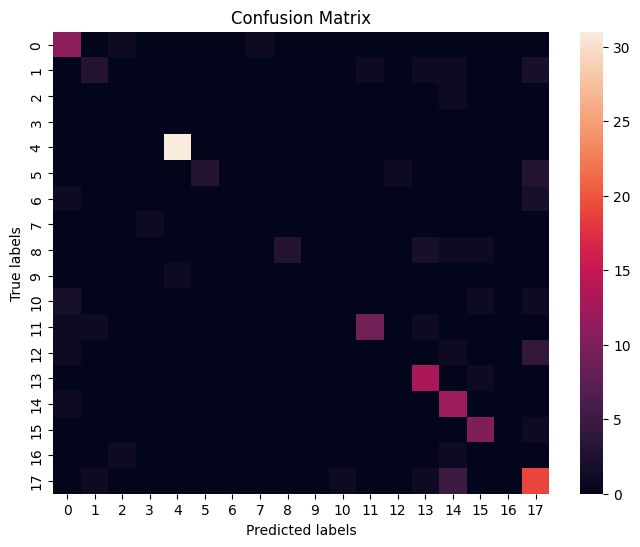

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have actual labels in 'actual_labels' and predicted labels in 'predicted_labels'
actual_labels = y_test
predicted_labels = y_pred

# Generate and print the classification report
print("Classification Report:")
print(classification_report(actual_labels, predicted_labels))

# Generate and print the confusion matrix
conf_matrix=confusion_matrix(actual_labels, predicted_labels)
print("\nConfusion Matrix:")
print(confusion_matrix(actual_labels, predicted_labels))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you already have your confusion matrix stored in conf_matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**All summary statistics in feature vector- 100 bbox included per sample**

In [ ]:
import numpy as np
import pandas as pd
from ripser import Rips

# Define a function to convert bounding box coordinates to points
def bounding_boxes_to_points(bounding_boxes):
    points = np.array(bounding_boxes).reshape(-1, 2)
    return points

# Define a function to compute persistence diagrams and extract features
def compute_persistence_features(data_list, epsilon=0.01):
    rips = Rips(maxdim=2)
    features = []

    for data in data_list:
        # Select only the top 100 bounding boxes
        top_100_data = data[:100]
        points = bounding_boxes_to_points(top_100_data)
        diagrams = rips.fit_transform(points)

        # Extract persistence diagrams
        h1 = diagrams[1] if len(diagrams) > 1 else np.array([])
        h2 = diagrams[2] if len(diagrams) > 2 else np.array([])

        # Filter out points close to the diagonal
        h1 = h1[h1[:, 1] - h1[:, 0] > epsilon]
        h2 = h2[h2[:, 1] - h2[:, 0] > epsilon]

        # Summary statistics for H1
        h1_lifetimes = h1[:, 1] - h1[:, 0] if h1.size > 0 else np.array([0])
        h1_avg_lifetime = np.mean(h1_lifetimes)
        h1_max_lifetime = np.max(h1_lifetimes) if h1_lifetimes.size > 0 else 0
        h1_sum_lifetime = np.sum(h1_lifetimes)
        h1_std_lifetime = np.std(h1_lifetimes)
        h1_num_points = len(h1_lifetimes)

        # Summary statistics for H2
        h2_lifetimes = h2[:, 1] - h2[:, 0] if h2.size > 0 else np.array([0])
        h2_avg_lifetime = np.mean(h2_lifetimes)
        h2_max_lifetime = np.max(h2_lifetimes) if h2_lifetimes.size > 0 else 0
        h2_sum_lifetime = np.sum(h2_lifetimes)
        h2_std_lifetime = np.std(h2_lifetimes)
        h2_num_points = len(h2_lifetimes)

        # Append features
        features.append([
            h1_avg_lifetime, h1_max_lifetime, h1_sum_lifetime, h1_std_lifetime, h1_num_points,
            h2_avg_lifetime, h2_max_lifetime, h2_sum_lifetime, h2_std_lifetime, h2_num_points
        ])

    return np.array(features)

# Convert bounding box coordinates from string to list, select top 20, then compute features
raw_data_list = train_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_train = compute_persistence_features(raw_data_list)

# Convert the result to a DataFrame for better readability
X_train_df = pd.DataFrame(X_train, columns=[
    'H1_Avg_Lifetime', 'H1_Max_Lifetime', 'H1_Sum_Lifetime', 'H1_Std_Lifetime', 'H1_Num_Points',
    'H2_Avg_Lifetime', 'H2_Max_Lifetime', 'H2_Sum_Lifetime', 'H2_Std_Lifetime', 'H2_Num_Points'
])

# Display the feature matrix
print(X_train_df)


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
     H1_Avg_Lifetime  H1_Max_Lifetime  H1_Sum_Lifetime  H1_Std_Lifetime  \
0          14.248288       137.742676      1424.828772        21.454516   
1          15.596980       131.014847      1544.100998        21.825169   
2          18.638784        95.368469       615.079872        25.159576   
3          14.053863       138.765381      1166.470596        22.885144   
4          14.794796       155.766846       754.534580        26.679804   
..               ...              ...              ...              ...   
337        13.782542       139.801285       937.212841        19.771909   
338        12.927487       140.416328      1111.763874        19.115936   
339         6.560330        75.570496       328.016518        11.181378   
340        13.959362       109.315468       823.602367        17.442620   
341        10.510296        92.952087      1114.091330        13.412003   

     H1_Num_Poi

In [ ]:
# Prepare the target variable y_train
y_train = train_df_top20['Company Name']


#apply for y
# Convert bounding box coordinates from string to list, select top 20, then compute features
raw_data_list = test_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_test = compute_persistence_features(raw_data_list)

# Convert the result to a DataFrame for better readability
X_test_df = pd.DataFrame(X_test, columns=[
    'H1_Avg_Lifetime', 'H1_Max_Lifetime', 'H1_Sum_Lifetime', 'H1_Std_Lifetime', 'H1_Num_Points',
    'H2_Avg_Lifetime', 'H2_Max_Lifetime', 'H2_Sum_Lifetime', 'H2_Std_Lifetime', 'H2_Num_Points'
])

# Display the feature matrix
print(X_test_df)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
     H1_Avg_Lifetime  H1_Max_Lifetime  H1_Sum_Lifetime  H1_Std_Lifetime  \
0          19.447407       105.770645       680.659233        24.925367   
1           9.988994        86.976799       839.075533        15.534773   
2          13.825660       147.718262      1175.181129        24.099443   
3           6.124815        47.738037       232.742984        10.103768   
4           6.366985        49.958954       254.679402         9.456707   
..               ...              ...              ...              ...   
156        12.039612       102.305298      1107.644281        17.788002   
157        27.957253       174.760132      1313.990898        35.319563   
158        28.160666       265.778595      1689.639931        42.376510   
159        43.651005       213.824646      1134.926132        49.857637   
160         6.812768        58.389465       415.578859         8.486793   

     H1_Num_Poi

In [ ]:
# Train a classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

ValueError: Found input variables with inconsistent numbers of samples: [252, 161]

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model on scaled data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Evaluate the KNN model on the test set
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy (KNN): {accuracy_knn * 100:.2f}%")


Test Accuracy (KNN): 60.87%


In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode labels in training and testing sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize XGBoost model
xgb_model = XGBClassifier()

# Train the model with the encoded labels
xgb_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Test Accuracy (XGBoost): {accuracy_xgb * 100:.2f}%")


Test Accuracy (XGBoost): 78.26%


All summary statistics in feature vector- full bbox included per sample

In [ ]:
import numpy as np
import pandas as pd
from ripser import Rips

# Define a function to convert bounding box coordinates to points
def bounding_boxes_to_points(bounding_boxes):
    points = np.array(bounding_boxes).reshape(-1, 2)
    return points

# Define a function to compute persistence diagrams and extract features
def compute_persistence_features(data_list, epsilon=0.01):
    rips = Rips(maxdim=2)
    features = []

    for data in data_list:
        # Select only the top 100 bounding boxes
        # top_100_data = data[:100]
        points = bounding_boxes_to_points(data)
        diagrams = rips.fit_transform(points)

        # Extract persistence diagrams
        h1 = diagrams[1] if len(diagrams) > 1 else np.array([])
        h2 = diagrams[2] if len(diagrams) > 2 else np.array([])

        # Filter out points close to the diagonal
        h1 = h1[h1[:, 1] - h1[:, 0] > epsilon]
        h2 = h2[h2[:, 1] - h2[:, 0] > epsilon]

        # Summary statistics for H1
        h1_lifetimes = h1[:, 1] - h1[:, 0] if h1.size > 0 else np.array([0])
        h1_avg_lifetime = np.mean(h1_lifetimes)
        h1_max_lifetime = np.max(h1_lifetimes) if h1_lifetimes.size > 0 else 0
        h1_sum_lifetime = np.sum(h1_lifetimes)
        h1_std_lifetime = np.std(h1_lifetimes)
        h1_num_points = len(h1_lifetimes)

        # Summary statistics for H2
        h2_lifetimes = h2[:, 1] - h2[:, 0] if h2.size > 0 else np.array([0])
        h2_avg_lifetime = np.mean(h2_lifetimes)
        h2_max_lifetime = np.max(h2_lifetimes) if h2_lifetimes.size > 0 else 0
        h2_sum_lifetime = np.sum(h2_lifetimes)
        h2_std_lifetime = np.std(h2_lifetimes)
        h2_num_points = len(h2_lifetimes)

        # Append features
        features.append([
            h1_avg_lifetime, h1_max_lifetime, h1_sum_lifetime, h1_std_lifetime, h1_num_points,
            h2_avg_lifetime, h2_max_lifetime, h2_sum_lifetime, h2_std_lifetime, h2_num_points
        ])

    return np.array(features)

# Convert bounding box coordinates from string to list, select top 20, then compute features
raw_data_list = train_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_train = compute_persistence_features(raw_data_list)

# Convert the result to a DataFrame for better readability
X_train_df = pd.DataFrame(X_train, columns=[
    'H1_Avg_Lifetime', 'H1_Max_Lifetime', 'H1_Sum_Lifetime', 'H1_Std_Lifetime', 'H1_Num_Points',
    'H2_Avg_Lifetime', 'H2_Max_Lifetime', 'H2_Sum_Lifetime', 'H2_Std_Lifetime', 'H2_Num_Points'
])

# Display the feature matrix
print(X_train_df)


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
     H1_Avg_Lifetime  H1_Max_Lifetime  H1_Sum_Lifetime  H1_Std_Lifetime  \
0          14.248288       137.742676      1424.828772        21.454516   
1          15.596980       131.014847      1544.100998        21.825169   
2          18.638784        95.368469       615.079872        25.159576   
3          14.053863       138.765381      1166.470596        22.885144   
4          14.794796       155.766846       754.534580        26.679804   
..               ...              ...              ...              ...   
337        13.782542       139.801285       937.212841        19.771909   
338        12.927487       140.416328      1111.763874        19.115936   
339         6.560330        75.570496       328.016518        11.181378   
340        13.959362       109.315468       823.602367        17.442620   
341        10.510296        92.952087      1114.091330        13.412003   

     H1_Num_Poi

In [ ]:
# Prepare the target variable y_train
y_train = train_df_top20['Company Name']


#apply for y
# Convert bounding box coordinates from string to list, select top 20, then compute features
raw_data_list = test_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_test = compute_persistence_features(raw_data_list)

# Convert the result to a DataFrame for better readability
X_test_df = pd.DataFrame(X_test, columns=[
    'H1_Avg_Lifetime', 'H1_Max_Lifetime', 'H1_Sum_Lifetime', 'H1_Std_Lifetime', 'H1_Num_Points',
    'H2_Avg_Lifetime', 'H2_Max_Lifetime', 'H2_Sum_Lifetime', 'H2_Std_Lifetime', 'H2_Num_Points'
])

# Display the feature matrix
print(X_test_df)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
     H1_Avg_Lifetime  H1_Max_Lifetime  H1_Sum_Lifetime  H1_Std_Lifetime  \
0          19.447407       105.770645       680.659233        24.925367   
1           9.988994        86.976799       839.075533        15.534773   
2          13.825660       147.718262      1175.181129        24.099443   
3           6.124815        47.738037       232.742984        10.103768   
4           6.366985        49.958954       254.679402         9.456707   
..               ...              ...              ...              ...   
156        12.039612       102.305298      1107.644281        17.788002   
157        27.957253       174.760132      1313.990898        35.319563   
158        28.160666       265.778595      1689.639931        42.376510   
159        43.651005       213.824646      1134.926132        49.857637   
160         6.812768        58.389465       415.578859         8.486793   

     H1_Num_Poi

In [ ]:
# Train a classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.80


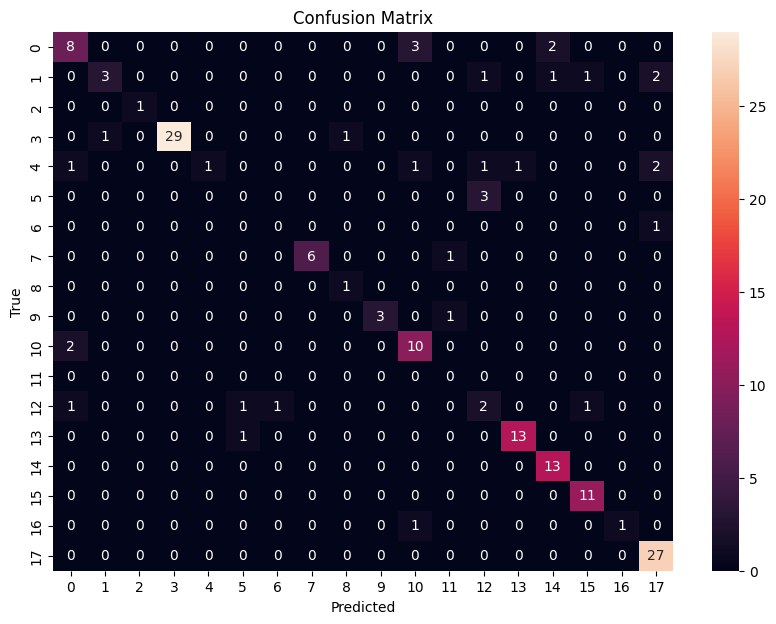

Accuracy: 0.80


In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model on scaled data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 72.05%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Evaluate the KNN model on the test set
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy (KNN): {accuracy_knn * 100:.2f}%")


Test Accuracy (KNN): 61.49%


In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode labels in training and testing sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize XGBoost model
xgb_model = XGBClassifier()

# Train the model with the encoded labels
xgb_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Test Accuracy (XGBoost): {accuracy_xgb * 100:.2f}%")


Test Accuracy (XGBoost): 78.88%


**TDA h1 and h2 features- No summary statistics**

In [70]:
import numpy as np
import pandas as pd
from ripser import Rips
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define a function to convert bounding box coordinates to points
def bounding_boxes_to_points(bounding_boxes):
    points = np.array(bounding_boxes).reshape(-1, 2)
    return points

# Define a function to compute persistence diagrams and extract features
def compute_persistence_features(data_list, epsilon=0.01):
    rips = Rips(maxdim=2)
    features = []

    for data in data_list:
        # Select only the top 100 bounding boxes
        # top_100_data = data[:100]
        points = bounding_boxes_to_points(data)
        diagrams = rips.fit_transform(points)

        # Extract persistence diagrams
        h1 = diagrams[1] if len(diagrams) > 1 else np.array([])
        h2 = diagrams[2] if len(diagrams) > 2 else np.array([])

        # Filter out points close to the diagonal
        h1 = h1[h1[:, 1] - h1[:, 0] > epsilon]
        h2 = h2[h2[:, 1] - h2[:, 0] > epsilon]

        # Flatten h1 and h2 arrays for the feature vector
        h1_flat = h1.flatten() if h1.size > 0 else np.array([0])
        h2_flat = h2.flatten() if h2.size > 0 else np.array([0])

        # Append features
        features.append(np.concatenate((h1_flat, h2_flat)))

    return features

# Compute features for train and test datasets
raw_data_list_train = train_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_train_features = compute_persistence_features(raw_data_list_train)

raw_data_list_test = test_df_top20['Bounding Box Coordinates'].apply(eval).tolist()
X_test_features = compute_persistence_features(raw_data_list_test)

# Determine the maximum length of the feature vectors
max_length = max(max(len(f) for f in X_train_features), max(len(f) for f in X_test_features))

# Pad the feature vectors with zeros to ensure uniform length
X_train = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in X_train_features])
X_test = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in X_test_features])

# Convert the results to DataFrames for better readability
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

# Display the feature matrices
print(X_train_df)
print(X_test_df)



Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
            0           1           2           3           4           5    \
0    269.475403  320.551086  257.279999  265.843933  250.241882  252.301407   
1    256.017578  313.847107  248.163254  251.366272  245.489304  250.936249   
2    181.796585  182.002747  169.578888  196.290604  165.894547  198.252365   
3    275.181763  322.133514  252.198334  260.754669  247.129517  249.064255   
4    222.182358  250.569351  212.934265  215.000000  207.241409  230.930725   
..          ...         ...         ...         ...         ...         ...   
337  167.000000  171.493439  167.000000  204.384445  137.640839  144.616730   
338  167.000000  170.425934  164.000000  168.344879  164.000000  202.474686   
339  118.105888  139.168961  114.000000  116.498924  100.000000  102.181213   
340  163.000000  169.097610  163.000000  2

In [71]:
X_train_df.shape

(342, 463)

In [72]:
X_test_df.shape

(161, 463)

In [73]:
# Prepare the target variables
y_train = train_df_top20['Company Name']
y_test = test_df_top20['Company Name']

Random Forest

In [ ]:


# Train a classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_df, y_train)

# Make predictions
y_pred = model.predict(X_test_df)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.83


Random Forest- Gridsearch CV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_df, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Train a classification model using the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_df, y_train)

# Make predictions
y_pred = best_model.predict(X_test_df)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Score: 0.7779624893435635
Accuracy: 0.81


Logistic regression- GridsearchCV

In [ ]:
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Create a GridSearchCV object for Logistic Regression
grid_search_lr = GridSearchCV(estimator=LogisticRegression(random_state=42),
                              param_grid=param_grid_lr,
                              cv=5,
                              n_jobs=-1,
                              verbose=2)

# Fit the GridSearchCV object to the data
grid_search_lr.fit(X_train_df, y_train)

# Print the best parameters and the best score
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best Cross-Validation Score for Logistic Regression:", grid_search_lr.best_score_)

# Train a Logistic Regression model using the best parameters
best_lr_model = grid_search_lr.best_estimator_
best_lr_model.fit(X_train_df, y_train)

# Make predictions
y_pred_lr = best_lr_model.predict(X_test_df)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Accuracy for Logistic Regression: {accuracy_lr:.2f}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score for Logistic Regression: 0.63154305200341
Accuracy for Logistic Regression: 0.67


KNN- Grid search CV

In [ ]:
# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create a GridSearchCV object for KNN
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=param_grid_knn,
                               cv=5,
                               n_jobs=-1,
                               verbose=2)

# Fit the GridSearchCV object to the data
grid_search_knn.fit(X_train_df, y_train)

# Print the best parameters and the best score
print("Best Parameters for KNN:", grid_search_knn.best_params_)
print("Best Cross-Validation Score for KNN:", grid_search_knn.best_score_)

# Train a KNN model using the best parameters
best_knn_model = grid_search_knn.best_estimator_
best_knn_model.fit(X_train_df, y_train)

# Make predictions
y_pred_knn = best_knn_model.predict(X_test_df)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy for KNN: {accuracy_knn:.2f}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validation Score for KNN: 0.7163256606990622
Accuracy for KNN: 0.76


XGboost- GridsearchCV

In [ ]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode the target variables
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define the XGBoost model with specific hyperparameters
xgb_model = XGBClassifier(
    n_estimators=100,  # You can set this to any desired value
    max_depth=6,       # You can adjust this based on your data
    learning_rate=0.1, # You can set the learning rate as needed
    subsample=0.8,     # Adjust the subsample ratio
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the XGBoost model
xgb_model.fit(X_train_df, y_train_encoded)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_df)

# Evaluate the model accuracy on the test set
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f'Accuracy for XGBoost: {accuracy_xgb:.2f}')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:45:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for XGBoost: 0.85


In [ ]:
from sklearn.model_selection import GridSearchCV

# Encode the target variables
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

# Create a GridSearchCV object for XGBoost
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                               param_grid=param_grid_xgb,
                               cv=5,
                               n_jobs=-1,
                               verbose=2)

# Fit the GridSearchCV object to the data
grid_search_xgb.fit(X_train_df, y_train_encoded)

# Print the best parameters and the best score
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best Cross-Validation Score for XGBoost:", grid_search_xgb.best_score_)

# Train an XGBoost model using the best parameters
best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_model.fit(X_train_df, y_train_encoded)

# Make predictions
y_pred_xgb_model2 = best_xgb_model.predict(X_test_df)

# Evaluate the model
accuracy_xgb_model2 = accuracy_score(y_test_encoded, y_pred_xgb_model2)
print(f'Accuracy for XGBoost: {accuracy_xgb:.2f}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:12:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Score for XGBoost: 0.7633844842284739


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:12:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for XGBoost: 0.95


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Accuracy for Model 1 (XGBoost with GridSearchCV)
accuracy_model_1 = accuracy_score(y_test_encoded, y_pred_xgb)
print(f'Accuracy for Model 1: {accuracy_model_1:.2f}')

# Accuracy for Model 2 (Baseline XGBoost)
accuracy_model_2 = accuracy_score(y_test_encoded, y_pred_xgb_model2)
print(f'Accuracy for Model 2: {accuracy_model_2:.2f}')

# Calculate precision, recall, and F1-score for Model 1
precision_model_1 = precision_score(y_test_encoded, y_pred_xgb, average='weighted')
recall_model_1 = recall_score(y_test_encoded, y_pred_xgb, average='weighted')
f1_model_1 = f1_score(y_test_encoded, y_pred_xgb, average='weighted')

# Calculate precision, recall, and F1-score for Model 2
precision_model_2 = precision_score(y_test_encoded, y_pred_xgb_model2, average='weighted')
recall_model_2 = recall_score(y_test_encoded, y_pred_xgb_model2, average='weighted')
f1_model_2 = f1_score(y_test_encoded, y_pred_xgb_model2, average='weighted')

# Print out the metrics for both models
print(f'Model 1 - Precision: {precision_model_1:.2f}, Recall: {recall_model_1:.2f}, F1-Score: {f1_model_1:.2f}')
print(f'Model 2 - Precision: {precision_model_2:.2f}, Recall: {recall_model_2:.2f}, F1-Score: {f1_model_2:.2f}')

# Confusion Matrix for both models
cm_model_1 = confusion_matrix(y_test_encoded, y_pred_xgb)
cm_model_2 = confusion_matrix(y_test_encoded, y_pred_xgb_model2)

print("Confusion Matrix for Model 1:\n", cm_model_1)
print("Confusion Matrix for Model 2:\n", cm_model_2)

# Classification Report for detailed metrics
print("Classification Report for Model 1:\n", classification_report(y_test_encoded, y_pred_xgb))
print("Classification Report for Model 2:\n", classification_report(y_test_encoded, y_pred_xgb_model2))

# Identifying the differences
differences = (y_pred_xgb_model2!=y_pred_xgb)
model_2_better_idx = (differences & (y_pred_xgb_model2 == y_test_encoded))

# Show examples where Model 1 outperformed Model 2
better_cases = X_test_df[model_2_better_idx]
better_predictions = y_pred_xgb_model2[model_2_better_idx]

print("Examples where TDA is better than Baseline:")
for i, idx in enumerate(better_cases.index):
    print(f"Example {i+1}:")
    print(f"Input Features: {better_cases.loc[idx]}")
    print(f"Model 2 Prediction: {better_predictions[i]}")
    print(f"True Label: {y_test_encoded[idx]}")
    print()


Accuracy for Model 1: 0.95
Accuracy for Model 2: 0.84
Model 1 - Precision: 0.95, Recall: 0.95, F1-Score: 0.95
Model 2 - Precision: 0.84, Recall: 0.84, F1-Score: 0.83
Confusion Matrix for Model 1:
 [[13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  1  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 11 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precis

In [ ]:
X_test_baseline

array([[5.14600e+03, 2.85500e+02, 1.36000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.26540e+04, 1.02100e+03, 3.38500e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.93680e+04, 4.82000e+02, 2.94000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.05456e+05, 2.50200e+03, 1.62400e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.45318e+05, 2.31500e+03, 1.81450e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.78400e+03, 6.80000e+01, 3.30000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Accuracy for Baseline (Model 1)
accuracy_baseline = accuracy_score(y_test_encoded, y_pred_xgb)
print(f'Accuracy for Baseline: {accuracy_baseline:.2f}')

# Accuracy for TDA (Model 2)
accuracy_tda = accuracy_score(y_test_encoded, y_pred_xgb_model2)
print(f'Accuracy for TDA: {accuracy_tda:.2f}')

# Calculate precision, recall, and F1-score for Baseline (Model 1)
precision_baseline = precision_score(y_test_encoded, y_pred_xgb, average='weighted')
recall_baseline = recall_score(y_test_encoded, y_pred_xgb, average='weighted')
f1_baseline = f1_score(y_test_encoded, y_pred_xgb, average='weighted')

# Calculate precision, recall, and F1-score for TDA (Model 2)
precision_tda = precision_score(y_test_encoded, y_pred_xgb_model2, average='weighted')
recall_tda = recall_score(y_test_encoded, y_pred_xgb_model2, average='weighted')
f1_tda = f1_score(y_test_encoded, y_pred_xgb_model2, average='weighted')

# Print out the metrics for both models
print(f'Baseline - Precision: {precision_baseline:.2f}, Recall: {recall_baseline:.2f}, F1-Score: {f1_baseline:.2f}')
print(f'TDA - Precision: {precision_tda:.2f}, Recall: {recall_tda:.2f}, F1-Score: {f1_tda:.2f}')

# Confusion Matrix for both models
cm_baseline = confusion_matrix(y_test_encoded, y_pred_xgb)
cm_tda = confusion_matrix(y_test_encoded, y_pred_xgb_model2)

print("Confusion Matrix for Baseline:\n", cm_baseline)
print("Confusion Matrix for TDA:\n", cm_tda)

# Classification Report for detailed metrics
print("Classification Report for Baseline:\n", classification_report(y_test_encoded, y_pred_xgb))
print("Classification Report for TDA:\n", classification_report(y_test_encoded, y_pred_xgb_model2))

# Identifying the differences
differences = (y_pred_xgb_model2 != y_pred_xgb)
tda_better_idx = (differences & (y_pred_xgb_model2 == y_test_encoded))

# Show examples where TDA outperformed Baseline
better_cases = X_test_df[tda_better_idx]
baseline_predictions = y_pred_xgb[tda_better_idx]
tda_predictions = y_pred_xgb_model2[tda_better_idx]
true_labels = y_test_encoded[tda_better_idx]

# Decode the class labels for better readability
decoded_baseline_predictions = label_encoder.inverse_transform(baseline_predictions)
decoded_tda_predictions = label_encoder.inverse_transform(tda_predictions)
decoded_true_labels = label_encoder.inverse_transform(true_labels)

print("Examples where TDA is better than Baseline:")
for i, idx in enumerate(better_cases.index):
    print(f"Example {i+1}:")
    print(f"Input Features: {better_cases.loc[idx]}")
    print(f"Baseline Prediction: {decoded_baseline_predictions[i]}")
    print(f"TDA Prediction: {decoded_tda_predictions[i]}")
    print(f"True Label: {decoded_true_labels[i]}")
    print()


Accuracy for Baseline: 0.95
Accuracy for TDA: 0.84
Baseline - Precision: 0.95, Recall: 0.95, F1-Score: 0.95
TDA - Precision: 0.84, Recall: 0.84, F1-Score: 0.83
Confusion Matrix for Baseline:
 [[13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  1  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precis

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


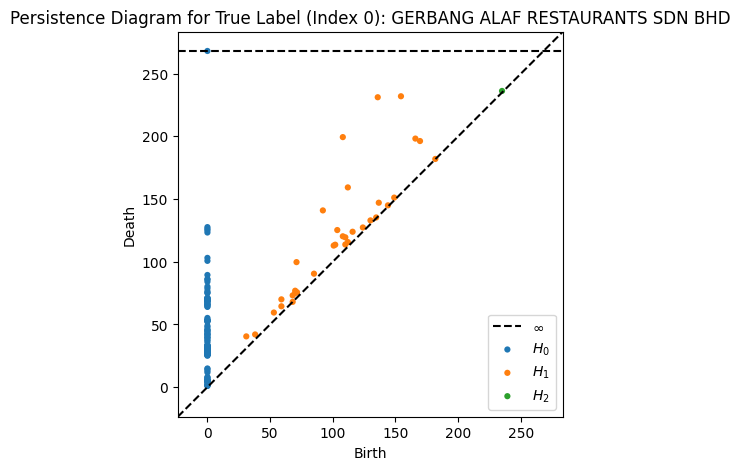

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


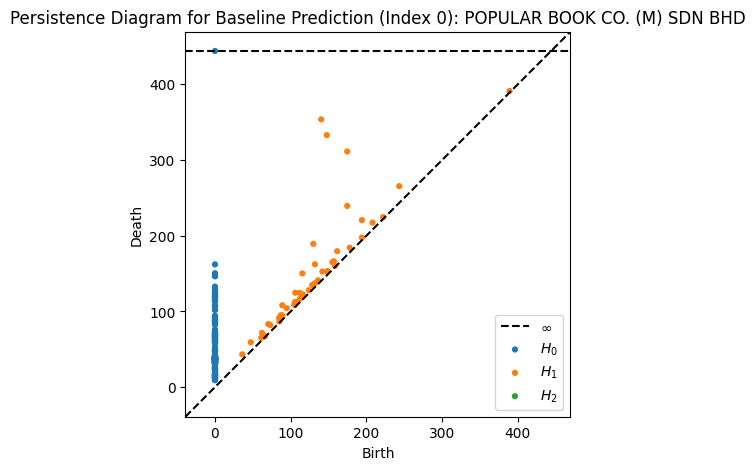

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


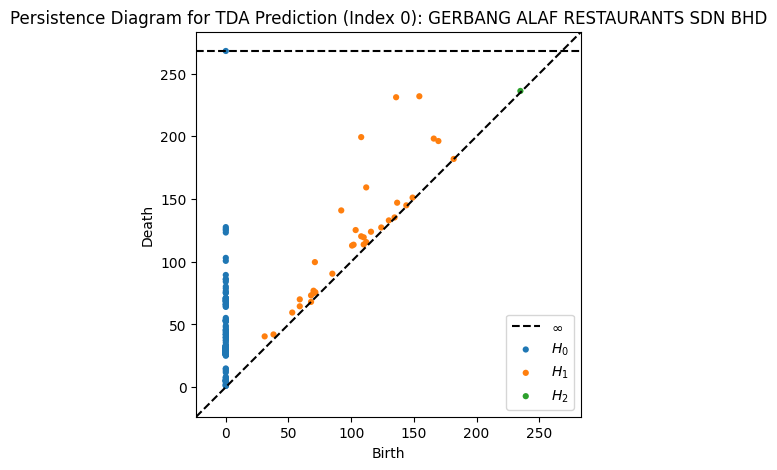

Index 0:
True Label: GERBANG ALAF RESTAURANTS SDN BHD
Baseline Prediction: POPULAR BOOK CO. (M) SDN BHD
TDA Prediction: GERBANG ALAF RESTAURANTS SDN BHD

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


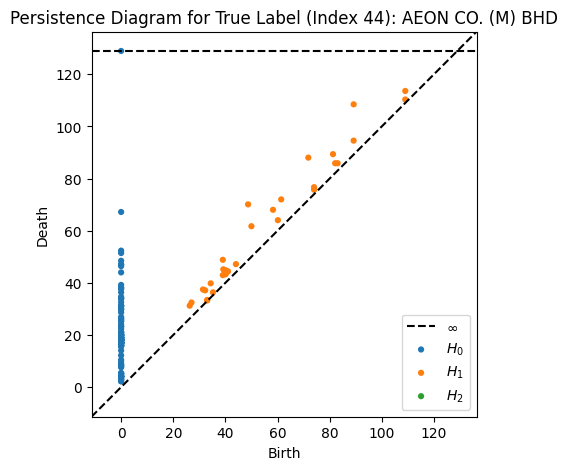

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


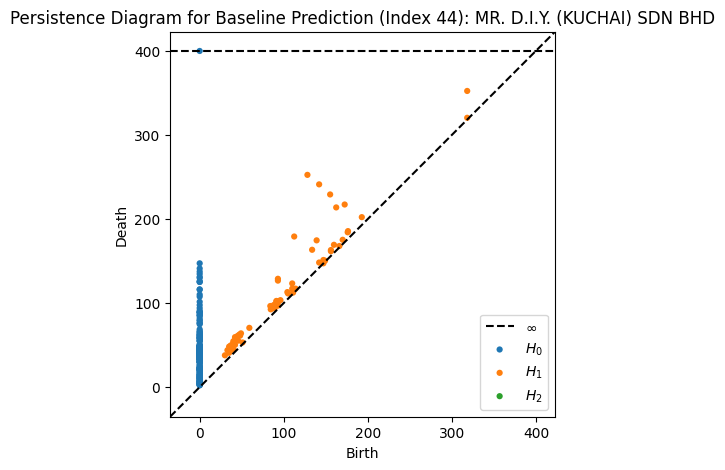

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


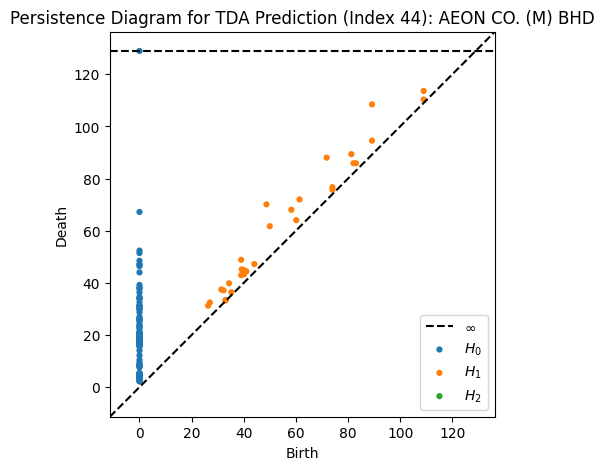

Index 44:
True Label: AEON CO. (M) BHD
Baseline Prediction: MR. D.I.Y. (KUCHAI) SDN BHD
TDA Prediction: AEON CO. (M) BHD

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


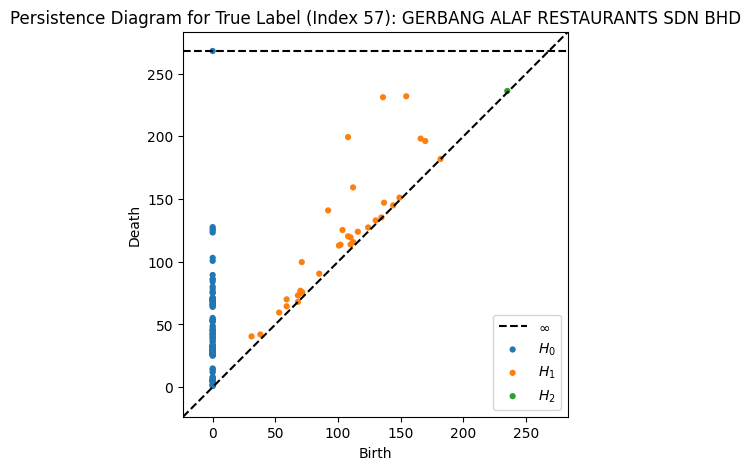

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


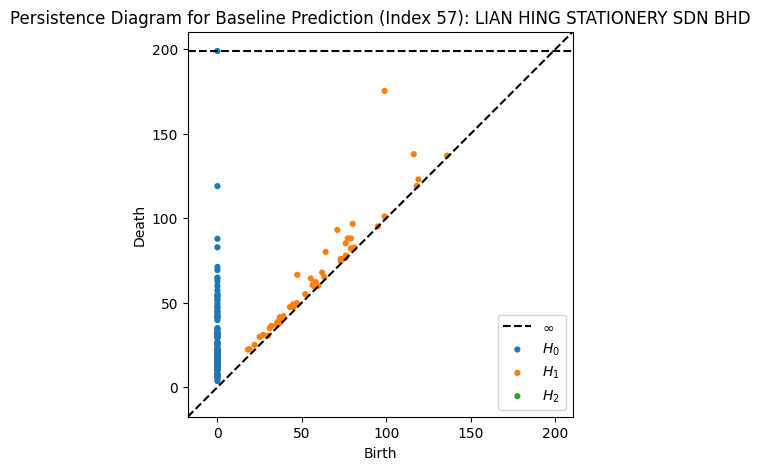

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


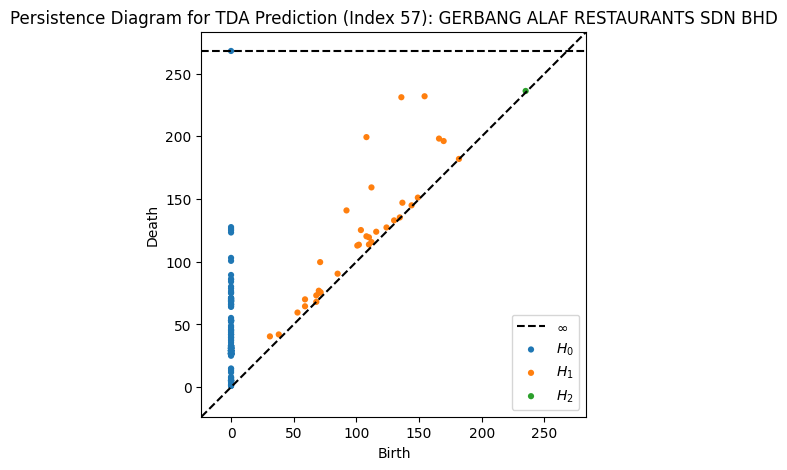

Index 57:
True Label: GERBANG ALAF RESTAURANTS SDN BHD
Baseline Prediction: LIAN HING STATIONERY SDN BHD
TDA Prediction: GERBANG ALAF RESTAURANTS SDN BHD

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


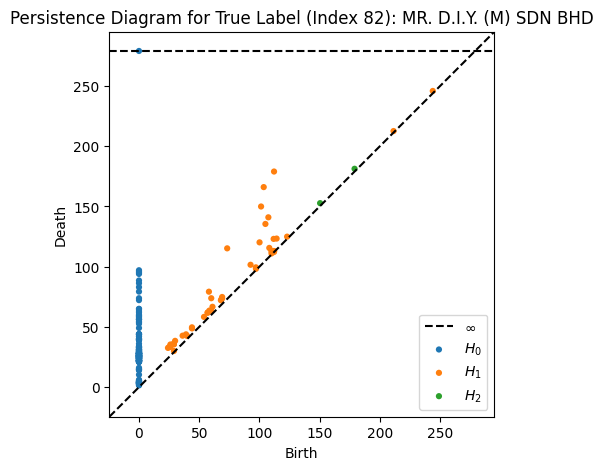

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


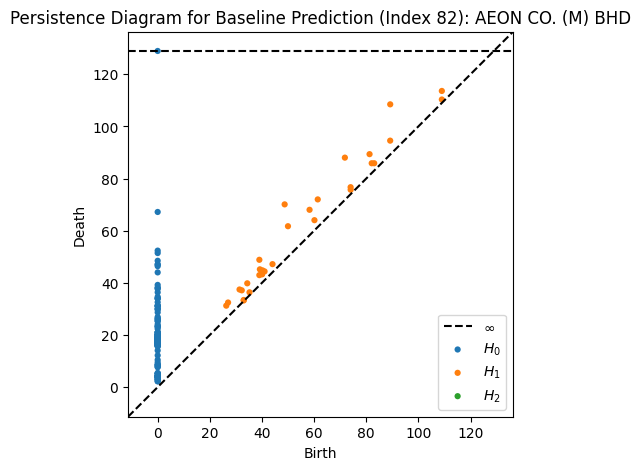

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


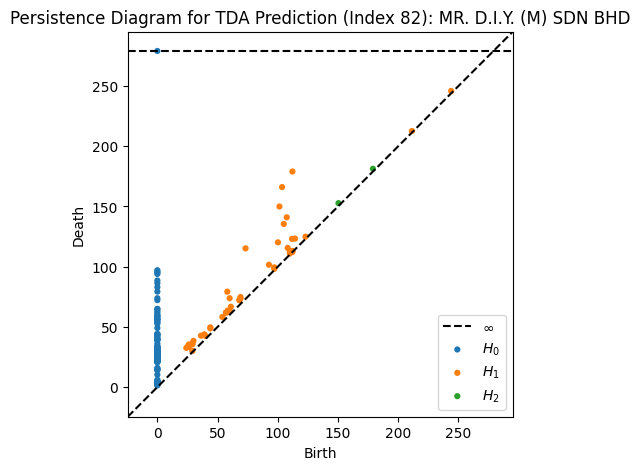

Index 82:
True Label: MR. D.I.Y. (M) SDN BHD
Baseline Prediction: AEON CO. (M) BHD
TDA Prediction: MR. D.I.Y. (M) SDN BHD



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import Rips

# Function to extract bounding box coordinates from the DataFrame based on company name
def extract_bounding_box_coordinates(df, company_name):
    try:
        # Filter the dataframe to get the first occurrence of the company name
        company_data = df[df['Company Name'] == company_name].iloc[0]
        bounding_boxes = company_data['Bounding Box Coordinates']
        if isinstance(bounding_boxes, str):
            bounding_boxes = eval(bounding_boxes)  # Convert string to list if necessary
        return np.array(bounding_boxes).reshape(-1, 2)  # Reshape to 2D coordinates
    except (KeyError, IndexError):
        print(f"Company {company_name} not found in DataFrame.")
        return None

# Function to plot persistence diagrams
def plot_persistence_diagram(points, title):
    if points is not None:
        rips = Rips(maxdim=2, thresh=np.inf)
        diagrams = rips.fit_transform(points)
        plt.figure(figsize=(10, 5))
        rips.plot(diagrams)
        plt.title(title)
        plt.show()
    else:
        print(f"No data to plot for: {title}")

# Identifying the indices where TDA outperformed Baseline
better_indices = X_test_df[model_2_better_idx].index

# Loop through the better indices to generate persistence diagrams
for idx in better_indices:
    try:
        # Convert encoded labels back to original class names
        true_label = le.inverse_transform([y_test_encoded[idx]])[0]
        baseline_prediction = le.inverse_transform([y_pred_xgb[idx]])[0]
        tda_prediction = le.inverse_transform([y_pred_xgb_model2[idx]])[0]

        # Extract bounding box coordinates for the true label, Baseline prediction, and TDA prediction
        points_true_label = extract_bounding_box_coordinates(train_df_top20, true_label)
        points_baseline = extract_bounding_box_coordinates(train_df_top20, baseline_prediction)
        points_tda = extract_bounding_box_coordinates(train_df_top20, tda_prediction)

        # Plot persistence diagrams for true label, Baseline prediction, and TDA prediction
        plot_persistence_diagram(points_true_label, f'Persistence Diagram for True Label (Index {idx}): {true_label}')
        plot_persistence_diagram(points_baseline, f'Persistence Diagram for Baseline Prediction (Index {idx}): {baseline_prediction}')
        plot_persistence_diagram(points_tda, f'Persistence Diagram for TDA Prediction (Index {idx}): {tda_prediction}')

        # Print the corresponding information
        print(f"Index {idx}:")
        print(f"True Label: {true_label}")
        print(f"Baseline Prediction: {baseline_prediction}")
        print(f"TDA Prediction: {tda_prediction}")
        print()
    except KeyError:
        print(f"Error processing index {idx}")


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


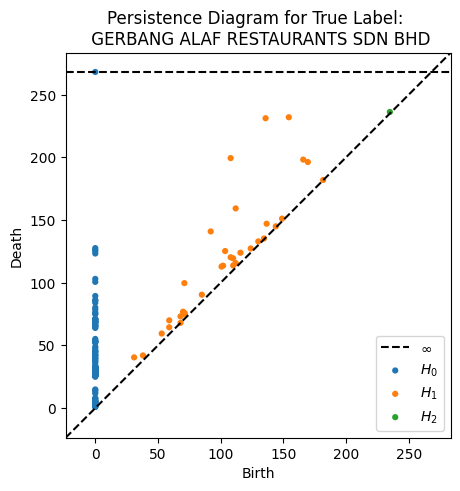

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


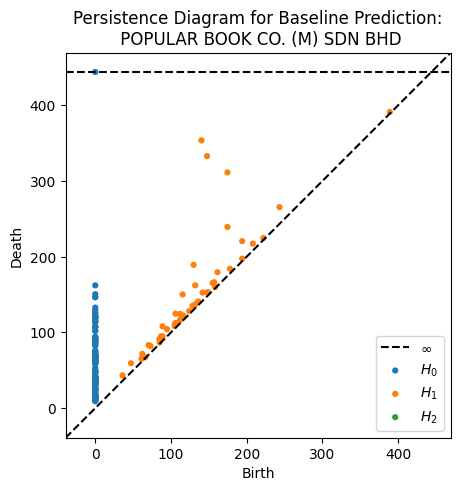

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


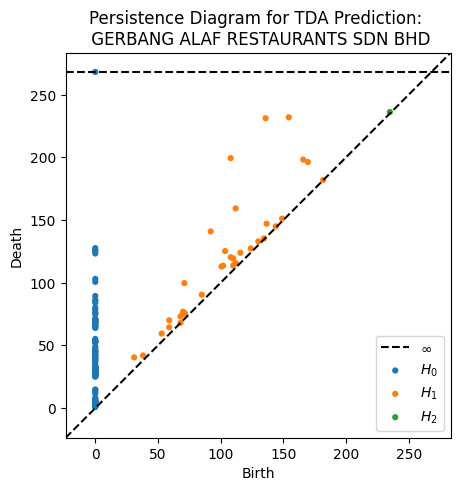

Index 0:
True Label: GERBANG ALAF RESTAURANTS SDN BHD
Baseline Prediction: POPULAR BOOK CO. (M) SDN BHD
TDA Prediction: GERBANG ALAF RESTAURANTS SDN BHD

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


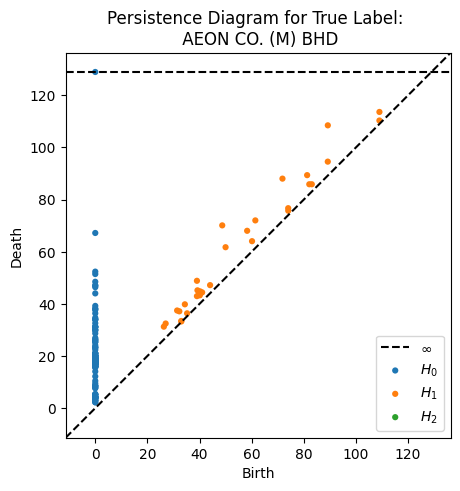

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


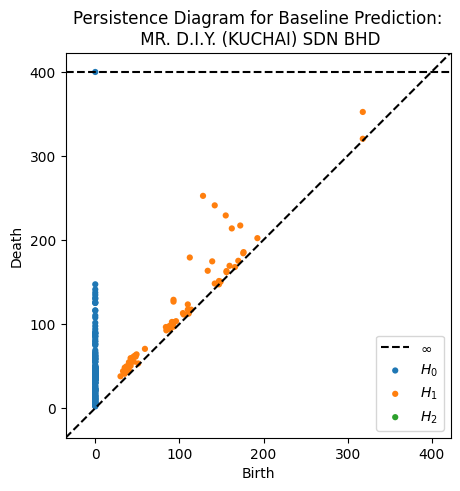

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


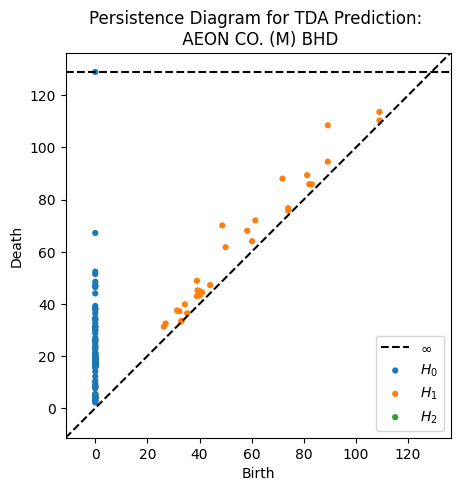

Index 44:
True Label: AEON CO. (M) BHD
Baseline Prediction: MR. D.I.Y. (KUCHAI) SDN BHD
TDA Prediction: AEON CO. (M) BHD

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


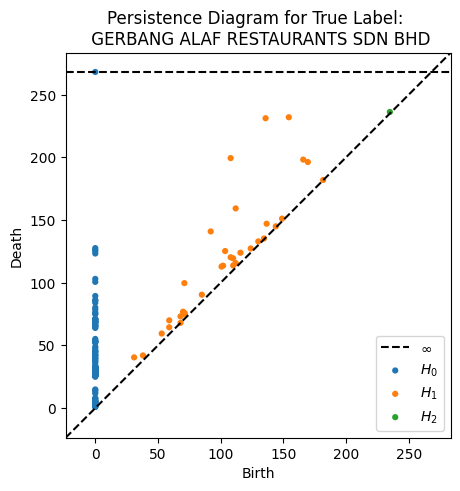

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


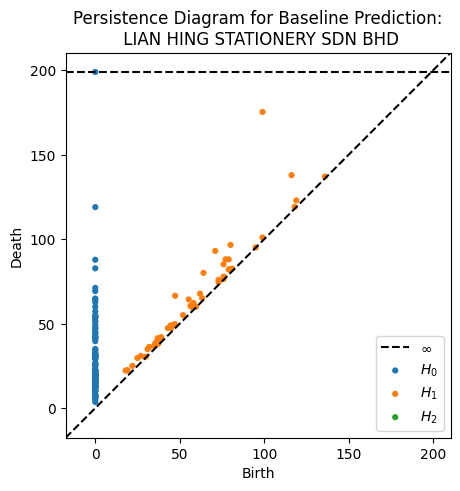

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


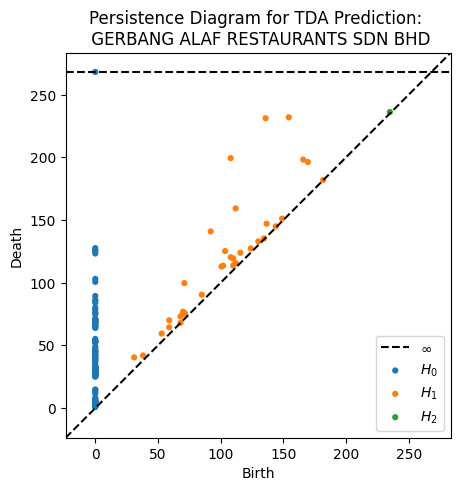

Index 57:
True Label: GERBANG ALAF RESTAURANTS SDN BHD
Baseline Prediction: LIAN HING STATIONERY SDN BHD
TDA Prediction: GERBANG ALAF RESTAURANTS SDN BHD

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


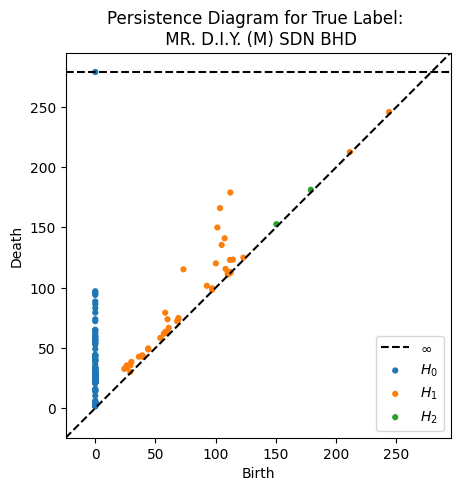

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


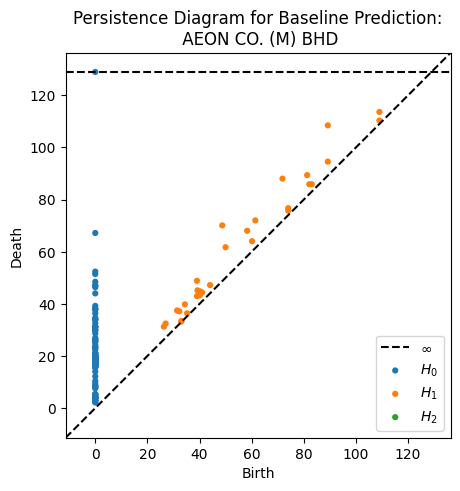

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


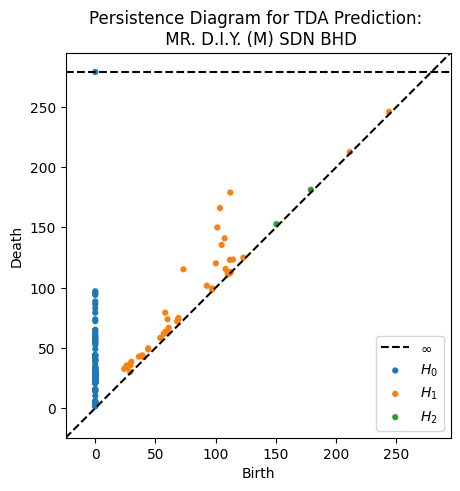

Index 82:
True Label: MR. D.I.Y. (M) SDN BHD
Baseline Prediction: AEON CO. (M) BHD
TDA Prediction: MR. D.I.Y. (M) SDN BHD



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import Rips

# Function to extract bounding box coordinates from the DataFrame based on company name
def extract_bounding_box_coordinates(df, company_name):
    try:
        # Filter the dataframe to get the first occurrence of the company name
        company_data = df[df['Company Name'] == company_name].iloc[0]
        bounding_boxes = company_data['Bounding Box Coordinates']
        if isinstance(bounding_boxes, str):
            bounding_boxes = eval(bounding_boxes)  # Convert string to list if necessary
        return np.array(bounding_boxes).reshape(-1, 2)  # Reshape to 2D coordinates
    except (KeyError, IndexError):
        print(f"Company {company_name} not found in DataFrame.")
        return None

# Function to plot persistence diagrams
def plot_persistence_diagram(points, title):
    if points is not None:
        rips = Rips(maxdim=2, thresh=np.inf)
        diagrams = rips.fit_transform(points)
        plt.figure(figsize=(10, 5))
        rips.plot(diagrams)
        plt.title(title)
        plt.show()
    else:
        print(f"No data to plot for: {title}")

# Identifying the indices where TDA outperformed Baseline
better_indices = X_test_df[model_2_better_idx].index

# Loop through the better indices to generate persistence diagrams
for idx in better_indices:
    try:
        # Convert encoded labels back to original class names
        true_label = le.inverse_transform([y_test_encoded[idx]])[0]
        baseline_prediction = le.inverse_transform([y_pred_xgb[idx]])[0]
        tda_prediction = le.inverse_transform([y_pred_xgb_model2[idx]])[0]

        # Extract bounding box coordinates for the true label, Baseline prediction, and TDA prediction
        points_true_label = extract_bounding_box_coordinates(train_df_top20, true_label)
        points_baseline = extract_bounding_box_coordinates(train_df_top20, baseline_prediction)
        points_tda = extract_bounding_box_coordinates(train_df_top20, tda_prediction)

        # Plot persistence diagrams for true label, Baseline prediction, and TDA prediction
        plot_persistence_diagram(points_true_label, f'Persistence Diagram for True Label: \n {true_label}')
        plot_persistence_diagram(points_baseline, f'Persistence Diagram for Baseline Prediction:\n {baseline_prediction}')
        plot_persistence_diagram(points_tda, f'Persistence Diagram for TDA Prediction: \n {tda_prediction}')

        # Print the corresponding information
        print(f"Index {idx}:")
        print(f"True Label: {true_label}")
        print(f"Baseline Prediction: {baseline_prediction}")
        print(f"TDA Prediction: {tda_prediction}")
        print()
    except KeyError:
        print(f"Error processing index {idx}")


In [ ]:
true_label

'MR. D.I.Y. (M) SDN BHD'

In [ ]:
y_pred_xgb_model2[82]

12

**Combined approach-** **Area, centroid, h1 and h2 features**

In [ ]:
X_train_baseline.shape

(342, 600)

In [ ]:
X_test_baseline.shape

(161, 600)

In [ ]:
X_train_df.shape

(342, 463)

In [ ]:
X_test_df.shape

(161, 463)

In [ ]:
# Combine baseline features with persistence features
X_train_combined = np.hstack((X_train_baseline, X_train_df))
X_test_combined = np.hstack((X_test_baseline, X_test_df))


In [ ]:
X_train_combined

array([[4.4408e+04, 1.0870e+03, 5.8750e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.3200e+04, 5.0100e+02, 4.7500e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.7240e+03, 2.7700e+02, 1.3850e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.7360e+03, 7.5000e+01, 2.9000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.1852e+04, 3.9050e+02, 3.5900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.7545e+04, 3.8750e+02, 3.4850e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [ ]:
#Train a RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train_combined, y_train_baseline)

# Make predictions
y_pred = clf.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test_baseline, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9379


Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForestClassifier
clf = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_combined, y_train_baseline)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best estimator to make predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test_baseline, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.9038
Test accuracy: 0.9379


Logistic Regression

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': [100, 200]
}

# Initialize LogisticRegression
clf = LogisticRegression()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_combined, y_train_baseline)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best estimator to make predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test_baseline, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *ar

Best parameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.8364
Test accuracy: 0.8634


KNN

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

# Initialize KNeighborsClassifier
knn = KNeighborsClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_combined, y_train_baseline)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best estimator to make predictions
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test_baseline, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score: 0.7926
Test accuracy: 0.8571


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.7516624  0.7516624  0.70771526 0.72237852 0.6756607  0.71952259
 0.65221654 0.69612106 0.63171355 0.67851662        nan 0.79258312
        nan 0.76040068        nan 0.75456095        nan 0.75745951
        nan 0.74872123        nan 0.59360614        nan 0.61112532
        nan 0.57028986        nan 0.5644075         nan 0.54092072
 0.7516624  0.7516624  0.70771526 0.72237852 0.6756607  0.71952259
 0.65221654 0.69612106 0.63171355 0.67851662]
  warnings.warn(


XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the reduced parameter grid
param_grid_reduced = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_reduced, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_combined, y_train_encoded)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best estimator to make predictions
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_combined)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test accuracy: {accuracy:.4f}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:45:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation score: 0.8806
Test accuracy: 0.9503


In [ ]:
# Initialize XGBoost model
xgb_model = XGBClassifier()

# Train the model with the encoded labels
xgb_model.fit(X_train_combined, y_train_encoded)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_combined)

# Evaluate the accuracy
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Test Accuracy (XGBoost): {accuracy_xgb * 100:.2f}%")

Test Accuracy (XGBoost): 94.41%


**Baseline- Train test split code by combining train and test**

In [65]:
# Combine train and test datasets
combined_df = pd.concat([train_df_top20, test_df_top20])

# Shuffle the combined dataset to ensure randomness
combined_df = combined_df.sample(frac=1).reset_index(drop=True)


In [66]:
combined_df

,Filename,Bounding Box Coordinates,Company Name
0,X51005676542,"[[82, 203, 836, 203, 836, 260, 82, 260], [372,...",SYARIKAT PERNIAGAAN GIN KEE
1,X51008164992,"[[91, 341, 695, 341, 695, 381, 91, 381], [307,...",ONE ONE THREE SEAFOOD RESTAURANT SDN BHD
2,X51005711452,"[[368, 220, 479, 220, 479, 294, 368, 294], [96...",GERBANG ALAF RESTAURANTS SDN BHD
3,X51006912974,"[[1416, 1838, 2752, 1838, 2752, 1952, 1416, 19...",UNIHAKKA INTERNATIONAL SDN BHD
4,X51007846307,"[[1669, 1727, 3010, 1727, 3010, 1827, 1669, 18...",UNIHAKKA INTERNATIONAL SDN BHD
...,...,...,...
498,X51008099044,"[[238, 269, 562, 269, 562, 306, 238, 306], [29...",RESTORAN WAN SHENG
499,X51007846372,"[[1465, 1717, 2799, 1717, 2799, 1806, 1465, 18...",UNIHAKKA INTERNATIONAL SDN BHD
500,X51005433494,"[[379, 262, 588, 262, 588, 283, 379, 283], [37...",AEON CO. (M) BHD
501,X51006619694,"[[28, 400, 650, 400, 650, 448, 28, 448], [28, ...",GUARDIAN HEALTH AND BEAUTY SDN BHD


In [ ]:
from sklearn.model_selection import train_test_split

def split_and_process(combined_df, train_size, num_rows, num_columns):
    # Split the data
    train_df, test_df = train_test_split(combined_df, train_size=train_size, stratify=combined_df['Company Name'])

    # Process the datasets
    X_train_baseline, y_train_baseline = process_dataset(train_df, num_rows, num_columns)
    X_test_baseline, y_test_baseline = process_dataset(test_df, num_rows, num_columns)

    return X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline


LOGISTIC REGRESSION

In [ ]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    # Train the model
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy


In [ ]:
# Define the size of the sparse matrix
num_rows = 200  # Example size
num_columns = 3  # Three columns for area, centroid_x, and centroid_y

# Define train-test splits
splits = [0.7, 0.8, 0.9, 0.6]

# Run through each split
for split in splits:
    print(f"\nTrain-Test Split: {int(split*100)}-{int((1-split)*100)}")
    X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline = split_and_process(combined_df, split, num_rows, num_columns)
    accuracy = train_and_evaluate(X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline)
    print(f"Accuracy for {int(split*100)}-{int((1-split)*100)} split: {accuracy * 100:.2f}%")



Train-Test Split: 70-30
Test Accuracy: 82.78%
Accuracy for 70-30 split: 82.78%

Train-Test Split: 80-19
Test Accuracy: 82.18%
Accuracy for 80-19 split: 82.18%

Train-Test Split: 90-9
Test Accuracy: 82.35%
Accuracy for 90-9 split: 82.35%

Train-Test Split: 60-40
Test Accuracy: 82.18%
Accuracy for 60-40 split: 82.18%


In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Function to calculate area and centroid of bounding boxes
def calculate_area_and_centroid(coordinates):
    areas = []
    centroids = []
    for box in coordinates:
        x0, y0, x1, y1, x2, y2, x3, y3 = box
        area = (x2 - x0) * (y2 - y0)
        centroid_x = (x0 + x2) / 2
        centroid_y = (y0 + y2) / 2
        areas.append(area)
        centroids.append((centroid_x, centroid_y))
    return areas, centroids

# Function to create a sparse matrix from areas and centroids
def create_sparse_matrix(coordinates, areas, centroids, num_rows, num_columns):
    row = []
    col = []
    data = []

    for i, (area, centroid) in enumerate(zip(areas, centroids)):
        row.extend([i] * 3)
        col.extend([0, 1, 2])
        data.extend([area, centroid[0], centroid[1]])

    sparse_matrix = coo_matrix((data, (row, col)), shape=(num_rows, num_columns))
    return sparse_matrix

# Function to process the dataset into feature vectors and labels
def process_dataset(df, num_rows, num_columns):
    features = []
    labels = df['Company Name'].values

    for index, row in df.iterrows():
        bounding_boxes = eval(row['Bounding Box Coordinates'])
        areas, centroids = calculate_area_and_centroid(bounding_boxes)
        sparse_matrix = create_sparse_matrix(bounding_boxes, areas, centroids, num_rows, num_columns)
        features.append(sparse_matrix.toarray().flatten())

    return np.array(features), labels

# Function to split the combined dataset and process it
def split_and_process(combined_df, train_size, num_rows, num_columns):
    train_df, test_df = train_test_split(combined_df, train_size=train_size, stratify=combined_df['Company Name'])
    X_train_baseline, y_train_baseline = process_dataset(train_df, num_rows, num_columns)
    X_test_baseline, y_test_baseline = process_dataset(test_df, num_rows, num_columns)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_baseline)
    y_test_encoded = label_encoder.transform(y_test_baseline)

    return X_train_baseline, y_train_encoded, X_test_baseline, y_test_encoded

# Function to train and evaluate the Logistic Regression model
def train_and_evaluate_lr(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Define the size of the sparse matrix
num_rows = 200  # Example size
num_columns = 3  # Three columns for area, centroid_x, and centroid_y

# Define train-test splits
splits = [0.7, 0.8, 0.9, 0.6]

# Combine train and test datasets
combined_df = pd.concat([train_df_top20, test_df_top20])
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# Collect accuracies
accuracies = []

# Run through each split
for split in splits:
    print(f"\nTrain-Test Split: {int(split*100)}-{int((1-split)*100)}")
    X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline = split_and_process(combined_df, split, num_rows, num_columns)
    accuracy = train_and_evaluate_lr(X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline)
    accuracies.append(accuracy)
    print(f"Accuracy for {int(split*100)}-{int((1-split)*100)} split: {accuracy * 100:.2f}%")

# Calculate mean and standard deviation
mean_accuracy = np.mean(accuracies)
sd_accuracy = np.std(accuracies)

# Print results
print(f"\nMean Accuracy for Logistic Regression: {mean_accuracy * 100:.2f}%")
print(f"Standard Deviation of Accuracy for Logistic Regression: {sd_accuracy * 100:.2f}%")



Train-Test Split: 70-30
Accuracy for 70-30 split: 83.44%

Train-Test Split: 80-19
Accuracy for 80-19 split: 89.11%

Train-Test Split: 90-9
Accuracy for 90-9 split: 86.27%

Train-Test Split: 60-40
Accuracy for 60-40 split: 89.60%

Mean Accuracy for Logistic Regression: 87.11%
Standard Deviation of Accuracy for Logistic Regression: 2.47%


KNN

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Function to calculate area and centroid of bounding boxes
def calculate_area_and_centroid(coordinates):
    areas = []
    centroids = []
    for box in coordinates:
        x0, y0, x1, y1, x2, y2, x3, y3 = box
        area = (x2 - x0) * (y2 - y0)
        centroid_x = (x0 + x2) / 2
        centroid_y = (y0 + y2) / 2
        areas.append(area)
        centroids.append((centroid_x, centroid_y))
    return areas, centroids

# Function to create a sparse matrix from areas and centroids
def create_sparse_matrix(coordinates, areas, centroids, num_rows, num_columns):
    row = []
    col = []
    data = []

    for i, (area, centroid) in enumerate(zip(areas, centroids)):
        row.extend([i] * 3)
        col.extend([0, 1, 2])
        data.extend([area, centroid[0], centroid[1]])

    sparse_matrix = coo_matrix((data, (row, col)), shape=(num_rows, num_columns))
    return sparse_matrix

# Function to process the dataset into feature vectors and labels
def process_dataset(df, num_rows, num_columns):
    features = []
    labels = df['Company Name'].values

    for index, row in df.iterrows():
        bounding_boxes = eval(row['Bounding Box Coordinates'])
        areas, centroids = calculate_area_and_centroid(bounding_boxes)
        sparse_matrix = create_sparse_matrix(bounding_boxes, areas, centroids, num_rows, num_columns)
        features.append(sparse_matrix.toarray().flatten())

    return np.array(features), labels

# Function to split the combined dataset and process it
def split_and_process(combined_df, train_size, num_rows, num_columns):
    train_df, test_df = train_test_split(combined_df, train_size=train_size, stratify=combined_df['Company Name'])
    X_train_baseline, y_train_baseline = process_dataset(train_df, num_rows, num_columns)
    X_test_baseline, y_test_baseline = process_dataset(test_df, num_rows, num_columns)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_baseline)
    y_test_encoded = label_encoder.transform(y_test_baseline)

    return X_train_baseline, y_train_encoded, X_test_baseline, y_test_encoded

# Function to train and evaluate the Logistic Regression model
def train_and_evaluate_lr(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Function to train and evaluate the KNN model
def train_and_evaluate_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Define the size of the sparse matrix
num_rows = 200  # Example size
num_columns = 3  # Three columns for area, centroid_x, and centroid_y

# Define train-test splits
splits = [0.7, 0.8, 0.9, 0.6]

# Combine train and test datasets
combined_df = pd.concat([train_df_top20, test_df_top20])
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# Collect accuracies for Logistic Regression and KNN
accuracies_lr = []
accuracies_knn = []

# Run through each split for Logistic Regression and KNN
for split in splits:
    print(f"\nTrain-Test Split: {int(split*100)}-{int((1-split)*100)}")

    # Logistic Regression
    X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline = split_and_process(combined_df, split, num_rows, num_columns)
    accuracy_lr = train_and_evaluate_lr(X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline)
    accuracies_lr.append(accuracy_lr)
    print(f"Logistic Regression Accuracy for {int(split*100)}-{int((1-split)*100)} split: {accuracy_lr * 100:.2f}%")

    # KNN
    accuracy_knn = train_and_evaluate_knn(X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline)
    accuracies_knn.append(accuracy_knn)
    print(f"KNN Accuracy for {int(split*100)}-{int((1-split)*100)} split: {accuracy_knn * 100:.2f}%")

# Calculate mean and standard deviation for Logistic Regression and KNN
mean_accuracy_lr = np.mean(accuracies_lr)
sd_accuracy_lr = np.std(accuracies_lr)

mean_accuracy_knn = np.mean(accuracies_knn)
sd_accuracy_knn = np.std(accuracies_knn)

# Print results
print(f"\nMean Accuracy for Logistic Regression: {mean_accuracy_lr * 100:.2f}%")
print(f"Standard Deviation of Accuracy for Logistic Regression: {sd_accuracy_lr * 100:.2f}%")

print(f"\nMean Accuracy for KNN: {mean_accuracy_knn * 100:.2f}%")
print(f"Standard Deviation of Accuracy for KNN: {sd_accuracy_knn * 100:.2f}%")



Train-Test Split: 70-30
Logistic Regression Accuracy for 70-30 split: 86.09%
KNN Accuracy for 70-30 split: 77.48%

Train-Test Split: 80-19
Logistic Regression Accuracy for 80-19 split: 82.18%
KNN Accuracy for 80-19 split: 76.24%

Train-Test Split: 90-9
Logistic Regression Accuracy for 90-9 split: 88.24%
KNN Accuracy for 90-9 split: 80.39%

Train-Test Split: 60-40
Logistic Regression Accuracy for 60-40 split: 85.15%
KNN Accuracy for 60-40 split: 76.73%

Mean Accuracy for Logistic Regression: 85.41%
Standard Deviation of Accuracy for Logistic Regression: 2.18%

Mean Accuracy for KNN: 77.71%
Standard Deviation of Accuracy for KNN: 1.61%


Random Forest

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Function to calculate area and centroid of bounding boxes
def calculate_area_and_centroid(coordinates):
    areas = []
    centroids = []
    for box in coordinates:
        x0, y0, x1, y1, x2, y2, x3, y3 = box
        area = (x2 - x0) * (y2 - y0)
        centroid_x = (x0 + x2) / 2
        centroid_y = (y0 + y2) / 2
        areas.append(area)
        centroids.append((centroid_x, centroid_y))
    return areas, centroids

# Function to create a sparse matrix from areas and centroids
def create_sparse_matrix(coordinates, areas, centroids, num_rows, num_columns):
    row = []
    col = []
    data = []

    for i, (area, centroid) in enumerate(zip(areas, centroids)):
        row.extend([i] * 3)
        col.extend([0, 1, 2])
        data.extend([area, centroid[0], centroid[1]])

    sparse_matrix = coo_matrix((data, (row, col)), shape=(num_rows, num_columns))
    return sparse_matrix

# Function to process the dataset into feature vectors and labels
def process_dataset(df, num_rows, num_columns):
    features = []
    labels = df['Company Name'].values

    for index, row in df.iterrows():
        bounding_boxes = eval(row['Bounding Box Coordinates'])
        areas, centroids = calculate_area_and_centroid(bounding_boxes)
        sparse_matrix = create_sparse_matrix(bounding_boxes, areas, centroids, num_rows, num_columns)
        features.append(sparse_matrix.toarray().flatten())

    return np.array(features), labels

# Function to split the combined dataset and process it
def split_and_process(combined_df, train_size, num_rows, num_columns):
    train_df, test_df = train_test_split(combined_df, train_size=train_size, stratify=combined_df['Company Name'])
    X_train_baseline, y_train_baseline = process_dataset(train_df, num_rows, num_columns)
    X_test_baseline, y_test_baseline = process_dataset(test_df, num_rows, num_columns)
    return X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline

# Function to train and evaluate the RandomForest model
def train_and_evaluate(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=None):
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Define the size of the sparse matrix
num_rows = 200  # Example size
num_columns = 3  # Three columns for area, centroid_x, and centroid_y

# Define train-test splits
splits = [0.7, 0.8, 0.9, 0.6]

# Combine train and test datasets
combined_df = pd.concat([train_df_top20, test_df_top20])
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# Run through each split
for split in splits:
    print(f"\nTrain-Test Split: {int(split*100)}-{int((1-split)*100)}")
    X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline = split_and_process(combined_df, split, num_rows, num_columns)
    accuracy = train_and_evaluate(X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline)
    print(f"Accuracy for {int(split*100)}-{int((1-split)*100)} split: {accuracy * 100:.2f}%")



Train-Test Split: 70-30
Test Accuracy: 89.40%
Accuracy for 70-30 split: 89.40%

Train-Test Split: 80-19
Test Accuracy: 92.08%
Accuracy for 80-19 split: 92.08%

Train-Test Split: 90-9
Test Accuracy: 92.16%
Accuracy for 90-9 split: 92.16%

Train-Test Split: 60-40
Test Accuracy: 92.08%
Accuracy for 60-40 split: 92.08%


XGBoost

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Function to calculate area and centroid of bounding boxes
def calculate_area_and_centroid(coordinates):
    areas = []
    centroids = []
    for box in coordinates:
        x0, y0, x1, y1, x2, y2, x3, y3 = box
        area = (x2 - x0) * (y2 - y0)
        centroid_x = (x0 + x2) / 2
        centroid_y = (y0 + y2) / 2
        areas.append(area)
        centroids.append((centroid_x, centroid_y))
    return areas, centroids

# Function to create a sparse matrix from areas and centroids
def create_sparse_matrix(coordinates, areas, centroids, num_rows, num_columns):
    row = []
    col = []
    data = []

    for i, (area, centroid) in enumerate(zip(areas, centroids)):
        row.extend([i] * 3)
        col.extend([0, 1, 2])
        data.extend([area, centroid[0], centroid[1]])

    sparse_matrix = coo_matrix((data, (row, col)), shape=(num_rows, num_columns))
    return sparse_matrix

# Function to process the dataset into feature vectors and labels
def process_dataset(df, num_rows, num_columns):
    features = []
    labels = df['Company Name'].values

    for index, row in df.iterrows():
        bounding_boxes = eval(row['Bounding Box Coordinates'])
        areas, centroids = calculate_area_and_centroid(bounding_boxes)
        sparse_matrix = create_sparse_matrix(bounding_boxes, areas, centroids, num_rows, num_columns)
        features.append(sparse_matrix.toarray().flatten())

    return np.array(features), labels

# Function to split the combined dataset and process it
def split_and_process(combined_df, train_size, num_rows, num_columns):
    train_df, test_df = train_test_split(combined_df, train_size=train_size, stratify=combined_df['Company Name'])
    X_train_baseline, y_train_baseline = process_dataset(train_df, num_rows, num_columns)
    X_test_baseline, y_test_baseline = process_dataset(test_df, num_rows, num_columns)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_baseline)
    y_test_encoded = label_encoder.transform(y_test_baseline)

    return X_train_baseline, y_train_encoded, X_test_baseline, y_test_encoded

# Function to train and evaluate the XGBoost model
def train_and_evaluate(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=6, learning_rate=0.1):
    clf = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, use_label_encoder=False, eval_metric='mlogloss')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Define the size of the sparse matrix
num_rows = 200  # Example size
num_columns = 3  # Three columns for area, centroid_x, and centroid_y

# Define train-test splits
splits = [0.7, 0.8, 0.9, 0.6]

# Combine train and test datasets
combined_df = pd.concat([train_df_top20, test_df_top20])
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# Run through each split
for split in splits:
    print(f"\nTrain-Test Split: {int(split*100)}-{int((1-split)*100)}")
    X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline = split_and_process(combined_df, split, num_rows, num_columns)
    accuracy = train_and_evaluate(X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline)
    print(f"Accuracy for {int(split*100)}-{int((1-split)*100)} split: {accuracy * 100:.2f}%")



Train-Test Split: 70-30


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:01:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 88.74%
Accuracy for 70-30 split: 88.74%

Train-Test Split: 80-19


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:01:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 91.09%
Accuracy for 80-19 split: 91.09%

Train-Test Split: 90-9


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:01:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 92.16%
Accuracy for 90-9 split: 92.16%

Train-Test Split: 60-40


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:01:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 88.12%
Accuracy for 60-40 split: 88.12%


In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Function to calculate area and centroid of bounding boxes
def calculate_area_and_centroid(coordinates):
    areas = []
    centroids = []
    for box in coordinates:
        x0, y0, x1, y1, x2, y2, x3, y3 = box
        area = (x2 - x0) * (y2 - y0)
        centroid_x = (x0 + x2) / 2
        centroid_y = (y0 + y2) / 2
        areas.append(area)
        centroids.append((centroid_x, centroid_y))
    return areas, centroids

# Function to create a sparse matrix from areas and centroids
def create_sparse_matrix(coordinates, areas, centroids, num_rows, num_columns):
    row = []
    col = []
    data = []

    for i, (area, centroid) in enumerate(zip(areas, centroids)):
        row.extend([i] * 3)
        col.extend([0, 1, 2])
        data.extend([area, centroid[0], centroid[1]])

    sparse_matrix = coo_matrix((data, (row, col)), shape=(num_rows, num_columns))
    return sparse_matrix

# Function to process the dataset into feature vectors and labels
def process_dataset(df, num_rows, num_columns):
    features = []
    labels = df['Company Name'].values

    for index, row in df.iterrows():
        bounding_boxes = eval(row['Bounding Box Coordinates'])
        areas, centroids = calculate_area_and_centroid(bounding_boxes)
        sparse_matrix = create_sparse_matrix(bounding_boxes, areas, centroids, num_rows, num_columns)
        features.append(sparse_matrix.toarray().flatten())

    return np.array(features), labels

# Function to split the combined dataset and process it
def split_and_process(combined_df, train_size, num_rows, num_columns):
    train_df, test_df = train_test_split(combined_df, train_size=train_size, stratify=combined_df['Company Name'])
    X_train_baseline, y_train_baseline = process_dataset(train_df, num_rows, num_columns)
    X_test_baseline, y_test_baseline = process_dataset(test_df, num_rows, num_columns)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_baseline)
    y_test_encoded = label_encoder.transform(y_test_baseline)

    return X_train_baseline, y_train_encoded, X_test_baseline, y_test_encoded

# Function to train and evaluate the Logistic Regression model
def train_and_evaluate_lr(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Function to train and evaluate the KNN model
def train_and_evaluate_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Function to train and evaluate the Random Forest model
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, n_estimators=100):
    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Function to train and evaluate the XGBoost model
def train_and_evaluate_xgb(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Define the size of the sparse matrix
num_rows = 200  # Example size
num_columns = 3  # Three columns for area, centroid_x, and centroid_y

# Define train-test splits
splits = [0.7, 0.8, 0.9, 0.6]

# Combine train and test datasets
combined_df = pd.concat([train_df_top20, test_df_top20])
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# Collect accuracies for Logistic Regression, KNN, Random Forest, and XGBoost
accuracies_lr = []
accuracies_knn = []
accuracies_rf = []
accuracies_xgb = []

# Run through each split for Logistic Regression, KNN, Random Forest, and XGBoost
for split in splits:
    print(f"\nTrain-Test Split: {int(split*100)}-{int((1-split)*100)}")

    # Split and process data
    X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline = split_and_process(combined_df, split, num_rows, num_columns)

    # Logistic Regression
    accuracy_lr = train_and_evaluate_lr(X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline)
    accuracies_lr.append(accuracy_lr)
    print(f"Logistic Regression Accuracy for {int(split*100)}-{int((1-split)*100)} split: {accuracy_lr * 100:.2f}%")

    # KNN
    accuracy_knn = train_and_evaluate_knn(X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline)
    accuracies_knn.append(accuracy_knn)
    print(f"KNN Accuracy for {int(split*100)}-{int((1-split)*100)} split: {accuracy_knn * 100:.2f}%")

    # Random Forest
    accuracy_rf = train_and_evaluate_rf(X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline)
    accuracies_rf.append(accuracy_rf)
    print(f"Random Forest Accuracy for {int(split*100)}-{int((1-split)*100)} split: {accuracy_rf * 100:.2f}%")

    # XGBoost
    accuracy_xgb = train_and_evaluate_xgb(X_train_baseline, y_train_baseline, X_test_baseline, y_test_baseline)
    accuracies_xgb.append(accuracy_xgb)
    print(f"XGBoost Accuracy for {int(split*100)}-{int((1-split)*100)} split: {accuracy_xgb * 100:.2f}%")

# Calculate mean and standard deviation for each model
mean_accuracy_lr = np.mean(accuracies_lr)
sd_accuracy_lr = np.std(accuracies_lr)

mean_accuracy_knn = np.mean(accuracies_knn)
sd_accuracy_knn = np.std(accuracies_knn)

mean_accuracy_rf = np.mean(accuracies_rf)
sd_accuracy_rf = np.std(accuracies_rf)

mean_accuracy_xgb = np.mean(accuracies_xgb)
sd_accuracy_xgb = np.std(accuracies_xgb)

# Print results
print(f"\nMean Accuracy for Logistic Regression: {mean_accuracy_lr * 100:.2f}%")
print(f"Standard Deviation of Accuracy for Logistic Regression: {sd_accuracy_lr * 100:.2f}%")

print(f"\nMean Accuracy for KNN: {mean_accuracy_knn * 100:.2f}%")
print(f"Standard Deviation of Accuracy for KNN: {sd_accuracy_knn * 100:.2f}%")

print(f"\nMean Accuracy for Random Forest: {mean_accuracy_rf * 100:.2f}%")
print(f"Standard Deviation of Accuracy for Random Forest: {sd_accuracy_rf * 100:.2f}%")

print(f"\nMean Accuracy for XGBoost: {mean_accuracy_xgb * 100:.2f}%")
print(f"Standard Deviation of Accuracy for XGBoost: {sd_accuracy_xgb * 100:.2f}%")



Train-Test Split: 70-30
Logistic Regression Accuracy for 70-30 split: 82.12%
KNN Accuracy for 70-30 split: 74.17%
Random Forest Accuracy for 70-30 split: 88.74%


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:59:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy for 70-30 split: 86.09%

Train-Test Split: 80-19
Logistic Regression Accuracy for 80-19 split: 87.13%
KNN Accuracy for 80-19 split: 78.22%
Random Forest Accuracy for 80-19 split: 90.10%


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:59:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy for 80-19 split: 88.12%

Train-Test Split: 90-9
Logistic Regression Accuracy for 90-9 split: 84.31%
KNN Accuracy for 90-9 split: 72.55%
Random Forest Accuracy for 90-9 split: 90.20%


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:00:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy for 90-9 split: 88.24%

Train-Test Split: 60-40
Logistic Regression Accuracy for 60-40 split: 85.15%
KNN Accuracy for 60-40 split: 71.29%
Random Forest Accuracy for 60-40 split: 91.09%


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy for 60-40 split: 88.12%

Mean Accuracy for Logistic Regression: 84.68%
Standard Deviation of Accuracy for Logistic Regression: 1.80%

Mean Accuracy for KNN: 74.06%
Standard Deviation of Accuracy for KNN: 2.61%

Mean Accuracy for Random Forest: 90.03%
Standard Deviation of Accuracy for Random Forest: 0.84%

Mean Accuracy for XGBoost: 87.64%
Standard Deviation of Accuracy for XGBoost: 0.90%


**TDA Logistic Regression - 0.7 split**

In [ ]:
import numpy as np
import pandas as pd
from ripser import Rips
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define a function to convert bounding box coordinates to points
def bounding_boxes_to_points(bounding_boxes):
    points = np.array(bounding_boxes).reshape(-1, 2)
    return points

# Define a function to compute persistence diagrams and extract features
def compute_persistence_features(data_list, epsilon=0.01):
    rips = Rips(maxdim=2)
    features = []

    for data in data_list:
        points = bounding_boxes_to_points(data)
        diagrams = rips.fit_transform(points)

        # Extract persistence diagrams
        h1 = diagrams[1] if len(diagrams) > 1 else np.array([])
        h2 = diagrams[2] if len(diagrams) > 2 else np.array([])

        # Filter out points close to the diagonal
        h1 = h1[h1[:, 1] - h1[:, 0] > epsilon]
        h2 = h2[h2[:, 1] - h2[:, 0] > epsilon]

        # Flatten h1 and h2 arrays for the feature vector
        h1_flat = h1.flatten() if h1.size > 0 else np.array([0])
        h2_flat = h2.flatten() if h2.size > 0 else np.array([0])

        # Append features
        features.append(np.concatenate((h1_flat, h2_flat)))

    return features


# Split the combined dataset
train_df, test_df = train_test_split(combined_df, train_size=0.7, stratify=combined_df['Company Name'])

# Compute features for train and test datasets
raw_data_list_train = train_df['Bounding Box Coordinates'].apply(eval).tolist()
X_train_features = compute_persistence_features(raw_data_list_train)

raw_data_list_test = test_df['Bounding Box Coordinates'].apply(eval).tolist()
X_test_features = compute_persistence_features(raw_data_list_test)

# Determine the maximum length of the feature vectors
max_length = max(max(len(f) for f in X_train_features), max(len(f) for f in X_test_features))

# Pad the feature vectors with zeros to ensure uniform length
X_train = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in X_train_features])
X_test = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in X_test_features])

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['Company Name'])
y_test_encoded = label_encoder.transform(test_df['Company Name'])

# Train and evaluate Random Forest
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_train, y_train_encoded)
y_pred_rf = clf_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")




Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Random Forest Accuracy: 82.12%


**TDA Random Forest - 4 splits**

In [67]:
import numpy as np
import pandas as pd
from ripser import Rips
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define a function to convert bounding box coordinates to points
def bounding_boxes_to_points(bounding_boxes):
    points = np.array(bounding_boxes).reshape(-1, 2)
    return points

# Define a function to compute persistence diagrams and extract features
def compute_persistence_features(data_list, epsilon=0.01):
    rips = Rips(maxdim=2)
    features = []

    for data in data_list:
        points = bounding_boxes_to_points(data)
        diagrams = rips.fit_transform(points)

        # Extract persistence diagrams
        h1 = diagrams[1] if len(diagrams) > 1 else np.array([])
        h2 = diagrams[2] if len(diagrams) > 2 else np.array([])

        # Filter out points close to the diagonal
        h1 = h1[h1[:, 1] - h1[:, 0] > epsilon]
        h2 = h2[h2[:, 1] - h2[:, 0] > epsilon]

        # Flatten h1 and h2 arrays for the feature vector
        h1_flat = h1.flatten() if h1.size > 0 else np.array([0])
        h2_flat = h2.flatten() if h2.size > 0 else np.array([0])

        # Append features
        features.append(np.concatenate((h1_flat, h2_flat)))

    return features

# Define splits
splits = [0.6, 0.7, 0.8, 0.9]

# List to store accuracies
accuracies = []

# Loop through each split ratio
for split in splits:
    print(f"\nTrain-Test Split: {int(split*100)}-{int((1-split)*100)}")

    # Split the combined dataset
    train_df, test_df = train_test_split(combined_df, train_size=split, stratify=combined_df['Company Name'])

    # Compute features for train and test datasets
    raw_data_list_train = train_df['Bounding Box Coordinates'].apply(eval).tolist()
    X_train_features = compute_persistence_features(raw_data_list_train)

    raw_data_list_test = test_df['Bounding Box Coordinates'].apply(eval).tolist()
    X_test_features = compute_persistence_features(raw_data_list_test)

    # Determine the maximum length of the feature vectors
    max_length = max(max(len(f) for f in X_train_features), max(len(f) for f in X_test_features))

    # Pad the feature vectors with zeros to ensure uniform length
    X_train = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in X_train_features])
    X_test = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in X_test_features])

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(train_df['Company Name'])
    y_test_encoded = label_encoder.transform(test_df['Company Name'])

    # Train and evaluate Random Forest
    clf_rf = RandomForestClassifier(n_estimators=100)
    clf_rf.fit(X_train, y_train_encoded)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
    accuracies.append(accuracy_rf)
    print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")

# Calculate mean and standard deviation of accuracies
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

# Print results
print(f"\nMean Accuracy for Random Forest: {mean_accuracy * 100:.2f}%")
print(f"Standard Deviation of Accuracy for Random Forest: {std_accuracy * 100:.2f}%")



Train-Test Split: 60-40
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Random Forest Accuracy: 77.23%

Train-Test Split: 70-30
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Random Forest Accuracy: 82.78%

Train-Test Split: 80-19
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Random Forest Accuracy: 78.22%

Train-Test Split: 90-9
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Random Forest Accuracy: 78.43%

Mean Accuracy for Random Forest: 79.16%
Standard Deviation of Accuracy for Random Forest: 2.14%
